In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

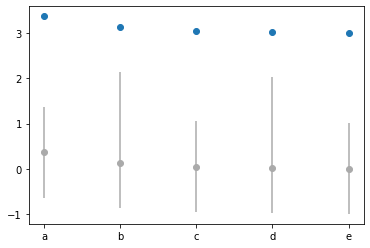

In [2]:
# Import the necessary packages and modules
x = np.array([1,2,3,4,5])
y = np.exp(-x)
yerr_low = np.array([1,1,1,1,1])
yerr_high = np.array([1,2,1,2,1])
lab = ['a','b','c','d','e']
plt.errorbar(x, y, yerr=[yerr_low, yerr_high], fmt = "o", color = "#AAAAAA")
plt.scatter(x, y + 3)
plt.xticks(x, lab)
plt.show()






In [2]:
def mutdict_colsum(mutdict, c):
    colsum = 0
    for c1 in mutdict[c].keys():
        colsum += mutdict[c][c1]
    return colsum


def pN2M_phos_nonphos_compar(aacid_p, aacid, mutdict, phospho_aas, alpha):
    colsum_p = mutdict_colsum(mutdict, 'p' + aacid_p)
    if aacid in phospho_aas:
        n_pN2M = mutdict['p' + aacid_p]['p' + aacid]
    else:
        n_pN2M = mutdict['p' + aacid_p][aacid]
    colsum = mutdict_colsum(mutdict, aacid_p)
    n_N2M = mutdict[aacid_p][aacid]
    n_N2M_small = int(float(n_N2M)*colsum_p/colsum)
    
    pvalue = 1
    low_val = n_N2M_small
    
    if n_N2M_small < 20:
        statfunc = stats.fisher_exact
    else:
        statfunc = stats.chi2_contingency
    if n_N2M_small >= 20:
        g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [n_pN2M, colsum_p]])
    else:
        oddsratio, pvalue = statfunc([[n_N2M, colsum], [n_pN2M, colsum_p]])
    pvalue = pvalue*19
            
    print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(aacid_p,
                                                      aacid,
                                                      n_pN2M, 
                                                      colsum_p, 
                                                      n_N2M, 
                                                      colsum, 
                                                      round(float(n_pN2M)/colsum_p, 6), 
                                                      round(float(n_N2M)/colsum, 6),
                                                      round((float(n_pN2M)/colsum_p)/(float(n_N2M)/colsum), 6),
                                                      pvalue))

    pvalue = 1
    while pvalue > alpha:
        low_val -= 2*int(np.sqrt(low_val)*pvalue)
        low_val -= 1
        if low_val < 0:
            low_val = 0
            break
        if n_N2M_small >= 20:
            g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [low_val, colsum_p]])
        else:
            oddsratio, pvalue = statfunc([[n_N2M, colsum], [low_val, colsum_p]])
#        print(low_val, pvalue)
    while pvalue < alpha:
        low_val += 1
        if n_N2M_small >= 20:
            g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [low_val, colsum_p]])
        else:
            oddsratio, pvalue = statfunc([[n_N2M, colsum], [low_val, colsum_p]])
    
    high_val = n_N2M_small
    pvalue = 1
    while pvalue > alpha:
        high_val += 2*int(np.sqrt(high_val)*pvalue)
        high_val += 1
        if n_N2M_small >= 20:
            g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [high_val, colsum_p]])
        else:
            oddsratio, pvalue = statfunc([[n_N2M, colsum], [high_val, colsum_p]])
    while pvalue < alpha:
        high_val -= 1
        if n_N2M_small >= 20:
            g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [high_val, colsum_p]])
        else:
            oddsratio, pvalue = statfunc([[n_N2M, colsum], [high_val, colsum_p]])
    if n_N2M_small >= 20:
        g, pvalue, dof, expctd = statfunc([[n_N2M, colsum], [n_pN2M, colsum_p]])
    else:
        oddsratio, pvalue = statfunc([[n_N2M, colsum], [n_pN2M, colsum_p]])
    return float(n_N2M)/colsum, float(low_val)/colsum_p, float(high_val)/colsum_p, float(n_pN2M)/colsum_p, pvalue

def plot_differences(mutdict, aacid_p, alpha, phospho_aas, plot_rel, title):
#    aa_list = list("STYDENQKRHGAVLIFWMCP")
    aa_list = list("DENQKRHGAVLIFWMCPSTY")
#    aa_list = list("MLNQRTWVY")
#    aa_list = ['E','D']
    value_phos_arr = np.array([])
    lowval_arr = np.array([])
    highval_arr = np.array([])
    refval_arr = np.array([])
    pval_arr = np.array([])
    pval_dict = dict()
    aas = []
    aas_high = []
    aas_low = []
    with PdfPages(title + '.pdf') as pdf:
        for aa in aa_list:
    #        print(aa)
            if not mutdict.get('p' + aacid_p):
                continue
            if not mutdict['p' + aacid_p].get(aa):
                if not mutdict['p' + aacid_p].get('p' + aa):
                    continue
            aas.append(aa)
            ref_val, low_val, high_val, value_phos, pvalue = pN2M_phos_nonphos_compar(aacid_p, 
                                                                                    aa,
                                                                                    mutdict, 
                                                                                    phospho_aas, 
                                                                                    alpha)
#            print()
            pvalue = pvalue*19
#            print(ref_val, low_val, high_val, value_phos, pvalue)
            value_phos_arr = np.append(value_phos_arr, [value_phos])
            lowval_arr = np.append(lowval_arr, [low_val])
            highval_arr = np.append(highval_arr, [high_val])
            refval_arr = np.append(refval_arr, [ref_val])
            pval_arr = np.append(pval_arr, [pvalue])
            pval_dict[aa] = pvalue
        if plot_rel:
            value_phos_arr = value_phos_arr/refval_arr
            lowval_arr = lowval_arr/refval_arr
            highval_arr = highval_arr/refval_arr
            refval_arr = refval_arr/refval_arr
        x_range = np.arange(1, len(value_phos_arr) + 1)
#   fig = plt.figure()
#   ax = fig.add_subplot(111)
#   ax.set_xticks(x_range)
        plt.scatter(x_range, 
                    value_phos_arr, 
                    zorder=1,
                    color = "#C83232")
#        print("@@@@@@",refval_arr, lowval_arr, highval_arr, refval_arr)
        plt.errorbar(x_range, 
                     refval_arr, 
                     yerr=[refval_arr - lowval_arr, highval_arr - refval_arr], 
                     fmt = "o", 
                     color = "#A0A0A0", 
                     zorder=-1)
#   plt.locator_params(axis='x', len(value_phos_arr))
        plt.xticks(x_range, aas)
        plt.suptitle(title)
        pdf.savefig()
        plt.show()
    for k in pval_dict.keys():
        if pval_dict[k] < 0.05:
            print(k, pval_dict[k])
    return pval_dict
        
        
    
    

S	D	1399	84591	9919	607221	0.016538	0.016335	1.012447	12.88239487140754
S	E	1174	84591	7180	607221	0.013879	0.011824	1.173725	8.730616266197455e-06
S	N	11016	84591	79267	607221	0.130227	0.130541	0.997595	15.730482914336676
S	Q	890	84591	6346	607221	0.010521	0.010451	1.006729	16.459817616125573
S	K	1141	84591	7918	607221	0.013488	0.01304	1.03441	5.622692887765779
S	R	4182	84591	34156	607221	0.049438	0.05625	0.8789	2.892166883128527e-13
S	H	1111	84591	9037	607221	0.013134	0.014883	0.882495	0.0018802453602447355
S	G	10931	84591	83140	607221	0.129222	0.136919	0.943784	1.7198339705152358e-06
S	A	11082	84591	76733	607221	0.131007	0.126368	1.036713	0.016396866918254756
S	V	1450	84591	10214	607221	0.017141	0.016821	1.019048	9.768008554913456
S	L	5914	84591	41062	607221	0.069913	0.067623	1.033865	0.39885342382073924
S	I	1533	84591	11628	607221	0.018122	0.01915	0.946367	0.8700900099919555
S	F	2971	84591	22112	607221	0.035122	0.036415	0.964489	1.3388984772908548
S	W	368	84591	3037	607221	0.00435	

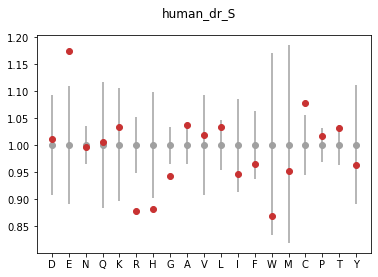

E 8.730616266197455e-06
R 2.892166883128527e-13
H 0.0018802453602447355
G 1.7198339705152358e-06
A 0.016396866918254756
C 0.00013917287833177435
{'D': 12.88239487140754, 'E': 8.730616266197455e-06, 'N': 15.730482914336676, 'Q': 16.459817616125573, 'K': 5.622692887765779, 'R': 2.892166883128527e-13, 'H': 0.0018802453602447355, 'G': 1.7198339705152358e-06, 'A': 0.016396866918254756, 'V': 9.768008554913456, 'L': 0.39885342382073924, 'I': 0.8700900099919555, 'F': 1.3388984772908548, 'W': 0.23786326857388504, 'M': 7.733387602511986, 'C': 0.00013917287833177435, 'P': 1.7644817842718683, 'T': 0.07984742576565361, 'Y': 5.371755950660807}
T	D	244	37773	3237	406201	0.00646	0.007969	0.8106	0.033454701829150606
T	E	369	37773	4736	406201	0.009769	0.011659	0.837865	0.023042748360789008
T	N	1474	37773	16177	406201	0.039023	0.039825	0.979849	8.955869762086552
T	Q	264	37773	3112	406201	0.006989	0.007661	0.912271	3.0866383490611784
T	K	879	37773	10892	406201	0.023271	0.026814	0.867842	0.0012969210779570

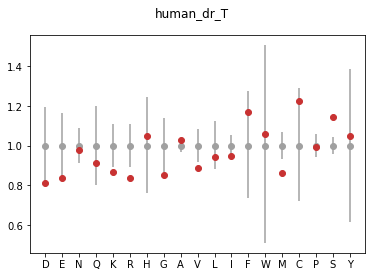

D 0.033454701829150606
E 0.023042748360789008
K 0.0012969210779570927
R 2.1100705648177848e-05
G 0.006269182166853449
V 0.0001803912550544213
M 4.072975891488847e-09
S 1.2160322355776027e-22
{'D': 0.033454701829150606, 'E': 0.023042748360789008, 'N': 8.955869762086552, 'Q': 3.0866383490611784, 'K': 0.0012969210779570927, 'R': 2.1100705648177848e-05, 'H': 10.269883224486502, 'G': 0.006269182166853449, 'A': 0.13894248806893097, 'V': 0.0001803912550544213, 'L': 2.5284505765491874, 'I': 0.05716908716573383, 'F': 1.0051466144179708, 'W': 14.22661568466886, 'M': 4.072975891488847e-09, 'C': 0.25244486400596944, 'P': 13.856778163098625, 'S': 1.2160322355776027e-22, 'Y': 13.956672356077368}
Y	D	293	6991	2520	52687	0.041911	0.04783	0.876256	0.7352088418423233
Y	E	89	6991	514	52687	0.012731	0.009756	1.304942	0.46784228013723383
Y	N	275	6991	2331	52687	0.039336	0.044242	0.889108	1.434030713814907
Y	Q	103	6991	802	52687	0.014733	0.015222	0.967892	15.139965296013722
Y	K	57	6991	381	52687	0.008153	0.

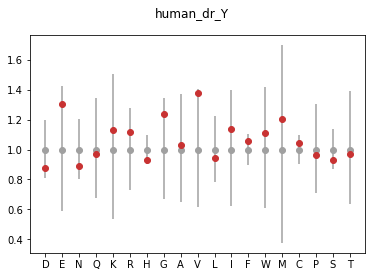

{'D': 0.7352088418423233, 'E': 0.46784228013723383, 'N': 1.434030713814907, 'Q': 15.139965296013722, 'K': 8.412384537403629, 'R': 3.7738274730589327, 'H': 0.2842705584128764, 'G': 0.4985689080798046, 'A': 15.477591821868824, 'V': 0.05694670257000868, 'L': 8.42118259299244, 'I': 5.488637814554001, 'F': 1.86167416426083, 'W': 7.975096194730592, 'M': 7.198080176452054, 'C': 3.3284640264287635, 'P': 13.639903414558475, 'S': 1.9490690771308252, 'T': 16.085625850005265}
S	D	616	35749	10702	656063	0.017231	0.016312	1.056325	3.7438735958302845
S	E	525	35749	7829	656063	0.014686	0.011933	1.23065	0.00010009536487527131
S	N	4453	35749	85830	656063	0.124563	0.130826	0.952128	0.05101061977977743
S	Q	388	35749	6848	656063	0.010853	0.010438	1.0398	8.991645923952635
S	K	504	35749	8555	656063	0.014098	0.01304	1.081165	1.813733521989189
S	R	1686	35749	36652	656063	0.047162	0.055867	0.844193	5.969068353148899e-10
S	H	491	35749	9657	656063	0.013735	0.01472	0.933084	2.717609716467413
S	G	4590	35749	89481	6

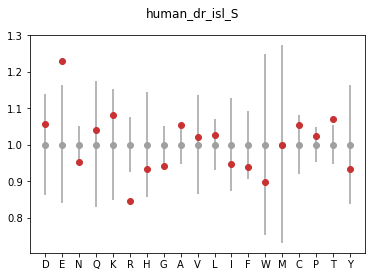

E 0.00010009536487527131
R 5.969068353148899e-10
G 0.0033622158208304127
A 0.0233834454453491
T 0.0008463281858636423
{'D': 3.7438735958302845, 'E': 0.00010009536487527131, 'N': 0.05101061977977743, 'Q': 8.991645923952635, 'K': 1.813733521989189, 'R': 5.969068353148899e-10, 'H': 2.717609716467413, 'G': 0.0033622158208304127, 'A': 0.0233834454453491, 'V': 11.888786954210804, 'L': 4.303898626395657, 'I': 3.3669297246253316, 'F': 0.7393878597723085, 'W': 3.8738116862844856, 'M': 18.66138834934658, 'C': 0.6526896232073904, 'P': 1.9352512513614897, 'T': 0.0008463281858636423, 'Y': 3.8748425599342746}
T	D	117	18232	3364	425742	0.006417	0.007901	0.812161	0.5755035936104522
T	E	156	18232	4949	425742	0.008556	0.011624	0.73607	0.0036193795536188637
T	N	706	18232	16945	425742	0.038723	0.039801	0.972916	9.409104665109817
T	Q	133	18232	3243	425742	0.007295	0.007617	0.957672	12.48954485011682
T	K	412	18232	11359	425742	0.022598	0.02668	0.846972	0.02155932573732333
T	R	377	18232	10874	425742	0.020678

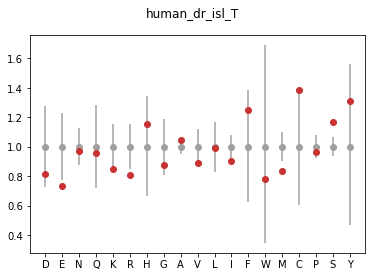

E 0.0036193795536188637
K 0.02155932573732333
R 0.0013433326079695777
V 0.045277407909033195
I 0.0005650178729137807
M 7.507063049121799e-07
S 1.1537796583396534e-16
{'D': 0.5755035936104522, 'E': 0.0036193795536188637, 'N': 9.409104665109817, 'Q': 12.48954485011682, 'K': 0.02155932573732333, 'R': 0.0013433326079695777, 'H': 2.8658812586746, 'G': 0.8149772525378352, 'A': 0.11038570138473071, 'V': 0.045277407909033195, 'L': 17.475366536729446, 'I': 0.0005650178729137807, 'F': 0.7505166021967908, 'W': 6.6633760395738655, 'M': 7.507063049121799e-07, 'C': 0.05237429348240693, 'P': 2.3677648998460765, 'S': 1.1537796583396534e-16, 'Y': 1.4887743583728907}
Y	D	119	2960	2694	56718	0.040203	0.047498	0.846406	1.6841643265678
Y	E	32	2960	571	56718	0.010811	0.010067	1.073849	14.577827244356111
Y	N	118	2960	2488	56718	0.039865	0.043866	0.908784	6.503309681287708
Y	Q	50	2960	855	56718	0.016892	0.015075	1.120555	9.20449562388487
Y	K	25	2960	413	56718	0.008446	0.007282	1.159896	10.327507240432963
Y	R	

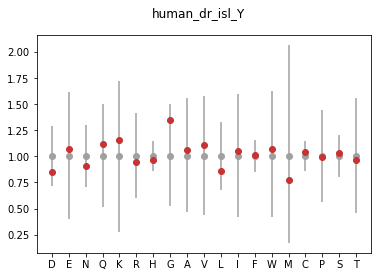

{'D': 1.6841643265678, 'E': 14.577827244356111, 'N': 6.503309681287708, 'Q': 9.20449562388487, 'K': 10.327507240432963, 'R': 13.099011342375112, 'H': 8.562156385648972, 'G': 0.5367223961288371, 'A': 14.580632696685104, 'V': 11.159057893875497, 'L': 3.5943228886250584, 'I': 15.77393248302662, 'F': 15.32143980942722, 'W': 14.627171470827328, 'M': 10.351793694613656, 'C': 7.786468195139603, 'P': 18.43504407636415, 'S': 12.04468119618297, 'T': 17.155442827487818}
S	D	783	48842	10535	642970	0.016031	0.016385	0.978418	10.858276511373795
S	E	649	48842	7705	642970	0.013288	0.011983	1.108841	0.2421409217354351
S	N	6563	48842	83720	642970	0.134372	0.130208	1.031978	0.4084886620265168
S	Q	502	48842	6734	642970	0.010278	0.010473	0.981359	13.352747902481722
S	K	637	48842	8422	642970	0.013042	0.013099	0.995684	17.728982546682538
S	R	2496	48842	35842	642970	0.051104	0.055744	0.916747	0.0008338705056287809
S	H	620	48842	9528	642970	0.012694	0.014819	0.856618	0.004187468122460386
S	G	6341	48842	87730	6

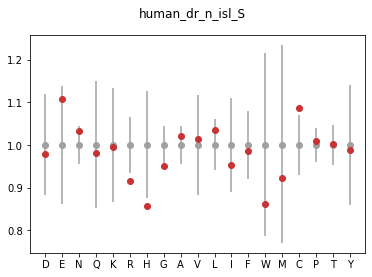

R 0.0008338705056287809
H 0.004187468122460386
G 0.006285064873338266
C 0.0018720291865115006
{'D': 10.858276511373795, 'E': 0.2421409217354351, 'N': 0.4084886620265168, 'Q': 13.352747902481722, 'K': 17.728982546682538, 'R': 0.0008338705056287809, 'H': 0.004187468122460386, 'G': 0.006285064873338266, 'A': 2.746567290473475, 'V': 13.16832451762636, 'L': 1.0981475960702032, 'I': 3.23639447721793, 'F': 11.498743218660069, 'W': 0.7445901089300776, 'M': 5.638616739243371, 'C': 0.0018720291865115006, 'P': 8.860400745837037, 'T': 17.201696996159324, 'Y': 15.187720240480875}
T	D	127	19541	3354	424433	0.006499	0.007902	0.822438	0.6504715687259645
T	E	213	19541	4892	424433	0.0109	0.011526	0.945705	8.508962763116312
T	N	768	19541	16883	424433	0.039302	0.039778	0.988039	14.501912665577498
T	Q	131	19541	3245	424433	0.006704	0.007645	0.876837	2.9079781170127204
T	K	467	19541	11304	424433	0.023898	0.026633	0.897319	0.46979524330819333
T	R	434	19541	10817	424433	0.02221	0.025486	0.871456	0.11031425493

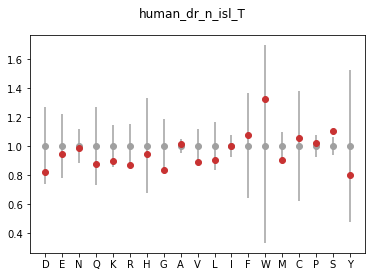

V 0.04105184534612149
M 0.01754578254122409
S 1.7293034192403574e-06
{'D': 0.6504715687259645, 'E': 8.508962763116312, 'N': 14.501912665577498, 'Q': 2.9079781170127204, 'K': 0.46979524330819333, 'R': 0.11031425493954632, 'H': 11.624929792674788, 'G': 0.07169155660314615, 'A': 6.318519535339082, 'V': 0.04105184534612149, 'L': 1.0403238556205339, 'I': 18.912647295540427, 'F': 10.626342179390761, 'W': 2.839974074766036, 'M': 0.01754578254122409, 'C': 12.936498445731232, 'P': 6.032230805343903, 'S': 1.7293034192403574e-06, 'Y': 4.665896183371415}
Y	D	174	4031	2639	55647	0.043165	0.047424	0.910204	4.8415828952046835
Y	E	57	4031	546	55647	0.01414	0.009812	1.441157	0.21027738905227736
Y	N	157	4031	2449	55647	0.038948	0.04401	0.884993	2.975086820498461
Y	Q	53	4031	852	55647	0.013148	0.015311	0.858747	6.00287199723948
Y	K	32	4031	406	55647	0.007938	0.007296	1.08806	13.62314257608959
Y	R	112	4031	1254	55647	0.027785	0.022535	1.232961	0.7774120314109715
Y	H	788	4031	12014	55647	0.195485	0.215897	

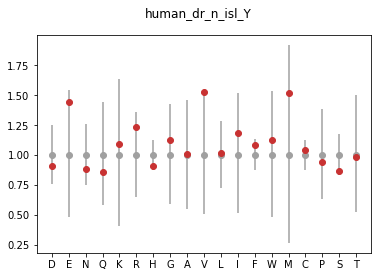

V 0.02152888045163966
{'D': 4.8415828952046835, 'E': 0.21027738905227736, 'N': 2.975086820498461, 'Q': 6.00287199723948, 'K': 13.62314257608959, 'R': 0.7774120314109715, 'H': 0.27129646137239444, 'G': 7.163085465823141, 'A': 18.58687378281004, 'V': 0.02152888045163966, 'L': 17.36983883795443, 'I': 5.188586459772779, 'F': 1.1305785574458431, 'W': 9.187878868687926, 'M': 1.2406956183271294, 'C': 5.987350352174278, 'P': 12.586035740620748, 'S': 0.21061146197240088, 'T': 17.982934576135392}
S	D	180	13051	5930	338178	0.013792	0.017535	0.786537	0.03375945151503417
S	E	129	13051	4166	338178	0.009884	0.012319	0.802365	0.2988152167029924
S	N	2078	13051	46381	338178	0.159222	0.13715	1.160933	1.2468974392840258e-08
S	Q	104	13051	3931	338178	0.007969	0.011624	0.685539	0.003156539302743206
S	K	174	13051	5481	338178	0.013332	0.016207	0.822604	0.2443325902155863
S	R	790	13051	21911	338178	0.060532	0.064791	0.934257	1.3488736793738463
S	H	195	13051	5740	338178	0.014941	0.016973	0.880287	1.677145627042

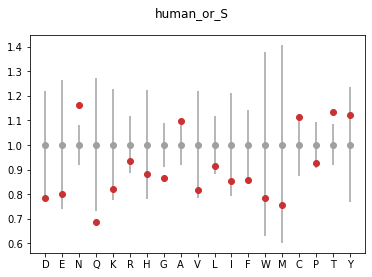

D 0.03375945151503417
N 1.2468974392840258e-08
Q 0.003156539302743206
G 2.51869740182628e-05
A 0.002465023155883372
F 0.029542134220523996
T 9.384505619917881e-06
{'D': 0.03375945151503417, 'E': 0.2988152167029924, 'N': 1.2468974392840258e-08, 'Q': 0.003156539302743206, 'K': 0.2443325902155863, 'R': 1.3488736793738463, 'H': 1.6771456270427016, 'G': 2.51869740182628e-05, 'A': 0.002465023155883372, 'V': 0.1276121117816458, 'L': 0.3424527991048823, 'I': 0.5041409849210311, 'F': 0.029542134220523996, 'W': 1.3931131331434157, 'M': 1.1875781642563494, 'C': 0.07218070103769089, 'P': 0.22392378082345055, 'T': 9.384505619917881e-06, 'Y': 2.0473231503029083}
T	D	97	9819	2557	295279	0.009879	0.00866	1.140792	4.278312027791644
T	E	93	9819	3645	295279	0.009471	0.012344	0.767274	0.2557018157381012
T	N	403	9819	12875	295279	0.041043	0.043603	0.941289	4.774489436255879
T	Q	92	9819	2598	295279	0.00937	0.008798	1.064913	11.255937240538767
T	K	357	9819	9918	295279	0.036358	0.033589	1.082454	2.97422103558

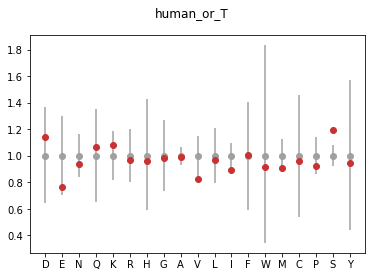

V 0.002538577242038463
I 0.012387200374797517
S 2.440631635648339e-13
{'D': 4.278312027791644, 'E': 0.2557018157381012, 'N': 4.774489436255879, 'Q': 11.255937240538767, 'K': 2.9742210355854084, 'R': 11.294108258252523, 'H': 15.34145957730481, 'G': 16.28207268180532, 'A': 13.657888013650966, 'V': 0.002538577242038463, 'L': 12.116030992380107, 'I': 0.012387200374797517, 'F': 18.763614549836234, 'W': 17.14883247287515, 'M': 0.4212086129554697, 'C': 16.013271676012042, 'P': 1.513218698887684, 'S': 2.440631635648339e-13, 'Y': 15.665250900337554}
Y	D	152	6190	2684	90567	0.024556	0.029636	0.828591	0.5393199880225048
Y	E	69	6190	774	90567	0.011147	0.008546	1.30433	0.787912110624061
Y	N	213	6190	3351	90567	0.03441	0.037	0.930003	6.2618925961969865
Y	Q	79	6190	1352	90567	0.012763	0.014928	0.854928	3.728295797891812
Y	K	62	6190	775	90567	0.010016	0.008557	1.170494	5.013876318878255
Y	R	147	6190	2042	90567	0.023748	0.022547	1.053273	10.977622028447504
Y	H	1439	6190	22199	90567	0.232472	0.245111	0.

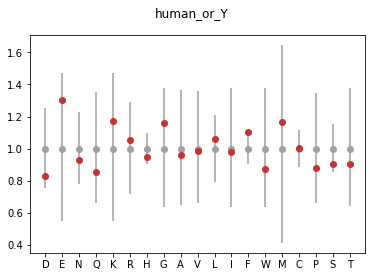

F 0.010193288563611796
{'D': 0.5393199880225048, 'E': 0.787912110624061, 'N': 6.2618925961969865, 'Q': 3.728295797891812, 'K': 5.013876318878255, 'R': 10.977622028447504, 'H': 1.5623462255451748, 'G': 3.499351601705988, 'A': 14.390614800962522, 'V': 18.13853892901599, 'L': 6.99088686275335, 'I': 17.31359559519828, 'F': 0.010193288563611796, 'W': 5.482973502343115, 'M': 8.495008102876286, 'C': 17.197240648189453, 'P': 4.86222111273835, 'S': 0.7159714180428352, 'T': 8.349036901113248}
S	D	1399	84591	9919	607221	0.016538	0.016335	1.012447	12.88239487140754
S	E	1174	84591	7180	607221	0.013879	0.011824	1.173725	8.730616266197455e-06
S	N	11016	84591	79267	607221	0.130227	0.130541	0.997595	15.730482914336676
S	Q	890	84591	6346	607221	0.010521	0.010451	1.006729	16.459817616125573
S	K	1141	84591	7918	607221	0.013488	0.01304	1.03441	5.622692887765779
S	R	4182	84591	34156	607221	0.049438	0.05625	0.8789	2.892166883128527e-13
S	H	1111	84591	9037	607221	0.013134	0.014883	0.882495	0.00188024536024473

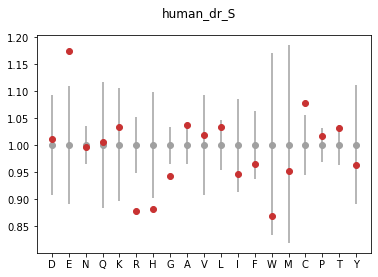

E 8.730616266197455e-06
R 2.892166883128527e-13
H 0.0018802453602447355
G 1.7198339705152358e-06
A 0.016396866918254756
C 0.00013917287833177435
{'D': 12.88239487140754, 'E': 8.730616266197455e-06, 'N': 15.730482914336676, 'Q': 16.459817616125573, 'K': 5.622692887765779, 'R': 2.892166883128527e-13, 'H': 0.0018802453602447355, 'G': 1.7198339705152358e-06, 'A': 0.016396866918254756, 'V': 9.768008554913456, 'L': 0.39885342382073924, 'I': 0.8700900099919555, 'F': 1.3388984772908548, 'W': 0.23786326857388504, 'M': 7.733387602511986, 'C': 0.00013917287833177435, 'P': 1.7644817842718683, 'T': 0.07984742576565361, 'Y': 5.371755950660807}
T	D	244	37773	3237	406201	0.00646	0.007969	0.8106	0.033454701829150606
T	E	369	37773	4736	406201	0.009769	0.011659	0.837865	0.023042748360789008
T	N	1474	37773	16177	406201	0.039023	0.039825	0.979849	8.955869762086552
T	Q	264	37773	3112	406201	0.006989	0.007661	0.912271	3.0866383490611784
T	K	879	37773	10892	406201	0.023271	0.026814	0.867842	0.0012969210779570

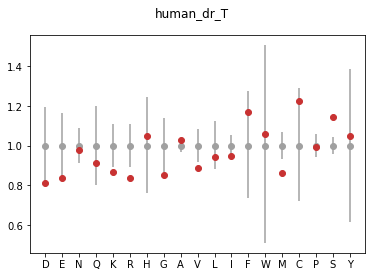

D 0.033454701829150606
E 0.023042748360789008
K 0.0012969210779570927
R 2.1100705648177848e-05
G 0.006269182166853449
V 0.0001803912550544213
M 4.072975891488847e-09
S 1.2160322355776027e-22
{'D': 0.033454701829150606, 'E': 0.023042748360789008, 'N': 8.955869762086552, 'Q': 3.0866383490611784, 'K': 0.0012969210779570927, 'R': 2.1100705648177848e-05, 'H': 10.269883224486502, 'G': 0.006269182166853449, 'A': 0.13894248806893097, 'V': 0.0001803912550544213, 'L': 2.5284505765491874, 'I': 0.05716908716573383, 'F': 1.0051466144179708, 'W': 14.22661568466886, 'M': 4.072975891488847e-09, 'C': 0.25244486400596944, 'P': 13.856778163098625, 'S': 1.2160322355776027e-22, 'Y': 13.956672356077368}
Y	D	293	6991	2520	52687	0.041911	0.04783	0.876256	0.7352088418423233
Y	E	89	6991	514	52687	0.012731	0.009756	1.304942	0.46784228013723383
Y	N	275	6991	2331	52687	0.039336	0.044242	0.889108	1.434030713814907
Y	Q	103	6991	802	52687	0.014733	0.015222	0.967892	15.139965296013722
Y	K	57	6991	381	52687	0.008153	0.

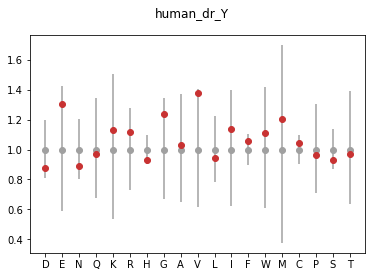

{'D': 0.7352088418423233, 'E': 0.46784228013723383, 'N': 1.434030713814907, 'Q': 15.139965296013722, 'K': 8.412384537403629, 'R': 3.7738274730589327, 'H': 0.2842705584128764, 'G': 0.4985689080798046, 'A': 15.477591821868824, 'V': 0.05694670257000868, 'L': 8.42118259299244, 'I': 5.488637814554001, 'F': 1.86167416426083, 'W': 7.975096194730592, 'M': 7.198080176452054, 'C': 3.3284640264287635, 'P': 13.639903414558475, 'S': 1.9490690771308252, 'T': 16.085625850005265}
S	D	1399	84591	9919	607221	0.016538	0.016335	1.012447	12.88239487140754
S	E	1174	84591	7180	607221	0.013879	0.011824	1.173725	8.730616266197455e-06
S	N	11016	84591	79267	607221	0.130227	0.130541	0.997595	15.730482914336676
S	Q	890	84591	6346	607221	0.010521	0.010451	1.006729	16.459817616125573
S	K	1141	84591	7918	607221	0.013488	0.01304	1.03441	5.622692887765779
S	R	4182	84591	34156	607221	0.049438	0.05625	0.8789	2.892166883128527e-13
S	H	1111	84591	9037	607221	0.013134	0.014883	0.882495	0.0018802453602447355
S	G	10931	84591	

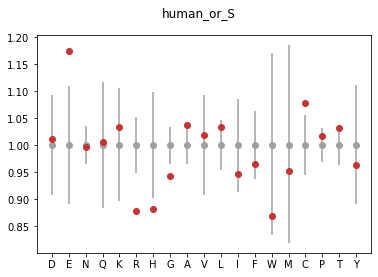

E 8.730616266197455e-06
R 2.892166883128527e-13
H 0.0018802453602447355
G 1.7198339705152358e-06
A 0.016396866918254756
C 0.00013917287833177435
{'D': 12.88239487140754, 'E': 8.730616266197455e-06, 'N': 15.730482914336676, 'Q': 16.459817616125573, 'K': 5.622692887765779, 'R': 2.892166883128527e-13, 'H': 0.0018802453602447355, 'G': 1.7198339705152358e-06, 'A': 0.016396866918254756, 'V': 9.768008554913456, 'L': 0.39885342382073924, 'I': 0.8700900099919555, 'F': 1.3388984772908548, 'W': 0.23786326857388504, 'M': 7.733387602511986, 'C': 0.00013917287833177435, 'P': 1.7644817842718683, 'T': 0.07984742576565361, 'Y': 5.371755950660807}
T	D	244	37773	3237	406201	0.00646	0.007969	0.8106	0.033454701829150606
T	E	369	37773	4736	406201	0.009769	0.011659	0.837865	0.023042748360789008
T	N	1474	37773	16177	406201	0.039023	0.039825	0.979849	8.955869762086552
T	Q	264	37773	3112	406201	0.006989	0.007661	0.912271	3.0866383490611784
T	K	879	37773	10892	406201	0.023271	0.026814	0.867842	0.0012969210779570

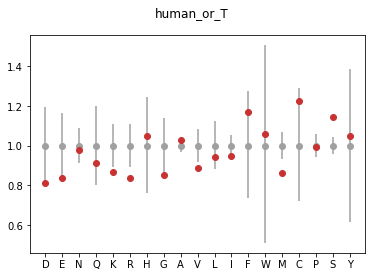

D 0.033454701829150606
E 0.023042748360789008
K 0.0012969210779570927
R 2.1100705648177848e-05
G 0.006269182166853449
V 0.0001803912550544213
M 4.072975891488847e-09
S 1.2160322355776027e-22
{'D': 0.033454701829150606, 'E': 0.023042748360789008, 'N': 8.955869762086552, 'Q': 3.0866383490611784, 'K': 0.0012969210779570927, 'R': 2.1100705648177848e-05, 'H': 10.269883224486502, 'G': 0.006269182166853449, 'A': 0.13894248806893097, 'V': 0.0001803912550544213, 'L': 2.5284505765491874, 'I': 0.05716908716573383, 'F': 1.0051466144179708, 'W': 14.22661568466886, 'M': 4.072975891488847e-09, 'C': 0.25244486400596944, 'P': 13.856778163098625, 'S': 1.2160322355776027e-22, 'Y': 13.956672356077368}
Y	D	293	6991	2520	52687	0.041911	0.04783	0.876256	0.7352088418423233
Y	E	89	6991	514	52687	0.012731	0.009756	1.304942	0.46784228013723383
Y	N	275	6991	2331	52687	0.039336	0.044242	0.889108	1.434030713814907
Y	Q	103	6991	802	52687	0.014733	0.015222	0.967892	15.139965296013722
Y	K	57	6991	381	52687	0.008153	0.

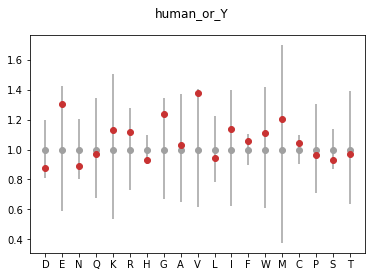

{'D': 0.7352088418423233, 'E': 0.46784228013723383, 'N': 1.434030713814907, 'Q': 15.139965296013722, 'K': 8.412384537403629, 'R': 3.7738274730589327, 'H': 0.2842705584128764, 'G': 0.4985689080798046, 'A': 15.477591821868824, 'V': 0.05694670257000868, 'L': 8.42118259299244, 'I': 5.488637814554001, 'F': 1.86167416426083, 'W': 7.975096194730592, 'M': 7.198080176452054, 'C': 3.3284640264287635, 'P': 13.639903414558475, 'S': 1.9490690771308252, 'T': 16.085625850005265}


In [3]:
def mutdict_transpose(mutdict):
    mutdict_t = dict()
    for aa1 in mutdict.keys():
        if aa1 in ('S', 'T', 'Y', 'pS', 'pT', 'pY'):
            continue
        for aa2 in mutdict[aa1].keys():
#            if aa2 in ('S', 'T', 'Y', 'pS', 'pT', 'pY'):
#                continue
            if mutdict_t.get(aa2):
                mutdict_t[aa2][aa1] = mutdict[aa1][aa2]
            else:
                mutdict_t[aa2] = dict()
                mutdict_t[aa2][aa1] = mutdict[aa1][aa2]
    return mutdict_t

hmr_cons_dr = {'mutdict': {'pS': {'A': 1863, 'C': 714, 'E': 305, 'G': 1879, 'pT': 1843, 'F': 528, 'I': 287, 'H': 212, 'K': 253, 'pY': 195, 'M': 94, 'L': 1092, 'N': 1733, 'Q': 212, 'P': 2174, 'R': 702, 'W': 76, 'V': 288, 'D': 303}, 'pT': {'A': 1334, 'pS': 1073, 'C': 23, 'E': 49, 'D': 43, 'G': 73, 'F': 23, 'I': 370, 'H': 30, 'K': 95, 'pY': 8, 'M': 229, 'L': 114, 'N': 150, 'Q': 37, 'P': 430, 'R': 83, 'W': 11, 'V': 157}, 'pY': {'A': 14, 'pS': 79, 'C': 130, 'G': 16, 'E': 15, 'D': 31, 'pT': 12, 'F': 140, 'I': 19, 'H': 130, 'K': 6, 'M': 4, 'L': 27, 'N': 16, 'Q': 12, 'P': 15, 'R': 32, 'W': 11, 'V': 12}, 'A': {'pS': 203, 'pT': 371, 'pY': 3, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73390, 'R': 10194, 'T': 178760, 'W': 1024, 'V': 124760, 'Y': 1047}, 'C': {'pS': 59, 'pT': 1, 'pY': 37, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15004, 'R': 10364, 'T': 939, 'W': 2285, 'V': 1254, 'Y': 12669}, 'E': {'pS': 43, 'pT': 7, 'pY': 2, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11631, 'R': 13283, 'T': 8320, 'W': 1102, 'V': 15876, 'Y': 1315}, 'D': {'pS': 28, 'pT': 10, 'pY': 4, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13120, 'R': 3846, 'T': 4814, 'W': 331, 'V': 7717, 'Y': 4751}, 'G': {'A': 61219, 'pS': 243, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 8, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91787, 'R': 58908, 'T': 8501, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'pS': 13, 'pT': 3, 'pY': 16, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13381, 'R': 996, 'T': 1091, 'W': 880, 'V': 7343, 'Y': 7884}, 'I': {'pS': 18, 'pT': 59, 'pY': 2, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8025, 'R': 3082, 'T': 33004, 'W': 205, 'V': 75199, 'Y': 558}, 'H': {'pS': 15, 'pT': 2, 'pY': 8, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6859, 'R': 37184, 'T': 1946, 'W': 468, 'V': 1099, 'Y': 20594}, 'K': {'pS': 9, 'pT': 20, 'pY': 5, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11199, 'R': 110511, 'T': 25233, 'W': 709, 'V': 3672, 'Y': 908}, 'M': {'pS': 3, 'pT': 40, 'pY': 1, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2186, 'R': 5161, 'T': 23355, 'W': 399, 'V': 38528, 'Y': 255}, 'L': {'A': 10556, 'pS': 70, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 7, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30579, 'R': 16288, 'T': 6419, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 279, 'pT': 60, 'pY': 10, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106719, 'R': 5851, 'T': 24750, 'W': 244, 'V': 2008, 'Y': 4004}, 'Q': {'A': 7068, 'pS': 27, 'pT': 6, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'C': 1383, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9207, 'R': 62056, 'T': 4354, 'W': 4430, 'V': 3055, 'Y': 1781, 'I': 1302}, 'P': {'pS': 362, 'pT': 84, 'pY': 1, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 159845, 'R': 25221, 'T': 43676, 'W': 1336, 'V': 8798, 'Y': 1473}, 'S': {'A': 85952, 'C': 32230, 'E': 8049, 'D': 11015, 'G': 92192, 'F': 24555, 'I': 12874, 'H': 9936, 'K': 8806, 'M': 2794, 'L': 45884, 'N': 88550, 'Q': 7024, 'P': 108203, 'R': 37636, 'T': 78841, 'W': 3329, 'V': 11376, 'Y': 7813}, 'R': {'pS': 29, 'pT': 18, 'pY': 1, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25960, 'T': 12567, 'W': 13299, 'V': 3585, 'Y': 1473}, 'T': {'A': 143396, 'C': 1659, 'E': 5056, 'D': 3438, 'G': 7235, 'F': 1825, 'I': 48212, 'H': 2323, 'K': 11676, 'M': 28753, 'L': 9175, 'N': 17501, 'Q': 3339, 'P': 45448, 'S': 78564, 'R': 11168, 'W': 546, 'V': 19435, 'Y': 893}, 'W': {'A': 415, 'pS': 3, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'pT': 1, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1556, 'R': 5931, 'T': 292, 'V': 370, 'Y': 424}, 'V': {'pS': 27, 'pT': 21, 'pY': 2, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7798, 'R': 3688, 'T': 16027, 'W': 783, 'Y': 671}, 'Y': {'A': 766, 'C': 12732, 'E': 588, 'D': 2782, 'G': 926, 'F': 11075, 'I': 652, 'H': 12672, 'K': 432, 'M': 228, 'L': 2108, 'N': 2590, 'Q': 893, 'P': 1159, 'S': 6029, 'R': 1334, 'T': 698, 'W': 612, 'V': 681}}, 'sitenumdict': {'pS': 33692, 'pT': 7017, 'pY': 2743, 'A': 366801, 'C': 82495, 'E': 480569, 'D': 256682, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127186, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 538903, 'R': 326277, 'T': 272480, 'W': 29170, 'V': 203821, 'Y': 71651}}
hmr_cons_dr_isl = {'mutdict': {'pS': {'A': 893, 'C': 328, 'E': 180, 'G': 926, 'pT': 925, 'F': 238, 'I': 151, 'H': 102, 'K': 128, 'pY': 80, 'M': 48, 'L': 548, 'N': 835, 'Q': 118, 'P': 1005, 'R': 340, 'W': 38, 'V': 144, 'D': 168}, 'pT': {'A': 822, 'pS': 650, 'C': 12, 'E': 25, 'D': 25, 'G': 39, 'F': 12, 'I': 177, 'H': 18, 'K': 60, 'pY': 6, 'M': 124, 'L': 60, 'N': 86, 'Q': 26, 'P': 287, 'R': 47, 'W': 3, 'V': 95}, 'pY': {'A': 7, 'pS': 37, 'C': 68, 'E': 6, 'D': 15, 'pT': 4, 'F': 70, 'I': 6, 'H': 64, 'K': 5, 'M': 1, 'L': 13, 'N': 8, 'G': 7, 'P': 7, 'R': 9, 'Q': 9, 'W': 7, 'V': 3}, 'A': {'pS': 112, 'pT': 231, 'pY': 3, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73481, 'R': 10194, 'T': 178900, 'W': 1024, 'V': 124760, 'Y': 1047}, 'C': {'pS': 28, 'pT': 1, 'pY': 17, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15035, 'R': 10364, 'T': 939, 'W': 2285, 'V': 1254, 'Y': 12689}, 'E': {'A': 38421, 'pS': 24, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'pT': 3, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11650, 'R': 13283, 'T': 8324, 'W': 1102, 'V': 15876, 'Y': 1317}, 'D': {'pS': 21, 'pT': 5, 'pY': 2, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13127, 'R': 3846, 'T': 4819, 'W': 331, 'V': 7717, 'Y': 4753}, 'G': {'A': 61219, 'pS': 100, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 6, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91930, 'R': 58908, 'T': 8503, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'A': 1812, 'pS': 4, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'pY': 6, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13390, 'R': 996, 'T': 1094, 'W': 880, 'V': 7343, 'Y': 7894}, 'I': {'pS': 7, 'pT': 27, 'pY': 1, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8036, 'R': 3082, 'T': 33036, 'W': 205, 'V': 75199, 'Y': 559}, 'H': {'pS': 13, 'pT': 2, 'pY': 3, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6861, 'R': 37184, 'T': 1946, 'W': 468, 'V': 1099, 'Y': 20599}, 'K': {'pS': 2, 'pT': 13, 'pY': 4, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11206, 'R': 110511, 'T': 25240, 'W': 709, 'V': 3672, 'Y': 909}, 'M': {'pS': 1, 'pT': 24, 'pY': 1, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2188, 'R': 5161, 'T': 23371, 'W': 399, 'V': 38528, 'Y': 255}, 'L': {'A': 10556, 'pS': 38, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 3, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30611, 'R': 16288, 'T': 6423, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 151, 'pT': 30, 'pY': 5, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106847, 'R': 5851, 'T': 24780, 'W': 244, 'V': 2008, 'Y': 4009}, 'Q': {'A': 7068, 'pS': 18, 'pT': 3, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'C': 1383, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9216, 'R': 62056, 'T': 4357, 'W': 4430, 'V': 3055, 'Y': 1781, 'I': 1302}, 'P': {'pS': 181, 'pT': 54, 'pY': 1, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 160026, 'R': 25221, 'T': 43706, 'W': 1336, 'V': 8798, 'Y': 1473}, 'S': {'A': 86922, 'C': 32616, 'E': 8174, 'D': 11150, 'G': 93145, 'F': 24845, 'I': 13010, 'H': 10046, 'K': 8931, 'M': 2840, 'L': 46428, 'N': 89448, 'Q': 7118, 'P': 109372, 'R': 37998, 'T': 79759, 'W': 3367, 'V': 11520, 'Y': 7928}, 'R': {'A': 8105, 'pS': 8, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'pT': 4, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25981, 'T': 12581, 'W': 13299, 'V': 3585, 'Y': 1474}, 'T': {'A': 143908, 'C': 1670, 'E': 5080, 'D': 3456, 'G': 7269, 'F': 1836, 'I': 48405, 'H': 2335, 'K': 11711, 'M': 28858, 'L': 9229, 'N': 17565, 'Q': 3350, 'P': 45591, 'S': 78987, 'R': 11204, 'W': 554, 'V': 19497, 'Y': 895}, 'W': {'A': 415, 'pS': 1, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'pT': 1, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1558, 'R': 5931, 'T': 292, 'V': 370, 'Y': 424}, 'V': {'A': 82502, 'pS': 16, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'pT': 12, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7809, 'R': 3688, 'T': 16036, 'W': 783, 'Y': 673}, 'Y': {'A': 773, 'C': 12794, 'E': 597, 'D': 2798, 'G': 935, 'F': 11145, 'I': 665, 'H': 12738, 'K': 433, 'M': 231, 'L': 2122, 'N': 2598, 'Q': 896, 'P': 1167, 'S': 6071, 'R': 1357, 'T': 706, 'W': 616, 'V': 690}}, 'sitenumdict': {'pS': 20376, 'pT': 4613, 'pY': 1494, 'A': 366801, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453150, 'S': 552219, 'R': 326277, 'T': 274884, 'W': 29170, 'V': 203822, 'Y': 72900}}
hmr_cons_dr_n_isl = {'mutdict': {'pS': {'A': 970, 'C': 386, 'E': 125, 'pT': 918, 'G': 953, 'F': 290, 'I': 136, 'H': 110, 'K': 125, 'pY': 115, 'M': 46, 'L': 544, 'N': 898, 'Q': 94, 'P': 1169, 'R': 362, 'W': 38, 'V': 144, 'D': 135}, 'pT': {'A': 512, 'pS': 423, 'C': 11, 'E': 24, 'D': 18, 'G': 34, 'F': 11, 'I': 193, 'H': 12, 'K': 35, 'pY': 2, 'M': 105, 'L': 54, 'N': 64, 'Q': 11, 'P': 143, 'R': 36, 'W': 8, 'V': 62}, 'pY': {'A': 7, 'pS': 42, 'C': 62, 'G': 9, 'E': 9, 'D': 16, 'pT': 8, 'F': 70, 'I': 13, 'H': 66, 'K': 1, 'M': 3, 'L': 14, 'N': 8, 'Q': 3, 'P': 8, 'R': 23, 'W': 4, 'V': 9}, 'A': {'pS': 91, 'pT': 140, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73502, 'R': 10194, 'T': 178991, 'W': 1024, 'V': 124760, 'Y': 1050, 'C': 3418}, 'C': {'A': 1895, 'pS': 31, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'pY': 20, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15032, 'R': 10364, 'T': 940, 'W': 2285, 'V': 1254, 'Y': 12686}, 'E': {'pS': 19, 'pT': 4, 'pY': 2, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11655, 'R': 13283, 'T': 8323, 'W': 1102, 'V': 15876, 'Y': 1315}, 'D': {'pS': 7, 'pT': 5, 'pY': 2, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13141, 'R': 3846, 'T': 4819, 'W': 331, 'V': 7717, 'Y': 4753}, 'G': {'A': 61219, 'pS': 143, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 2, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91887, 'R': 58908, 'T': 8507, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'pS': 9, 'pT': 3, 'pY': 10, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13385, 'R': 996, 'T': 1091, 'W': 880, 'V': 7343, 'Y': 7890}, 'I': {'pS': 11, 'pT': 32, 'pY': 1, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8032, 'R': 3082, 'T': 33031, 'W': 205, 'V': 75199, 'Y': 559}, 'H': {'A': 2328, 'pS': 2, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'pY': 5, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6872, 'R': 37184, 'T': 1948, 'W': 468, 'V': 1099, 'Y': 20597}, 'K': {'pS': 7, 'pT': 7, 'pY': 1, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11201, 'R': 110511, 'T': 25246, 'W': 709, 'V': 3672, 'Y': 912}, 'M': {'A': 5101, 'pS': 2, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'pT': 16, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2187, 'R': 5161, 'T': 23379, 'W': 399, 'V': 38528, 'Y': 256}, 'L': {'A': 10556, 'pS': 32, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 4, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30617, 'R': 16288, 'T': 6422, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 128, 'pT': 30, 'pY': 5, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106870, 'R': 5851, 'T': 24780, 'W': 244, 'V': 2008, 'Y': 4009}, 'Q': {'A': 7068, 'pS': 9, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'pT': 3, 'N': 2937, 'P': 57225, 'S': 9225, 'R': 62056, 'T': 4357, 'W': 4430, 'V': 3055, 'Y': 1781}, 'P': {'A': 77443, 'pS': 181, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'pT': 30, 'N': 2582, 'Q': 30345, 'S': 160026, 'R': 25221, 'T': 43730, 'W': 1336, 'V': 8798, 'Y': 1474}, 'S': {'A': 86845, 'C': 32558, 'E': 8229, 'D': 11183, 'G': 93118, 'F': 24793, 'I': 13025, 'H': 10038, 'K': 8934, 'M': 2842, 'L': 46432, 'N': 89385, 'Q': 7142, 'P': 109208, 'R': 37976, 'T': 79766, 'W': 3367, 'V': 11520, 'Y': 7893}, 'R': {'pS': 21, 'pT': 14, 'pY': 1, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25968, 'T': 12571, 'W': 13299, 'V': 3585, 'Y': 1473}, 'T': {'A': 144218, 'C': 1671, 'E': 5081, 'D': 3463, 'G': 7274, 'F': 1837, 'I': 48389, 'H': 2341, 'K': 11736, 'M': 28877, 'L': 9235, 'N': 17587, 'Q': 3365, 'P': 45735, 'S': 79214, 'R': 11215, 'W': 549, 'V': 19530, 'Y': 899}, 'W': {'A': 415, 'pS': 2, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1557, 'R': 5931, 'T': 293, 'V': 370, 'Y': 424}, 'V': {'pS': 11, 'pT': 9, 'pY': 2, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7814, 'R': 3688, 'T': 16039, 'W': 783, 'Y': 671}, 'Y': {'A': 773, 'C': 12800, 'E': 594, 'D': 2797, 'G': 933, 'F': 11145, 'I': 658, 'H': 12736, 'K': 437, 'M': 229, 'L': 2121, 'N': 2598, 'Q': 902, 'P': 1166, 'S': 6066, 'R': 1343, 'T': 702, 'W': 619, 'V': 684}}, 'sitenumdict': {'pS': 13316, 'pT': 2404, 'pY': 1249, 'A': 366802, 'C': 82495, 'E': 480569, 'D': 256682, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127186, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 559279, 'R': 326277, 'T': 277093, 'W': 29170, 'V': 203821, 'Y': 73145}}
hmr_cons_or = {'mutdict': {'pS': {'A': 202, 'C': 66, 'E': 14, 'pT': 195, 'G': 104, 'F': 46, 'I': 25, 'H': 17, 'K': 24, 'pY': 27, 'M': 8, 'L': 74, 'N': 171, 'Q': 12, 'P': 113, 'R': 58, 'W': 6, 'V': 23, 'D': 16}, 'pT': {'A': 95, 'pS': 126, 'C': 5, 'E': 6, 'D': 5, 'G': 10, 'F': 2, 'I': 53, 'H': 2, 'K': 7, 'pY': 1, 'M': 19, 'L': 13, 'N': 13, 'Q': 9, 'P': 22, 'R': 7, 'V': 26}, 'pY': {'A': 7, 'pS': 23, 'C': 67, 'G': 11, 'E': 5, 'D': 9, 'pT': 19, 'F': 109, 'I': 5, 'H': 79, 'K': 4, 'M': 2, 'L': 26, 'N': 15, 'Q': 5, 'P': 12, 'R': 8, 'W': 10, 'V': 13}, 'A': {'pS': 39, 'C': 2986, 'E': 15914, 'D': 11603, 'G': 30453, 'F': 2861, 'I': 7245, 'H': 1984, 'K': 3995, 'M': 4241, 'L': 10510, 'pT': 28, 'N': 3397, 'Q': 3630, 'P': 24496, 'S': 55045, 'R': 6614, 'T': 105374, 'W': 910, 'V': 79328, 'Y': 1065}, 'C': {'A': 2391, 'pS': 5, 'E': 539, 'D': 718, 'G': 7177, 'F': 5119, 'I': 955, 'H': 3776, 'K': 537, 'pY': 8, 'M': 430, 'L': 3196, 'N': 1001, 'Q': 825, 'P': 1504, 'S': 16273, 'R': 9398, 'T': 1337, 'W': 2594, 'V': 1847, 'Y': 12580}, 'E': {'A': 18541, 'pS': 2, 'C': 848, 'D': 59072, 'G': 24340, 'F': 1200, 'I': 1594, 'H': 2332, 'K': 35839, 'M': 1337, 'L': 3973, 'N': 4486, 'Q': 28783, 'P': 3912, 'S': 6147, 'R': 6679, 'T': 4619, 'W': 626, 'V': 7421, 'Y': 856}, 'D': {'pS': 4, 'pT': 2, 'pY': 2, 'A': 11304, 'C': 922, 'E': 52858, 'G': 23242, 'F': 1024, 'I': 1256, 'H': 8270, 'K': 3044, 'M': 552, 'L': 2209, 'N': 39559, 'Q': 2605, 'P': 2613, 'S': 8748, 'R': 2731, 'T': 3346, 'W': 256, 'V': 4192, 'Y': 3177}, 'G': {'A': 30731, 'pS': 21, 'C': 5345, 'E': 24007, 'D': 21580, 'pT': 2, 'F': 1320, 'I': 1627, 'H': 2440, 'K': 4368, 'M': 1046, 'L': 3720, 'N': 5542, 'Q': 3546, 'P': 4371, 'S': 46337, 'R': 28531, 'T': 4714, 'W': 2568, 'V': 9934, 'Y': 868}, 'F': {'A': 2622, 'pS': 2, 'C': 7058, 'E': 838, 'D': 627, 'G': 1412, 'I': 8758, 'H': 1673, 'K': 938, 'pY': 6, 'M': 1094, 'L': 52867, 'N': 717, 'Q': 867, 'P': 2299, 'S': 15076, 'R': 1607, 'T': 1812, 'W': 1661, 'V': 10793, 'Y': 16190}, 'I': {'A': 7048, 'C': 1137, 'E': 1411, 'D': 992, 'G': 1891, 'F': 9811, 'pT': 2, 'H': 1097, 'K': 2919, 'pY': 1, 'M': 27435, 'L': 51047, 'N': 3606, 'Q': 1060, 'P': 2236, 'S': 7468, 'R': 3195, 'T': 38118, 'W': 451, 'V': 160074, 'Y': 1146}, 'H': {'A': 1859, 'pS': 4, 'C': 5846, 'E': 1721, 'D': 4769, 'G': 2462, 'F': 2128, 'I': 853, 'K': 1795, 'pY': 6, 'M': 385, 'L': 8960, 'N': 11214, 'Q': 28382, 'P': 9665, 'S': 6089, 'R': 36117, 'T': 1816, 'W': 472, 'V': 1120, 'Y': 26488}, 'K': {'A': 4318, 'pS': 2, 'C': 713, 'E': 26135, 'D': 2475, 'G': 4269, 'F': 1170, 'I': 2982, 'H': 2201, 'M': 4333, 'L': 3724, 'N': 19843, 'Q': 27141, 'P': 3107, 'S': 7520, 'R': 80494, 'T': 16551, 'W': 565, 'V': 2527, 'Y': 781}, 'M': {'A': 4030, 'pS': 2, 'C': 498, 'E': 1090, 'D': 352, 'G': 1254, 'F': 1198, 'I': 21616, 'H': 426, 'K': 4133, 'L': 32759, 'pT': 4, 'N': 612, 'Q': 1152, 'P': 1206, 'S': 2114, 'R': 4128, 'T': 20996, 'W': 499, 'V': 33135, 'Y': 379}, 'L': {'A': 10069, 'pS': 4, 'C': 4350, 'E': 3420, 'D': 1636, 'G': 4827, 'F': 54833, 'I': 35337, 'H': 7150, 'K': 3766, 'M': 28640, 'N': 1852, 'Q': 14585, 'P': 28527, 'S': 23184, 'R': 14833, 'T': 6982, 'W': 6596, 'V': 61903, 'Y': 2969}, 'N': {'A': 3232, 'pS': 64, 'C': 1315, 'E': 3693, 'D': 34110, 'G': 7309, 'F': 978, 'I': 4176, 'H': 19771, 'K': 20180, 'M': 740, 'L': 2204, 'pT': 10, 'Q': 3145, 'P': 2162, 'S': 78611, 'R': 5340, 'T': 17551, 'W': 253, 'V': 1677, 'Y': 3694}, 'Q': {'A': 3817, 'C': 1198, 'E': 26726, 'D': 2250, 'G': 4438, 'F': 1121, 'I': 1136, 'H': 33048, 'K': 22817, 'M': 1165, 'L': 14703, 'pT': 1, 'N': 2649, 'P': 18979, 'S': 5679, 'R': 51612, 'T': 3048, 'W': 2973, 'V': 2207, 'Y': 1511}, 'P': {'A': 26051, 'pS': 23, 'C': 1691, 'E': 2848, 'D': 1689, 'G': 4199, 'F': 2468, 'I': 1783, 'H': 6958, 'K': 2369, 'M': 980, 'L': 34911, 'pT': 3, 'N': 1398, 'Q': 10510, 'S': 53128, 'R': 10940, 'T': 14375, 'W': 685, 'V': 3817, 'Y': 945}, 'S': {'A': 51295, 'C': 19590, 'E': 4281, 'D': 6094, 'G': 40680, 'F': 14630, 'I': 6767, 'H': 5918, 'K': 5631, 'M': 1719, 'L': 22272, 'N': 48288, 'Q': 4023, 'P': 35620, 'R': 22643, 'T': 46927, 'W': 2065, 'V': 6230, 'Y': 5355}, 'R': {'A': 5543, 'pS': 3, 'C': 12598, 'E': 4646, 'D': 1656, 'G': 22681, 'F': 1347, 'I': 2566, 'H': 30671, 'K': 54153, 'M': 2608, 'L': 11288, 'N': 3236, 'Q': 49008, 'P': 9101, 'S': 19055, 'T': 8943, 'W': 9589, 'V': 2831, 'Y': 1724}, 'T': {'A': 88745, 'C': 1545, 'E': 3732, 'D': 2649, 'G': 4610, 'F': 2037, 'I': 38253, 'H': 1937, 'K': 10268, 'M': 23262, 'L': 7595, 'N': 13265, 'Q': 2681, 'P': 17456, 'S': 61031, 'R': 8769, 'W': 541, 'V': 15316, 'Y': 985}, 'W': {'A': 738, 'C': 3997, 'E': 538, 'D': 214, 'G': 3383, 'F': 1455, 'I': 395, 'H': 448, 'K': 524, 'M': 385, 'L': 4508, 'N': 226, 'Q': 2086, 'P': 760, 'S': 2287, 'R': 7176, 'T': 500, 'V': 832, 'Y': 945}, 'V': {'pS': 1, 'pT': 1, 'pY': 4, 'A': 73097, 'C': 2372, 'E': 8649, 'D': 3707, 'G': 14073, 'F': 8800, 'I': 129889, 'H': 1190, 'K': 2804, 'M': 38773, 'L': 56535, 'N': 1563, 'Q': 2223, 'P': 4322, 'S': 7419, 'R': 3871, 'T': 15975, 'W': 1047, 'Y': 1174}, 'Y': {'A': 1342, 'C': 15525, 'E': 838, 'D': 2827, 'G': 1282, 'F': 23375, 'I': 1253, 'H': 23559, 'K': 833, 'M': 459, 'L': 4116, 'N': 3549, 'Q': 1426, 'P': 1511, 'S': 8288, 'R': 2181, 'T': 1268, 'W': 1286, 'V': 1410}}, 'sitenumdict': {'pS': 4042, 'pT': 1900, 'pY': 3242, 'A': 428760, 'C': 177350, 'E': 326054, 'D': 281268, 'G': 373431, 'F': 312221, 'I': 368585, 'H': 170462, 'K': 289969, 'M': 137247, 'L': 746090, 'N': 236240, 'Q': 254801, 'P': 262963, 'S': 367901, 'R': 313750, 'U': 37, 'T': 325842, 'W': 108268, 'V': 471889, 'Y': 224491}}
#
mouse_dr = {'mutdict': {'pS': {'A': 2766, 'C': 1091, 'E': 359, 'G': 2920, 'pT': 2600, 'F': 804, 'I': 436, 'H': 264, 'K': 337, 'pY': 258, 'M': 103, 'L': 1580, 'N': 2659, 'Q': 263, 'P': 3243, 'R': 1068, 'W': 123, 'V': 390, 'D': 402}, 'pT': {'A': 2759, 'pS': 2025, 'C': 35, 'E': 100, 'D': 72, 'G': 136, 'F': 41, 'I': 857, 'H': 47, 'K': 173, 'pY': 17, 'M': 478, 'L': 185, 'N': 352, 'Q': 69, 'P': 861, 'R': 227, 'W': 13, 'V': 372}, 'pY': {'A': 11, 'pS': 111, 'C': 196, 'E': 17, 'pT': 13, 'G': 34, 'F': 169, 'I': 23, 'H': 167, 'K': 8, 'M': 2, 'L': 30, 'N': 28, 'Q': 21, 'P': 22, 'R': 30, 'W': 15, 'V': 12, 'D': 20}, 'A': {'pS': 844, 'pT': 1686, 'pY': 7, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 54756, 'R': 7357, 'T': 133507, 'W': 752, 'V': 92176, 'Y': 730}, 'C': {'pS': 163, 'pT': 10, 'pY': 119, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11069, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9080}, 'E': {'pS': 83, 'pT': 17, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8396, 'R': 9770, 'T': 6022, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 111, 'pT': 28, 'pY': 14, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9706, 'R': 2861, 'T': 3525, 'W': 255, 'V': 5647, 'Y': 3527}, 'G': {'pS': 1043, 'pT': 38, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69464, 'R': 43379, 'T': 6165, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 111, 'pT': 8, 'pY': 24, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 9976, 'R': 775, 'T': 772, 'W': 631, 'V': 5582, 'Y': 5944}, 'I': {'pS': 78, 'pT': 270, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5743, 'R': 2364, 'T': 25180, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 53, 'pT': 9, 'pY': 69, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5036, 'R': 27401, 'T': 1372, 'W': 315, 'V': 760, 'Y': 15030}, 'K': {'pS': 55, 'pT': 112, 'pY': 2, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8255, 'R': 83143, 'T': 18540, 'W': 558, 'V': 2785, 'Y': 631}, 'M': {'pS': 17, 'pT': 124, 'pY': 3, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1622, 'R': 3896, 'T': 17497, 'W': 313, 'V': 29030, 'Y': 160}, 'L': {'pS': 240, 'pT': 42, 'pY': 6, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22230, 'R': 11955, 'T': 4750, 'W': 4378, 'V': 38863, 'Y': 1411}, 'N': {'pS': 1406, 'pT': 281, 'pY': 37, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 79358, 'R': 4354, 'T': 18809, 'W': 171, 'V': 1444, 'Y': 2856}, 'Q': {'pS': 47, 'pT': 12, 'pY': 5, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6441, 'R': 46123, 'T': 3069, 'W': 3236, 'V': 2194, 'Y': 1233}, 'P': {'pS': 1622, 'pT': 337, 'pY': 8, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 114749, 'R': 18053, 'T': 31390, 'W': 912, 'V': 6362, 'Y': 1029}, 'S': {'A': 61533, 'C': 22719, 'E': 5424, 'D': 7742, 'G': 67213, 'F': 16969, 'I': 8980, 'H': 6964, 'K': 6017, 'M': 1944, 'L': 32382, 'N': 64339, 'Q': 4812, 'P': 76076, 'R': 26590, 'T': 56105, 'W': 2315, 'V': 7779, 'Y': 5420}, 'R': {'pS': 147, 'pT': 60, 'pY': 3, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19074, 'T': 9087, 'W': 9587, 'V': 2538, 'Y': 1069}, 'T': {'A': 105339, 'C': 1106, 'E': 3656, 'D': 2428, 'G': 5118, 'F': 1300, 'I': 34813, 'H': 1602, 'K': 8842, 'M': 21259, 'L': 6559, 'N': 13070, 'Q': 2296, 'P': 32621, 'S': 57929, 'R': 8059, 'W': 377, 'V': 13986, 'Y': 617}, 'W': {'pS': 10, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1058, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 59, 'pT': 74, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5685, 'R': 2742, 'T': 12117, 'W': 584, 'Y': 486}, 'Y': {'A': 581, 'C': 9890, 'E': 425, 'D': 2130, 'G': 645, 'F': 8460, 'I': 462, 'H': 9794, 'K': 312, 'M': 176, 'L': 1570, 'N': 1992, 'Q': 650, 'P': 829, 'S': 4633, 'R': 1057, 'T': 571, 'W': 468, 'V': 549}}, 'sitenumdict': {'pS': 49928, 'pT': 12392, 'pY': 3628, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298249, 'F': 80771, 'I': 96049, 'H': 99527, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 430221, 'R': 265574, 'T': 214208, 'W': 22648, 'V': 171168, 'Y': 56177}}
mouse_dr_isl = {'mutdict': {'pS': {'A': 1433, 'C': 523, 'E': 207, 'pT': 1382, 'G': 1535, 'F': 401, 'I': 220, 'H': 133, 'K': 176, 'pY': 138, 'M': 48, 'L': 838, 'N': 1299, 'Q': 136, 'P': 1679, 'R': 527, 'W': 60, 'V': 184, 'D': 224}, 'pT': {'A': 1614, 'pS': 1184, 'C': 25, 'E': 68, 'D': 48, 'G': 64, 'F': 24, 'I': 477, 'H': 26, 'K': 101, 'pY': 9, 'M': 239, 'L': 105, 'N': 196, 'Q': 42, 'P': 499, 'R': 132, 'W': 9, 'V': 227}, 'pY': {'A': 7, 'pS': 61, 'C': 84, 'E': 7, 'pT': 7, 'G': 21, 'F': 71, 'I': 5, 'H': 89, 'K': 6, 'L': 18, 'N': 15, 'Q': 11, 'P': 5, 'R': 17, 'W': 10, 'V': 6, 'D': 12}, 'A': {'pS': 455, 'pT': 980, 'pY': 5, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55145, 'R': 7357, 'T': 134213, 'W': 752, 'V': 92176, 'Y': 732}, 'C': {'pS': 86, 'pT': 10, 'pY': 69, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11146, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9130}, 'E': {'pS': 50, 'pT': 11, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8429, 'R': 9770, 'T': 6028, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 64, 'pT': 16, 'pY': 6, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9753, 'R': 2861, 'T': 3537, 'W': 255, 'V': 5647, 'Y': 3535}, 'G': {'A': 45784, 'pS': 516, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 22, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69991, 'R': 43379, 'T': 6181, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'pS': 64, 'pT': 1, 'pY': 10, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10023, 'R': 775, 'T': 779, 'W': 631, 'V': 5582, 'Y': 5958}, 'I': {'A': 4634, 'pS': 35, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 128, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5786, 'R': 2364, 'T': 25322, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'pS': 33, 'pT': 5, 'pY': 36, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5056, 'R': 27401, 'T': 1376, 'W': 315, 'V': 760, 'Y': 15063}, 'K': {'pS': 22, 'pT': 43, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8288, 'R': 83143, 'T': 18609, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 14, 'pT': 57, 'pY': 2, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1625, 'R': 3896, 'T': 17564, 'W': 313, 'V': 29030, 'Y': 161}, 'L': {'pS': 132, 'pT': 26, 'pY': 4, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22338, 'R': 11955, 'T': 4766, 'W': 4378, 'V': 38863, 'Y': 1413}, 'N': {'pS': 735, 'pT': 157, 'pY': 18, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80029, 'R': 4354, 'T': 18933, 'W': 171, 'V': 1444, 'Y': 2875}, 'Q': {'pS': 27, 'pT': 3, 'pY': 4, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6461, 'R': 46123, 'T': 3078, 'W': 3236, 'V': 2194, 'Y': 1234}, 'P': {'pS': 815, 'pT': 164, 'pY': 5, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115556, 'R': 18053, 'T': 31563, 'W': 912, 'V': 6362, 'Y': 1032}, 'S': {'A': 62866, 'C': 23287, 'E': 5576, 'D': 7920, 'G': 68598, 'F': 17372, 'I': 9196, 'H': 7095, 'K': 6178, 'M': 1999, 'L': 33124, 'N': 65699, 'Q': 4939, 'P': 77640, 'R': 27131, 'T': 57323, 'W': 2378, 'V': 7985, 'Y': 5540}, 'R': {'pS': 53, 'pT': 22, 'pY': 3, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19168, 'T': 9125, 'W': 9587, 'V': 2538, 'Y': 1069}, 'T': {'A': 106484, 'C': 1116, 'E': 3688, 'D': 2452, 'G': 5190, 'F': 1317, 'I': 35193, 'H': 1623, 'K': 8914, 'M': 21498, 'L': 6639, 'N': 13226, 'Q': 2323, 'P': 32983, 'S': 58770, 'R': 8154, 'W': 381, 'V': 14131, 'Y': 625}, 'W': {'A': 239, 'pS': 3, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1065, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 31, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 37, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5713, 'R': 2742, 'T': 12154, 'W': 584, 'Y': 487}, 'Y': {'A': 585, 'C': 10002, 'E': 435, 'D': 2138, 'G': 658, 'F': 8558, 'I': 480, 'H': 9872, 'K': 314, 'M': 178, 'L': 1582, 'N': 2005, 'Q': 660, 'P': 846, 'S': 4683, 'R': 1070, 'T': 577, 'W': 473, 'V': 555}}, 'sitenumdict': {'pS': 28633, 'pT': 7657, 'pY': 1866, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 451516, 'R': 265574, 'T': 218943, 'W': 22648, 'V': 171168, 'Y': 57939}}
mouse_dr_n_isl = {'mutdict': {'pS': {'A': 1333, 'C': 568, 'E': 152, 'pT': 1218, 'G': 1385, 'F': 403, 'I': 216, 'H': 131, 'K': 161, 'pY': 120, 'M': 55, 'L': 742, 'N': 1360, 'Q': 127, 'P': 1564, 'R': 541, 'W': 63, 'V': 206, 'D': 178}, 'pT': {'A': 1145, 'pS': 841, 'C': 10, 'E': 32, 'D': 24, 'G': 72, 'F': 17, 'I': 380, 'H': 21, 'K': 72, 'pY': 8, 'M': 239, 'L': 80, 'N': 156, 'Q': 27, 'P': 362, 'R': 95, 'W': 4, 'V': 145}, 'pY': {'A': 4, 'pS': 50, 'C': 112, 'E': 10, 'D': 8, 'G': 13, 'F': 98, 'pT': 6, 'H': 78, 'K': 2, 'M': 2, 'L': 12, 'N': 13, 'Q': 10, 'P': 17, 'R': 13, 'W': 5, 'V': 6, 'I': 18}, 'A': {'pS': 389, 'pT': 706, 'pY': 2, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55211, 'R': 7357, 'T': 134487, 'W': 752, 'V': 92176, 'Y': 735}, 'C': {'A': 1313, 'pS': 77, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 50, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11155, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9149}, 'E': {'A': 28720, 'pS': 33, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 6, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8446, 'R': 9770, 'T': 6033, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'pS': 47, 'pT': 12, 'pY': 8, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9770, 'R': 2861, 'T': 3541, 'W': 255, 'V': 5647, 'Y': 3533}, 'G': {'pS': 527, 'pT': 16, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69980, 'R': 43379, 'T': 6187, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 47, 'pT': 7, 'pY': 14, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10040, 'R': 775, 'T': 773, 'W': 631, 'V': 5582, 'Y': 5954}, 'I': {'pS': 43, 'pT': 142, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5778, 'R': 2364, 'T': 25308, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 20, 'pT': 4, 'pY': 33, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5069, 'R': 27401, 'T': 1377, 'W': 315, 'V': 760, 'Y': 15066}, 'K': {'pS': 33, 'pT': 69, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8277, 'R': 83143, 'T': 18583, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 3, 'pT': 67, 'pY': 1, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1636, 'R': 3896, 'T': 17554, 'W': 313, 'V': 29030, 'Y': 162}, 'L': {'pS': 108, 'pT': 16, 'pY': 2, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22362, 'R': 11955, 'T': 4776, 'W': 4378, 'V': 38863, 'Y': 1415}, 'N': {'pS': 671, 'pT': 124, 'pY': 19, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80093, 'R': 4354, 'T': 18966, 'W': 171, 'V': 1444, 'Y': 2874}, 'Q': {'pS': 20, 'pT': 9, 'pY': 1, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6468, 'R': 46123, 'T': 3072, 'W': 3236, 'V': 2194, 'Y': 1237}, 'P': {'pS': 807, 'pT': 173, 'pY': 3, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115564, 'R': 18053, 'T': 31554, 'W': 912, 'V': 6362, 'Y': 1034}, 'S': {'A': 62966, 'C': 23242, 'E': 5631, 'D': 7966, 'G': 68748, 'F': 17370, 'I': 9200, 'H': 7097, 'K': 6193, 'M': 1992, 'L': 33220, 'N': 65638, 'Q': 4948, 'P': 77755, 'R': 27117, 'T': 57487, 'W': 2375, 'V': 7963, 'Y': 5558}, 'R': {'A': 5869, 'pS': 94, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 38, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19127, 'T': 9109, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 106953, 'C': 1131, 'E': 3724, 'D': 2476, 'G': 5182, 'F': 1324, 'I': 35290, 'H': 1628, 'K': 8943, 'M': 21498, 'L': 6664, 'N': 13266, 'Q': 2338, 'P': 33120, 'S': 59113, 'R': 8191, 'W': 386, 'V': 14213, 'Y': 626}, 'W': {'pS': 7, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1061, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 28, 'pT': 37, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5716, 'R': 2742, 'T': 12154, 'W': 584, 'Y': 486}, 'Y': {'A': 588, 'C': 9974, 'E': 432, 'D': 2142, 'G': 666, 'F': 8531, 'I': 467, 'H': 9883, 'K': 318, 'M': 176, 'L': 1588, 'N': 2007, 'Q': 661, 'P': 834, 'S': 4694, 'R': 1074, 'T': 578, 'W': 478, 'V': 555}}, 'sitenumdict': {'pS': 21295, 'pT': 4735, 'pY': 1762, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 458854, 'R': 265574, 'T': 221865, 'W': 22648, 'V': 171169, 'Y': 58043}}
mouse_or = {'mutdict': {'pS': {'A': 407, 'C': 166, 'E': 24, 'G': 282, 'pT': 407, 'F': 82, 'I': 49, 'H': 35, 'K': 57, 'pY': 41, 'M': 15, 'L': 148, 'N': 369, 'Q': 20, 'P': 229, 'R': 141, 'W': 13, 'V': 32, 'D': 35}, 'pT': {'A': 392, 'pS': 408, 'C': 9, 'E': 14, 'D': 16, 'G': 21, 'F': 12, 'I': 174, 'H': 11, 'K': 48, 'pY': 3, 'M': 117, 'L': 41, 'N': 71, 'Q': 21, 'P': 84, 'R': 39, 'V': 82}, 'pY': {'A': 19, 'pS': 62, 'C': 125, 'E': 8, 'D': 25, 'G': 14, 'F': 222, 'pT': 13, 'H': 166, 'K': 9, 'M': 7, 'L': 42, 'N': 29, 'Q': 15, 'P': 16, 'R': 23, 'W': 15, 'V': 19, 'I': 11}, 'A': {'pS': 131, 'C': 2557, 'E': 12895, 'D': 9202, 'G': 24687, 'F': 2346, 'I': 5662, 'H': 1621, 'K': 3254, 'M': 3487, 'L': 8842, 'pT': 219, 'N': 2817, 'Q': 3078, 'P': 20069, 'S': 44104, 'R': 5646, 'T': 84959, 'W': 766, 'V': 64277, 'Y': 834}, 'C': {'A': 1952, 'pS': 40, 'E': 468, 'D': 562, 'G': 5721, 'F': 3857, 'I': 732, 'H': 2858, 'K': 449, 'pY': 25, 'M': 351, 'L': 2657, 'N': 727, 'Q': 616, 'P': 1231, 'S': 12436, 'R': 7435, 'T': 1087, 'W': 2171, 'V': 1453, 'Y': 9498}, 'E': {'pS': 7, 'pT': 2, 'pY': 1, 'A': 15139, 'C': 702, 'D': 47525, 'G': 20384, 'F': 971, 'I': 1183, 'H': 1816, 'K': 28717, 'M': 1108, 'L': 3348, 'N': 3564, 'Q': 23080, 'P': 3296, 'S': 5010, 'R': 5571, 'T': 3821, 'W': 497, 'V': 6137, 'Y': 674}, 'D': {'pS': 5, 'pT': 5, 'pY': 2, 'A': 9050, 'C': 726, 'E': 41676, 'G': 18747, 'F': 838, 'I': 1019, 'H': 6490, 'K': 2350, 'M': 409, 'L': 1790, 'N': 31159, 'Q': 2048, 'P': 2159, 'S': 6934, 'R': 2197, 'T': 2749, 'W': 210, 'V': 3465, 'Y': 2559}, 'G': {'A': 25818, 'pS': 104, 'C': 4416, 'E': 19666, 'D': 17638, 'pT': 5, 'F': 1022, 'I': 1325, 'H': 1960, 'K': 3435, 'M': 829, 'L': 3159, 'N': 4408, 'Q': 2965, 'P': 3870, 'S': 37382, 'R': 23819, 'T': 3877, 'W': 2112, 'V': 8414, 'Y': 645}, 'F': {'pS': 24, 'pT': 3, 'pY': 30, 'A': 2027, 'C': 5252, 'E': 620, 'D': 514, 'G': 1140, 'I': 6478, 'H': 1242, 'K': 719, 'M': 873, 'L': 40207, 'N': 568, 'Q': 688, 'P': 1770, 'S': 11159, 'R': 1236, 'T': 1449, 'W': 1299, 'V': 8181, 'Y': 12163}, 'I': {'pS': 13, 'pT': 64, 'pY': 2, 'A': 5303, 'C': 853, 'E': 993, 'D': 727, 'G': 1393, 'F': 7433, 'H': 820, 'K': 2055, 'M': 20297, 'L': 38982, 'N': 2627, 'Q': 799, 'P': 1628, 'S': 5685, 'R': 2321, 'T': 27587, 'W': 345, 'V': 121569, 'Y': 832}, 'H': {'pS': 11, 'pT': 1, 'pY': 57, 'A': 1416, 'C': 4528, 'E': 1289, 'D': 3716, 'G': 1904, 'F': 1550, 'I': 632, 'K': 1299, 'M': 303, 'L': 6978, 'N': 8476, 'Q': 21838, 'P': 7482, 'S': 4619, 'R': 27798, 'T': 1390, 'W': 402, 'V': 882, 'Y': 20317}, 'K': {'A': 3464, 'pS': 14, 'C': 568, 'E': 20826, 'D': 1978, 'G': 3489, 'F': 877, 'I': 2357, 'H': 1669, 'M': 3518, 'L': 2896, 'pT': 12, 'N': 15587, 'Q': 21603, 'P': 2438, 'S': 5805, 'R': 64548, 'T': 13321, 'W': 437, 'V': 1981, 'Y': 615}, 'M': {'A': 3255, 'pS': 6, 'C': 422, 'E': 900, 'D': 271, 'G': 1021, 'F': 886, 'I': 16419, 'H': 351, 'K': 3214, 'L': 25166, 'pT': 30, 'N': 467, 'Q': 865, 'P': 976, 'S': 1656, 'R': 3263, 'T': 15864, 'W': 407, 'V': 25438, 'Y': 300}, 'L': {'pS': 21, 'pT': 4, 'pY': 1, 'A': 8072, 'C': 3421, 'E': 2679, 'D': 1345, 'G': 3892, 'F': 42706, 'I': 26904, 'H': 5523, 'K': 2883, 'M': 21962, 'N': 1432, 'Q': 11258, 'P': 23149, 'S': 17989, 'R': 11703, 'T': 5353, 'W': 5404, 'V': 48236, 'Y': 2209}, 'N': {'pS': 239, 'pT': 64, 'pY': 11, 'A': 2519, 'C': 995, 'E': 2813, 'D': 26502, 'G': 5633, 'F': 750, 'I': 3235, 'H': 15415, 'K': 15717, 'M': 577, 'L': 1737, 'Q': 2284, 'P': 1665, 'S': 60780, 'R': 4091, 'T': 13589, 'W': 179, 'V': 1281, 'Y': 2806}, 'Q': {'pS': 2, 'pT': 3, 'pY': 1, 'A': 3204, 'C': 919, 'E': 20630, 'D': 1804, 'G': 3628, 'F': 858, 'I': 872, 'H': 26211, 'K': 17694, 'M': 919, 'L': 11923, 'N': 1993, 'P': 15616, 'S': 4427, 'R': 40950, 'T': 2400, 'W': 2365, 'V': 1739, 'Y': 1221}, 'P': {'A': 22461, 'pS': 100, 'C': 1503, 'E': 2459, 'D': 1450, 'G': 3654, 'F': 2098, 'I': 1483, 'H': 5785, 'K': 1865, 'M': 828, 'L': 30799, 'pT': 18, 'N': 1119, 'Q': 8882, 'S': 44274, 'R': 9503, 'T': 12030, 'W': 634, 'V': 3374, 'Y': 690}, 'S': {'A': 41785, 'C': 15743, 'E': 3528, 'D': 4879, 'G': 33356, 'F': 11858, 'I': 5489, 'H': 4751, 'K': 4426, 'M': 1307, 'L': 18492, 'N': 38898, 'Q': 3312, 'P': 30249, 'R': 18798, 'T': 38026, 'W': 1779, 'V': 5095, 'Y': 4253}, 'R': {'pS': 24, 'pT': 9, 'pY': 1, 'A': 4858, 'C': 10139, 'E': 3879, 'D': 1332, 'G': 19037, 'F': 1127, 'I': 1998, 'H': 24303, 'K': 42205, 'M': 2096, 'L': 9578, 'N': 2526, 'Q': 39118, 'P': 7866, 'S': 15643, 'T': 7075, 'W': 7636, 'V': 2337, 'Y': 1340}, 'T': {'A': 69160, 'C': 1280, 'E': 2863, 'D': 2077, 'G': 3688, 'F': 1502, 'I': 29465, 'H': 1507, 'K': 7775, 'M': 18128, 'L': 6079, 'N': 10294, 'Q': 1979, 'P': 13765, 'S': 46634, 'R': 7006, 'W': 458, 'V': 12126, 'Y': 728}, 'W': {'A': 551, 'C': 3176, 'E': 427, 'D': 168, 'G': 2699, 'F': 1079, 'I': 304, 'H': 325, 'K': 396, 'pY': 3, 'M': 281, 'L': 3407, 'N': 161, 'Q': 1656, 'P': 572, 'S': 1725, 'R': 5613, 'T': 430, 'V': 632, 'Y': 720}, 'V': {'A': 55928, 'pS': 10, 'C': 1828, 'E': 6526, 'D': 2859, 'G': 11005, 'F': 6764, 'I': 99456, 'H': 894, 'K': 2145, 'M': 29262, 'L': 43619, 'pT': 22, 'N': 1220, 'Q': 1664, 'P': 3388, 'S': 5718, 'R': 2979, 'T': 11845, 'W': 831, 'Y': 903}, 'Y': {'A': 1005, 'C': 11133, 'E': 605, 'D': 2062, 'G': 993, 'F': 17881, 'I': 973, 'H': 17696, 'K': 582, 'M': 353, 'L': 3105, 'N': 2623, 'Q': 1055, 'P': 1159, 'S': 6035, 'R': 1628, 'T': 978, 'W': 960, 'V': 1085}}, 'sitenumdict': {'pS': 8176, 'pT': 4733, 'pY': 4962, 'A': 372824, 'C': 151688, 'B': 17, 'E': 284104, 'D': 249253, 'G': 327514, 'F': 271914, 'I': 317850, 'H': 146559, 'K': 252288, 'M': 121090, 'L': 652500, 'N': 204414, 'Q': 222121, 'P': 229095, 'S': 319720, 'R': 275179, 'U': 33, 'T': 282998, 'W': 94424, 'V': 417090, 'Y': 193536, 'X': 74, 'Z': 23}}

human_dr = {'mutdict': {'pS': {'A': 11082, 'C': 4302, 'G': 10931, 'E': 1174, 'D': 1399, 'pT': 10148, 'F': 2971, 'I': 1533, 'H': 1111, 'K': 1141, 'pY': 947, 'M': 338, 'L': 5914, 'N': 11016, 'Q': 890, 'P': 13694, 'R': 4182, 'W': 368, 'V': 1450}, 'pT': {'A': 12643, 'pS': 7646, 'C': 172, 'E': 369, 'D': 244, 'G': 535, 'F': 181, 'I': 3941, 'H': 209, 'K': 879, 'pY': 80, 'M': 2155, 'L': 749, 'N': 1474, 'Q': 264, 'P': 3881, 'R': 811, 'W': 50, 'V': 1490}, 'pY': {'A': 94, 'pS': 672, 'C': 1562, 'E': 89, 'D': 293, 'G': 133, 'F': 1376, 'I': 88, 'H': 1402, 'K': 57, 'M': 32, 'L': 238, 'pT': 81, 'N': 275, 'Q': 103, 'P': 133, 'R': 176, 'W': 80, 'V': 107}, 'A': {'pS': 1897, 'pT': 4187, 'pY': 10, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 71696, 'R': 10194, 'T': 174944, 'W': 1024, 'V': 124760, 'Y': 1040}, 'C': {'pS': 457, 'pT': 19, 'pY': 412, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14606, 'R': 10364, 'T': 921, 'W': 2285, 'V': 1254, 'Y': 12294}, 'E': {'pS': 149, 'pT': 51, 'pY': 7, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11525, 'R': 13283, 'T': 8276, 'W': 1102, 'V': 15876, 'Y': 1310}, 'D': {'pS': 185, 'pT': 54, 'pY': 40, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 12963, 'R': 3846, 'T': 4770, 'W': 331, 'V': 7717, 'Y': 4715}, 'G': {'pS': 2397, 'pT': 118, 'pY': 14, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 89633, 'R': 58908, 'T': 8391, 'W': 3683, 'V': 23640, 'Y': 921}, 'F': {'pS': 306, 'pT': 17, 'pY': 176, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13088, 'R': 996, 'T': 1077, 'W': 880, 'V': 7343, 'Y': 7724}, 'I': {'pS': 211, 'pT': 626, 'pY': 10, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7832, 'R': 3082, 'T': 32437, 'W': 205, 'V': 75199, 'Y': 550}, 'H': {'pS': 123, 'pT': 34, 'pY': 324, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6751, 'R': 37184, 'T': 1914, 'W': 468, 'V': 1099, 'Y': 20278}, 'K': {'pS': 134, 'pT': 265, 'pY': 9, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11074, 'R': 110511, 'T': 24988, 'W': 709, 'V': 3672, 'Y': 904}, 'M': {'pS': 33, 'pT': 443, 'pY': 6, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2156, 'R': 5161, 'T': 22952, 'W': 399, 'V': 38528, 'Y': 250}, 'L': {'pS': 685, 'pT': 84, 'pY': 16, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 29964, 'R': 16288, 'T': 6342, 'W': 6038, 'V': 51978, 'Y': 1991}, 'N': {'pS': 3110, 'pT': 630, 'pY': 89, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 103888, 'R': 5851, 'T': 24180, 'W': 244, 'V': 2008, 'Y': 3925}, 'Q': {'pS': 127, 'pT': 50, 'pY': 12, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9107, 'R': 62056, 'T': 4310, 'W': 4430, 'V': 3055, 'Y': 1769}, 'P': {'pS': 4056, 'pT': 941, 'pY': 17, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 156151, 'R': 25221, 'T': 42819, 'W': 1336, 'V': 8798, 'Y': 1457}, 'S': {'A': 76733, 'C': 28642, 'E': 7180, 'D': 9919, 'G': 83140, 'F': 22112, 'I': 11628, 'H': 9037, 'K': 7918, 'M': 2550, 'L': 41062, 'N': 79267, 'Q': 6346, 'P': 96683, 'R': 34156, 'T': 70536, 'W': 3037, 'V': 10214, 'Y': 7061}, 'R': {'pS': 436, 'pT': 143, 'pY': 17, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25553, 'T': 12442, 'W': 13299, 'V': 3585, 'Y': 1457}, 'T': {'A': 132087, 'C': 1510, 'E': 4736, 'D': 3237, 'G': 6773, 'F': 1667, 'I': 44641, 'H': 2144, 'K': 10892, 'M': 26827, 'L': 8540, 'N': 16177, 'Q': 3112, 'P': 41997, 'S': 71991, 'R': 10440, 'W': 507, 'V': 18102, 'Y': 821}, 'W': {'pS': 19, 'pT': 3, 'pY': 2, 'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1540, 'R': 5931, 'T': 290, 'V': 370, 'Y': 422}, 'V': {'pS': 119, 'pT': 216, 'pY': 11, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7706, 'R': 3688, 'T': 15832, 'W': 783, 'Y': 662}, 'Y': {'A': 686, 'C': 11300, 'E': 514, 'D': 2520, 'G': 809, 'F': 9839, 'I': 583, 'H': 11400, 'K': 381, 'M': 200, 'L': 1897, 'N': 2331, 'Q': 802, 'P': 1041, 'S': 5436, 'R': 1190, 'T': 629, 'W': 543, 'V': 586}}, 'sitenumdict': {'pS': 106566, 'pT': 35941, 'pY': 13870, 'A': 366799, 'C': 82494, 'E': 480567, 'D': 256679, 'G': 371821, 'F': 100523, 'I': 122377, 'H': 127183, 'K': 359969, 'M': 103818, 'L': 380907, 'N': 170435, 'Q': 286554, 'P': 453148, 'S': 466029, 'R': 326275, 'T': 243556, 'W': 29170, 'V': 203820, 'Y': 60524}}
human_dr_isl = {'mutdict': {'pS': {'A': 4764, 'C': 1790, 'G': 4590, 'E': 525, 'D': 616, 'pT': 4442, 'F': 1222, 'I': 645, 'H': 491, 'K': 504, 'pY': 388, 'M': 149, 'L': 2488, 'N': 4453, 'Q': 388, 'P': 5834, 'R': 1686, 'W': 159, 'V': 615}, 'pT': {'A': 6185, 'pS': 3802, 'C': 94, 'E': 156, 'D': 117, 'G': 265, 'F': 94, 'I': 1803, 'H': 111, 'K': 412, 'pY': 48, 'M': 999, 'L': 379, 'N': 706, 'Q': 133, 'P': 1815, 'R': 377, 'W': 18, 'V': 718}, 'pY': {'A': 41, 'pS': 312, 'C': 661, 'E': 32, 'D': 119, 'G': 62, 'F': 563, 'pT': 34, 'H': 614, 'K': 25, 'M': 9, 'L': 92, 'N': 118, 'Q': 50, 'I': 35, 'R': 64, 'W': 33, 'V': 38, 'P': 58}, 'A': {'pS': 833, 'pT': 1846, 'pY': 5, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 72760, 'R': 10194, 'T': 177285, 'W': 1024, 'V': 124760, 'Y': 1045}, 'C': {'pS': 204, 'pT': 7, 'pY': 201, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14859, 'R': 10364, 'T': 933, 'W': 2285, 'V': 1254, 'Y': 12505}, 'E': {'A': 38421, 'pS': 69, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'pT': 19, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11605, 'R': 13283, 'T': 8308, 'W': 1102, 'V': 15876, 'Y': 1317}, 'D': {'pS': 94, 'pT': 18, 'pY': 18, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13054, 'R': 3846, 'T': 4806, 'W': 331, 'V': 7717, 'Y': 4737}, 'G': {'pS': 952, 'pT': 62, 'pY': 2, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91078, 'R': 58908, 'T': 8447, 'W': 3683, 'V': 23640, 'Y': 933}, 'F': {'pS': 128, 'pT': 8, 'pY': 77, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13266, 'R': 996, 'T': 1086, 'W': 880, 'V': 7343, 'Y': 7823}, 'I': {'pS': 67, 'pT': 236, 'pY': 5, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7976, 'R': 3082, 'T': 32827, 'W': 205, 'V': 75199, 'Y': 555}, 'H': {'pS': 57, 'pT': 18, 'pY': 154, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6817, 'R': 37184, 'T': 1930, 'W': 468, 'V': 1099, 'Y': 20448}, 'K': {'pS': 57, 'pT': 117, 'pY': 5, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11151, 'R': 110511, 'T': 25136, 'W': 709, 'V': 3672, 'Y': 908}, 'M': {'pS': 11, 'pT': 180, 'pY': 5, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2178, 'R': 5161, 'T': 23215, 'W': 399, 'V': 38528, 'Y': 251}, 'L': {'pS': 269, 'pT': 35, 'pY': 6, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30380, 'R': 16288, 'T': 6391, 'W': 6038, 'V': 51978, 'Y': 2001}, 'N': {'pS': 1233, 'pT': 252, 'pY': 38, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 105765, 'R': 5851, 'T': 24558, 'W': 244, 'V': 2008, 'Y': 3976}, 'Q': {'pS': 79, 'pT': 24, 'pY': 7, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9155, 'R': 62056, 'T': 4336, 'W': 4430, 'V': 3055, 'Y': 1774}, 'P': {'pS': 1665, 'pT': 428, 'pY': 8, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 158542, 'R': 25221, 'T': 43332, 'W': 1336, 'V': 8798, 'Y': 1466}, 'S': {'A': 83051, 'C': 31154, 'E': 7829, 'D': 10702, 'G': 89481, 'F': 23861, 'I': 12516, 'H': 9657, 'K': 8555, 'M': 2739, 'L': 44488, 'N': 85830, 'Q': 6848, 'P': 104543, 'R': 36652, 'T': 76242, 'W': 3246, 'V': 11049, 'Y': 7620}, 'R': {'pS': 150, 'pT': 52, 'pY': 5, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25839, 'T': 12533, 'W': 13299, 'V': 3585, 'Y': 1469}, 'T': {'A': 138545, 'C': 1588, 'E': 4949, 'D': 3364, 'G': 7043, 'F': 1754, 'I': 46779, 'H': 2242, 'K': 11359, 'M': 27983, 'L': 8910, 'N': 16945, 'Q': 3243, 'P': 44063, 'S': 75835, 'R': 10874, 'W': 539, 'V': 18874, 'Y': 853}, 'W': {'pS': 8, 'pT': 2, 'pY': 1, 'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1551, 'R': 5931, 'T': 291, 'V': 370, 'Y': 423}, 'V': {'pS': 55, 'pT': 111, 'pY': 3, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7770, 'R': 3688, 'T': 15937, 'W': 783, 'Y': 670}, 'Y': {'A': 739, 'C': 12201, 'E': 571, 'D': 2694, 'G': 880, 'F': 10652, 'I': 636, 'H': 12188, 'K': 413, 'M': 223, 'L': 2043, 'N': 2488, 'Q': 855, 'P': 1116, 'S': 5796, 'R': 1302, 'T': 676, 'W': 590, 'V': 655}}, 'sitenumdict': {'pS': 51211, 'pT': 17438, 'pY': 5967, 'A': 366801, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453150, 'S': 521384, 'R': 326277, 'T': 262059, 'W': 29170, 'V': 203822, 'Y': 68427}}
human_dr_n_isl = {'mutdict': {'pS': {'A': 6318, 'C': 2512, 'E': 649, 'G': 6341, 'pT': 5706, 'F': 1749, 'I': 888, 'H': 620, 'K': 637, 'pY': 559, 'M': 189, 'L': 3426, 'N': 6563, 'Q': 502, 'P': 7860, 'R': 2496, 'W': 209, 'V': 835, 'D': 783}, 'pT': {'A': 6458, 'pS': 3844, 'C': 78, 'E': 213, 'D': 127, 'G': 270, 'F': 87, 'I': 2138, 'H': 98, 'K': 467, 'pY': 32, 'M': 1156, 'L': 370, 'N': 768, 'Q': 131, 'P': 2066, 'R': 434, 'W': 32, 'V': 772}, 'pY': {'A': 53, 'pS': 360, 'C': 901, 'G': 71, 'E': 57, 'D': 174, 'pT': 47, 'F': 813, 'I': 53, 'H': 788, 'K': 32, 'M': 23, 'L': 146, 'N': 157, 'Q': 53, 'P': 75, 'R': 112, 'W': 47, 'V': 69}, 'A': {'pS': 1064, 'pT': 2341, 'pY': 5, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 72529, 'R': 10194, 'T': 176790, 'W': 1024, 'V': 124760, 'Y': 1045}, 'C': {'pS': 253, 'pT': 12, 'pY': 211, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14810, 'R': 10364, 'T': 928, 'W': 2285, 'V': 1254, 'Y': 12495}, 'E': {'pS': 80, 'pT': 32, 'pY': 7, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11594, 'R': 13283, 'T': 8295, 'W': 1102, 'V': 15876, 'Y': 1310}, 'D': {'pS': 91, 'pT': 36, 'pY': 22, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13057, 'R': 3846, 'T': 4788, 'W': 331, 'V': 7717, 'Y': 4733}, 'G': {'pS': 1445, 'pT': 56, 'pY': 12, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 90585, 'R': 58908, 'T': 8453, 'W': 3683, 'V': 23640, 'Y': 923}, 'F': {'pS': 178, 'pT': 9, 'pY': 99, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13216, 'R': 996, 'T': 1085, 'W': 880, 'V': 7343, 'Y': 7801}, 'I': {'pS': 144, 'pT': 390, 'pY': 5, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7899, 'R': 3082, 'T': 32673, 'W': 205, 'V': 75199, 'Y': 555}, 'H': {'pS': 66, 'pT': 16, 'pY': 170, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6808, 'R': 37184, 'T': 1932, 'W': 468, 'V': 1099, 'Y': 20432}, 'K': {'pS': 77, 'pT': 148, 'pY': 4, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11131, 'R': 110511, 'T': 25105, 'W': 709, 'V': 3672, 'Y': 909}, 'M': {'pS': 22, 'pT': 263, 'pY': 1, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2167, 'R': 5161, 'T': 23132, 'W': 399, 'V': 38528, 'Y': 255}, 'L': {'pS': 416, 'pT': 49, 'pY': 10, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30233, 'R': 16288, 'T': 6377, 'W': 6038, 'V': 51978, 'Y': 1997}, 'N': {'pS': 1877, 'pT': 378, 'pY': 51, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 105121, 'R': 5851, 'T': 24432, 'W': 244, 'V': 2008, 'Y': 3963}, 'Q': {'pS': 48, 'pT': 26, 'pY': 5, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9186, 'R': 62056, 'T': 4334, 'W': 4430, 'V': 3055, 'Y': 1776}, 'P': {'pS': 2391, 'pT': 513, 'pY': 9, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 157816, 'R': 25221, 'T': 43247, 'W': 1336, 'V': 8798, 'Y': 1465}, 'S': {'A': 81497, 'C': 30432, 'E': 7705, 'D': 10535, 'G': 87730, 'F': 23334, 'I': 12273, 'H': 9528, 'K': 8422, 'M': 2699, 'L': 43550, 'N': 83720, 'Q': 6734, 'P': 102517, 'R': 35842, 'T': 74978, 'W': 3196, 'V': 10829, 'Y': 7449}, 'R': {'pS': 286, 'pT': 91, 'pY': 12, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25703, 'T': 12494, 'W': 13299, 'V': 3585, 'Y': 1462}, 'T': {'A': 138272, 'C': 1604, 'E': 4892, 'D': 3354, 'G': 7038, 'F': 1761, 'I': 46444, 'H': 2255, 'K': 11304, 'M': 27826, 'L': 8919, 'N': 16883, 'Q': 3245, 'P': 43812, 'S': 75793, 'R': 10817, 'W': 525, 'V': 18820, 'Y': 869}, 'W': {'pS': 11, 'pT': 1, 'pY': 1, 'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1548, 'R': 5931, 'T': 292, 'V': 370, 'Y': 423}, 'V': {'pS': 64, 'pT': 105, 'pY': 8, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7761, 'R': 3688, 'T': 15943, 'W': 783, 'Y': 665}, 'Y': {'A': 727, 'C': 11961, 'E': 546, 'D': 2639, 'G': 871, 'F': 10402, 'I': 618, 'H': 12014, 'K': 406, 'M': 209, 'L': 1989, 'N': 2449, 'Q': 852, 'P': 1099, 'S': 5748, 'R': 1254, 'T': 663, 'W': 576, 'V': 624}}, 'sitenumdict': {'pS': 55355, 'pT': 18503, 'pY': 7903, 'A': 366800, 'C': 82494, 'E': 480567, 'D': 256679, 'G': 371821, 'F': 100523, 'I': 122377, 'H': 127183, 'K': 359969, 'M': 103818, 'L': 380907, 'N': 170435, 'Q': 286554, 'P': 453148, 'S': 517240, 'R': 326275, 'T': 260994, 'W': 29170, 'V': 203820, 'Y': 66491}}
human_or = {'mutdict': {'pS': {'A': 2091, 'C': 810, 'E': 129, 'G': 1321, 'pT': 1973, 'F': 471, 'I': 217, 'H': 195, 'K': 174, 'pY': 223, 'M': 49, 'L': 761, 'N': 2078, 'Q': 104, 'P': 1233, 'R': 790, 'W': 61, 'V': 191, 'D': 180}, 'pT': {'A': 2837, 'pS': 2343, 'C': 48, 'E': 93, 'D': 97, 'G': 146, 'F': 66, 'I': 1108, 'H': 60, 'K': 357, 'pY': 30, 'M': 685, 'L': 237, 'N': 403, 'Q': 92, 'P': 520, 'R': 273, 'W': 16, 'V': 408}, 'pY': {'A': 83, 'pS': 483, 'C': 1002, 'E': 69, 'D': 152, 'G': 95, 'F': 1649, 'I': 79, 'H': 1439, 'K': 62, 'M': 34, 'L': 280, 'pT': 75, 'N': 213, 'Q': 79, 'P': 86, 'R': 147, 'W': 73, 'V': 90}, 'A': {'pS': 444, 'pT': 767, 'pY': 4, 'C': 2986, 'E': 15914, 'D': 11603, 'G': 30453, 'F': 2861, 'I': 7245, 'H': 1984, 'K': 3995, 'M': 4241, 'L': 10510, 'N': 3397, 'Q': 3630, 'P': 24496, 'S': 54640, 'R': 6614, 'T': 104635, 'W': 910, 'V': 79328, 'Y': 1061}, 'C': {'pS': 148, 'pT': 4, 'pY': 195, 'A': 2391, 'E': 539, 'D': 718, 'G': 7177, 'F': 5119, 'I': 955, 'H': 3776, 'K': 537, 'M': 430, 'L': 3196, 'N': 1001, 'Q': 825, 'P': 1504, 'S': 16130, 'R': 9398, 'T': 1333, 'W': 2594, 'V': 1847, 'Y': 12393}, 'E': {'pS': 26, 'pT': 9, 'pY': 3, 'A': 18541, 'C': 848, 'D': 59072, 'G': 24340, 'F': 1200, 'I': 1594, 'H': 2332, 'K': 35839, 'M': 1337, 'L': 3973, 'N': 4486, 'Q': 28783, 'P': 3912, 'S': 6123, 'R': 6679, 'T': 4610, 'W': 626, 'V': 7421, 'Y': 853}, 'D': {'pS': 49, 'pT': 10, 'pY': 25, 'A': 11304, 'C': 922, 'E': 52858, 'G': 23242, 'F': 1024, 'I': 1256, 'H': 8270, 'K': 3044, 'M': 552, 'L': 2209, 'N': 39559, 'Q': 2605, 'P': 2613, 'S': 8703, 'R': 2731, 'T': 3338, 'W': 256, 'V': 4192, 'Y': 3154}, 'G': {'pS': 351, 'pT': 18, 'pY': 3, 'A': 30731, 'C': 5345, 'E': 24007, 'D': 21580, 'F': 1320, 'I': 1627, 'H': 2440, 'K': 4368, 'M': 1046, 'L': 3720, 'N': 5542, 'Q': 3546, 'P': 4371, 'S': 46007, 'R': 28531, 'T': 4698, 'W': 2568, 'V': 9934, 'Y': 865}, 'F': {'pS': 61, 'pT': 10, 'pY': 155, 'A': 2622, 'C': 7058, 'E': 838, 'D': 627, 'G': 1412, 'I': 8758, 'H': 1673, 'K': 938, 'M': 1094, 'L': 52867, 'N': 717, 'Q': 867, 'P': 2299, 'S': 15017, 'R': 1607, 'T': 1802, 'W': 1661, 'V': 10793, 'Y': 16041}, 'I': {'pS': 29, 'pT': 226, 'pY': 4, 'A': 7048, 'C': 1137, 'E': 1411, 'D': 992, 'G': 1891, 'F': 9811, 'H': 1097, 'K': 2919, 'M': 27435, 'L': 51047, 'N': 3606, 'Q': 1060, 'P': 2236, 'S': 7439, 'R': 3195, 'T': 37894, 'W': 451, 'V': 160074, 'Y': 1143}, 'H': {'pS': 46, 'pT': 7, 'pY': 376, 'A': 1859, 'C': 5846, 'E': 1721, 'D': 4769, 'G': 2462, 'F': 2128, 'I': 853, 'K': 1795, 'M': 385, 'L': 8960, 'N': 11214, 'Q': 28382, 'P': 9665, 'S': 6047, 'R': 36117, 'T': 1809, 'W': 472, 'V': 1120, 'Y': 26118}, 'K': {'A': 4318, 'pS': 39, 'C': 713, 'E': 26135, 'D': 2475, 'G': 4269, 'F': 1170, 'I': 2982, 'H': 2201, 'M': 4333, 'L': 3724, 'pT': 72, 'N': 19843, 'Q': 27141, 'P': 3107, 'S': 7483, 'R': 80494, 'T': 16479, 'W': 565, 'V': 2527, 'Y': 781}, 'M': {'pS': 11, 'pT': 85, 'pY': 1, 'A': 4030, 'C': 498, 'E': 1090, 'D': 352, 'G': 1254, 'F': 1198, 'I': 21616, 'H': 426, 'K': 4133, 'L': 32759, 'N': 612, 'Q': 1152, 'P': 1206, 'S': 2105, 'R': 4128, 'T': 20915, 'W': 499, 'V': 33135, 'Y': 378}, 'L': {'pS': 97, 'pT': 13, 'pY': 8, 'A': 10069, 'C': 4350, 'E': 3420, 'D': 1636, 'G': 4827, 'F': 54833, 'I': 35337, 'H': 7150, 'K': 3766, 'M': 28640, 'N': 1852, 'Q': 14585, 'P': 28527, 'S': 23091, 'R': 14833, 'T': 6969, 'W': 6596, 'V': 61903, 'Y': 2961}, 'N': {'pS': 712, 'pT': 166, 'pY': 37, 'A': 3232, 'C': 1315, 'E': 3693, 'D': 34110, 'G': 7309, 'F': 978, 'I': 4176, 'H': 19771, 'K': 20180, 'M': 740, 'L': 2204, 'Q': 3145, 'P': 2162, 'S': 77963, 'R': 5340, 'T': 17395, 'W': 253, 'V': 1677, 'Y': 3657}, 'Q': {'pS': 7, 'pT': 13, 'pY': 10, 'A': 3817, 'C': 1198, 'E': 26726, 'D': 2250, 'G': 4438, 'F': 1121, 'I': 1136, 'H': 33048, 'K': 22817, 'M': 1165, 'L': 14703, 'N': 2649, 'P': 18979, 'S': 5672, 'R': 51612, 'T': 3036, 'W': 2973, 'V': 2207, 'Y': 1501}, 'P': {'pS': 345, 'pT': 92, 'pY': 8, 'A': 26051, 'C': 1691, 'E': 2848, 'D': 1689, 'G': 4199, 'F': 2468, 'I': 1783, 'H': 6958, 'K': 2369, 'M': 980, 'L': 34911, 'N': 1398, 'Q': 10510, 'S': 52806, 'R': 10940, 'T': 14286, 'W': 685, 'V': 3817, 'Y': 937}, 'S': {'A': 49406, 'C': 18846, 'E': 4166, 'D': 5930, 'G': 39463, 'F': 14205, 'I': 6575, 'H': 5740, 'K': 5481, 'M': 1678, 'L': 21585, 'N': 46381, 'Q': 3931, 'P': 34500, 'R': 21911, 'T': 45149, 'W': 2010, 'V': 6062, 'Y': 5159}, 'R': {'pS': 127, 'pT': 48, 'pY': 6, 'A': 5543, 'C': 12598, 'E': 4646, 'D': 1656, 'G': 22681, 'F': 1347, 'I': 2566, 'H': 30671, 'K': 54153, 'M': 2608, 'L': 11288, 'N': 3236, 'Q': 49008, 'P': 9101, 'S': 18931, 'T': 8895, 'W': 9589, 'V': 2831, 'Y': 1718}, 'T': {'A': 86003, 'C': 1502, 'E': 3645, 'D': 2557, 'G': 4474, 'F': 1973, 'I': 37198, 'H': 1879, 'K': 9918, 'M': 22596, 'L': 7371, 'N': 12875, 'Q': 2598, 'P': 16958, 'S': 58814, 'R': 8503, 'W': 525, 'V': 14934, 'Y': 956}, 'W': {'A': 738, 'pS': 7, 'C': 3997, 'E': 538, 'D': 214, 'G': 3383, 'F': 1455, 'I': 395, 'H': 448, 'K': 524, 'pY': 2, 'M': 385, 'L': 4508, 'N': 226, 'Q': 2086, 'P': 760, 'S': 2280, 'R': 7176, 'T': 500, 'V': 832, 'Y': 943}, 'V': {'pS': 17, 'pT': 40, 'pY': 5, 'A': 73097, 'C': 2372, 'E': 8649, 'D': 3707, 'G': 14073, 'F': 8800, 'I': 129889, 'H': 1190, 'K': 2804, 'M': 38773, 'L': 56535, 'N': 1563, 'Q': 2223, 'P': 4322, 'S': 7403, 'R': 3871, 'T': 15936, 'W': 1047, 'Y': 1173}, 'Y': {'A': 1266, 'C': 14590, 'E': 774, 'D': 2684, 'G': 1198, 'F': 21835, 'I': 1179, 'H': 22199, 'K': 775, 'M': 427, 'L': 3862, 'N': 3351, 'Q': 1352, 'P': 1437, 'S': 7828, 'R': 2042, 'T': 1212, 'W': 1223, 'V': 1333}}, 'sitenumdict': {'pS': 25965, 'pT': 19291, 'pY': 23094, 'A': 428760, 'C': 177350, 'E': 326054, 'D': 281266, 'G': 373430, 'F': 312221, 'I': 368585, 'H': 170453, 'K': 289968, 'M': 137247, 'L': 746090, 'N': 236239, 'Q': 254801, 'P': 262963, 'S': 345978, 'R': 313750, 'U': 37, 'T': 308451, 'W': 108268, 'V': 471889, 'Y': 204639}}

mutdict = human_dr["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_dr_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_dr_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_dr_Y"))

mutdict = human_dr_isl["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_dr_isl_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_dr_isl_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_dr_isl_Y"))

mutdict = human_dr_n_isl["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_dr_n_isl_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_dr_n_isl_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_dr_n_isl_Y"))

mutdict = human_or["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_or_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_or_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_or_Y"))



#mutdict = d_mouse_iptmnet["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "MOUSE_pS"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "MOUSE_pT"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "MOUSE_pY"))

#mutdict = mutdict_transpose(hmr_cons_dr["mutdict"])

#mutdict = hmr_cons_dr["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "hmr_cons_dr_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "hmr_cons_dr_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "hmr_cons_dr_Y"))
#
#mutdict = hmr_cons_dr_isl["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "hmr_cons_dr_isl_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "hmr_cons_dr_isl_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "hmr_cons_dr_isl_Y"))
#
#mutdict = hmr_cons_dr_n_isl["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "hmr_cons_dr_ind_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "hmr_cons_dr_ind_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "hmr_cons_dr_ind_Y"))
#
#mutdict = hmr_cons_or["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "hmr_cons_or_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "hmr_cons_or_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "hmr_cons_or_Y"))
#
#
#mutdict = mouse_dr["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "mouse_dr_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "mouse_dr_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "mouse_dr_Y"))
#
#mutdict = mouse_dr_isl["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "mouse_dr_isl_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "mouse_dr_isl_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "mouse_dr_isl_Y"))
#
#mutdict = mouse_dr_n_isl["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "mouse_dr_ind_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "mouse_dr_ind_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "mouse_dr_ind_Y"))
#
#mutdict = mouse_or["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "mouse_or_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "mouse_or_T"))
#print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "mouse_or_Y"))


mutdict = human_dr["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_dr_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_dr_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_dr_Y"))

mutdict = human_dr["mutdict"]
print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "human_or_S"))
print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "human_or_T"))
print(plot_differences(mutdict, 'Y', 0.0013, "STY", True, "human_or_Y"))

#mutdict = mutdict_transpose(mouse_dr["mutdict"])

#mutdict = hmr_cons_dr["mutdict"]
#print(plot_differences(mutdict, 'S', 0.0013, "STY", True, "hmr_cons_dr_S"))
#print(plot_differences(mutdict, 'T', 0.0013, "STY", True, "hmr_cons_dr_T"))


In [39]:
#Compare phosphosites and regular sites
def compare_cons(site_dict, phospho_aa):
    mutdict = site_dict["mutdict"]
    sitenumdict = site_dict["sitenumdict"]
    mutnum_p = mutdict_colsum(mutdict, 'p' + phospho_aa)
    mutnum_np = mutdict_colsum(mutdict, phospho_aa)
    sitenum_p = sitenumdict['p' + phospho_aa]
    sitenum_np = sitenumdict[phospho_aa]
    g, pvalue, dof, expctd = stats.chi2_contingency([[mutnum_p, sitenum_p], [mutnum_np, sitenum_np]])
    r1 = round(float(mutnum_p)/sitenum_p, 4)
    r2 = round(float(mutnum_np)/sitenum_np, 4)
    r1r2 = round(r1/r2, 4)
#    print([[mutnum_p, sitenum_p], [mutnum_np, sitenum_np]])
    return "\t{}\t{}\t{}\t{}".format(r1, r2, r1r2, pvalue)

#Compare two sets of phosposites
def compare_cons2(site_dict1, site_dict2, phospho_aa):
    mutdict1 = site_dict1["mutdict"]
    sitenumdict1 = site_dict1["sitenumdict"]
    mutdict2 = site_dict2["mutdict"]
    sitenumdict2 = site_dict2["sitenumdict"]
    mutnum_p1 = mutdict_colsum(mutdict1, 'p' + phospho_aa)
    sitenum_p1 = sitenumdict1['p' + phospho_aa]
    mutnum_p2 = mutdict_colsum(mutdict2, 'p' + phospho_aa)
    sitenum_p2 = sitenumdict2['p' + phospho_aa]
    g, pvalue, dof, expctd = stats.chi2_contingency([[mutnum_p1, sitenum_p1], [mutnum_p2, sitenum_p2]])
    r1 = round(float(mutnum_p1)/sitenum_p1, 4)
    r2 = round(float(mutnum_p2)/sitenum_p2, 4)
    r1r2 = round(r1/r2, 4)
    return "\t{}\t{}\t{}\t{}".format(r1, r2, r1r2, pvalue)

#print("HUMAN_MOUSE_CONS_pS_or",compare_cons(human_np_mouse_cons_or, 'S'))
#print("HUMAN_MOUSE_CONS_pT_or",compare_cons(human_np_mouse_cons_or, 'T'))
#print("HUMAN_MOUSE_CONS_pY_or",compare_cons(human_np_mouse_cons_or, 'Y'))

#print("MOUSE_b1",compare_cons(mouse_b1, 'S'))
#print("MOUSE_b1",compare_cons(mouse_b1, 'T'))
#print("MOUSE_b1",compare_cons(mouse_b1, 'Y'))
#
#print("MOUSE_b4_9",compare_cons(mouse_b4_9, 'S'))
#print("MOUSE_b4_9",compare_cons(mouse_b4_9, 'T'))
#print("MOUSE_b4_9",compare_cons(mouse_b4_9, 'Y'))

#print("HUMAN_MOUSE_CONS_pS",compare_cons(human_np_mouse_cons, 'S'))
#print("HUMAN_MOUSE_CONS_pT",compare_cons(human_np_mouse_cons, 'T'))
#print("HUMAN_MOUSE_CONS_pY",compare_cons(human_np_mouse_cons, 'Y'))
#
            
#print("#\tr_ac\tr_nac\tr_rac\tpvalue")
#print("AC_HUMAN",compare_cons(d_human_ac, 'K'))
#print("AC_HUMAN_ISL",compare_cons(d_human_ac_isl, 'K'))
#print("AC_HUMAN_N_ISL",compare_cons(d_human_ac_n_isl, 'K'))

#print("HUMAN_MOUSE_CONS_isl_pS",compare_cons(human_np_mouse_cons_isl, 'S'))
#print("HUMAN_MOUSE_CONS_isl_pT",compare_cons(human_np_mouse_cons_isl, 'T'))
#print("HUMAN_MOUSE_CONS_isl_pY",compare_cons(human_np_mouse_cons_isl, 'Y'))
#
#print("HUMAN_MOUSE_CONS_isl_n_pS",compare_cons(human_np_mouse_cons_isl_n, 'S'))
#print("HUMAN_MOUSE_CONS_isl_n_pT",compare_cons(human_np_mouse_cons_isl_n, 'T'))
#print("HUMAN_MOUSE_CONS_isl_n_pY",compare_cons(human_np_mouse_cons_isl_n, 'Y'))
#
#print("HUMAN_IPTMNET_MS3_pS",compare_cons(human_iptmnet_ms3, 'S'))
#print("HUMAN_IPTMNET_MS3_pT",compare_cons(human_iptmnet_ms3, 'T'))
#print("HUMAN_IPTMNET_MS3_pY",compare_cons(human_iptmnet_ms3, 'Y'))
#
#print("HUMAN_IPTMNET_MS2_pS",compare_cons(human_iptmnet_ms2, 'S'))
#print("HUMAN_IPTMNET_MS2_pT",compare_cons(human_iptmnet_ms2, 'T'))
#print("HUMAN_IPTMNET_MS2_pY",compare_cons(human_iptmnet_ms2, 'Y'))
#
print("HUMAN_IPTMNET_pS",compare_cons(d_mouse_iptmnet, 'S'))
print("HUMAN_IPTMNET_pT",compare_cons(d_mouse_iptmnet, 'T'))
print("HUMAN_IPTMNET_pY",compare_cons(d_mouse_iptmnet, 'Y'))

print("\nphospho_aa\tin_isl_freq\tn_in_isl_freq\tratio\tpvalue")
print("S",compare_cons2(d_mouse_iptmnet_isl, d_mouse_iptmnet_n_isl, 'S'))
print("T",compare_cons2(d_mouse_iptmnet_isl, d_mouse_iptmnet_n_isl, 'T'))
print("Y",compare_cons2(d_mouse_iptmnet_isl, d_mouse_iptmnet_n_isl, 'Y'))
#
###COMPARE ISL/NISL CONTROL FOR NONPHOS
#print("\nCONTROL: COMPARE CONS")
#print("NONPHOS_isl_pS",compare_cons(human_nonphos_isl, 'S'))
#print("NONPHOS_isl_pT",compare_cons(human_nonphos_isl, 'T'))
#print("NONPHOS_isl_pY",compare_cons(human_nonphos_isl, 'Y'))
#print("NONPHOS_n_isl_pS",compare_cons(human_nonphos_n_isl, 'S'))
#print("NONPHOS_n_isl_pT",compare_cons(human_nonphos_n_isl, 'T'))
#print("NONPHOS_n_isl_pY",compare_cons(human_nonphos_n_isl, 'Y'))
#
print("\nCONTROL: COMPARE ISL/NISL")
print("phospho_aa\tin_isl_freq\tn_in_isl_freq\tratio\tpvalue")
print("S",compare_cons2(human_nonphos_isl, human_nonphos_n_isl, 'S'))
print("T",compare_cons2(human_nonphos_isl, human_nonphos_n_isl, 'T'))
print("Y",compare_cons2(human_nonphos_isl, human_nonphos_n_isl, 'Y'))

NameError: name 'd_mouse_iptmnet' is not defined

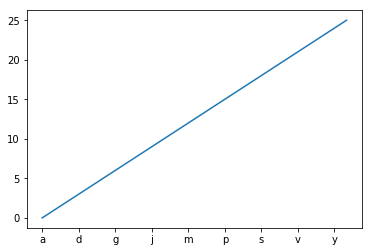

In [185]:

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
fig = plt.figure()
ax = fig.add_subplot(111)
xs = range(26)
ys = range(26)
labels = list('abcdefghijklmnopqrstuvwxyz')


def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return labels[int(tick_val)]
    else:
        return ''


ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(xs, ys)
plt.show()

In [230]:
b = [[10,100],[200,1000]]
g, p, dof, expctd = stats.chi2_contingency(b)
print(p)

0.0527494993749


In [23]:
def compare_mutfreqs(mutdict1, mutdict2, phospho_aa):
    aa_list = list("STYDENQKRHGAVLIFWMCP")
    statfunc = stats.chi2_contingency
    mutdict1_sum = mutdict_colsum(mutdict1, 'p' + phospho_aa)
    mutdict2_sum = mutdict_colsum(mutdict2, 'p' + phospho_aa)
    for aa in aa_list:
        if aa == phospho_aa:
            continue
        if mutdict1.get('p' + aa) and mutdict1.get('p' + aa):
            aa = 'p' + aa
        elif not mutdict1.get(aa):
            continue
        elif not mutdict1.get(aa):
            continue
        try:
            n1 = mutdict1['p' + phospho_aa][aa]
            n2 = mutdict2['p' + phospho_aa][aa]
        except KeyError:
            continue
        r1 = round(float(n1)/mutdict1_sum, 4)
        r2 = round(float(n2)/mutdict2_sum, 4)
        g, pvalue, dof, expctd = statfunc([[n1, mutdict1_sum], [n2, mutdict2_sum]])
        print("{}\t{}\t{}\t{}".format(aa, r1, r2, pvalue))
    

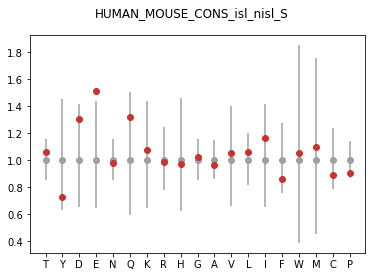

E 0.00933488081675
{'R': 16.948680744973647, 'P': 0.54092312448451918, 'I': 4.1516541476792499, 'G': 13.185110890462751, 'Q': 1.033591656006966, 'M': 13.942414275086266, 'Y': 0.71768721679204184, 'E': 0.0093348808167508252, 'D': 0.47291886253190746, 'W': 17.501941062227367, 'F': 1.9817333944161115, 'K': 11.56691471290409, 'T': 4.9494586595432244, 'N': 12.574676849900936, 'V': 13.741278708947114, 'C': 2.8474636745824129, 'H': 17.174769196524224, 'L': 7.2992996995932033, 'A': 9.7258314321625399}


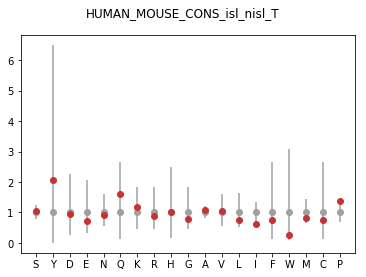

I 0.000347960210001
{'R': 13.09182282538492, 'P': 0.069341010429552957, 'I': 0.00034796021000139737, 'G': 6.8570636870821833, 'Q': 4.5351181483275624, 'M': 2.4795179485428411, 'Y': 9.2317615743198473, 'E': 5.6353641549645603, 'D': 18.789677714848256, 'S': 9.6958896253995821, 'W': 1.1325280834776217, 'F': 10.000797213024226, 'K': 10.059431243116254, 'N': 12.724319582967173, 'V': 16.124227577263433, 'C': 10.000797213024226, 'H': 19.0, 'L': 3.308241833811489, 'A': 3.0549244381239857}


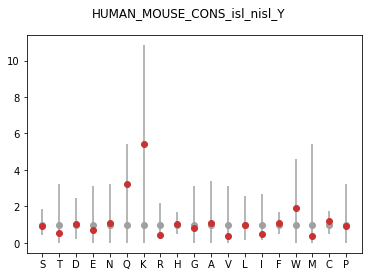

{'R': 0.82090922161965107, 'P': 19.0, 'I': 3.2531046426866421, 'G': 15.281710375282518, 'Q': 1.5486952460397028, 'M': 11.881450532631337, 'E': 11.566354455699084, 'D': 19.0, 'S': 17.84574192603209, 'W': 7.0319706209410633, 'F': 13.895476162472855, 'K': 2.1265471970087941, 'T': 7.4034803107908322, 'N': 19.0, 'V': 2.8162146255943026, 'C': 7.9244025245778404, 'H': 16.502648014647512, 'L': 19.0, 'A': 19.0}


In [25]:
#COMPARE ISL/NISL MUTFREQS_HM_CONS
#print("aacid\tin_isl\tnot_in_isl\tpvalue")
#print('S')
#compare_mutfreqs(human_np_mouse_cons_isl["mutdict"], human_np_mouse_cons_isl_n["mutdict"], 'S')
#print('T')
#compare_mutfreqs(human_np_mouse_cons_isl["mutdict"], human_np_mouse_cons_isl_n["mutdict"], 'T')
#print('Y')
#compare_mutfreqs(human_np_mouse_cons_isl["mutdict"], human_np_mouse_cons_isl_n["mutdict"], 'Y')

def prepare_mutdict(mutdict1, mutdict2, phospho_aas):
    new_mutdict = dict()
    for aa in phospho_aas:
        new_mutdict['p' + aa] = dict()
        for aa2 in mutdict1['p' + aa].keys():
            if aa2.startswith('p'):
                try:
                    new_mutdict['p' + aa][aa2] += mutdict1['p' + aa][aa2]
                except KeyError:
                    new_mutdict['p' + aa][aa2] = mutdict1['p' + aa][aa2]
            else:
                new_mutdict['p' + aa][aa2] = mutdict1['p' + aa][aa2]
    for aa in phospho_aas:
        new_mutdict[aa] = dict()
        for aa2 in mutdict2['p' + aa].keys():
            if aa2.startswith('p'):
                try:
                    new_mutdict[aa][aa2[-1]] += mutdict2['p' + aa][aa2]
                except KeyError:
                    new_mutdict[aa][aa2[-1]] = mutdict2['p' + aa][aa2]
            else:
                new_mutdict[aa][aa2] = mutdict2['p' + aa][aa2]
    return new_mutdict

#mutdict2 = prepare_mutdict(human_np_mouse_cons_or_isl["mutdict"], human_np_mouse_cons_or_isl_n["mutdict"], "STY")
mutdict2 = prepare_mutdict(hmr_cons_dr_isl["mutdict"], hmr_cons_dr_n_isl["mutdict"], "STY")

#print(mutdict)
#print(mutdict2)
print(plot_differences(mutdict2, 'S', 0.0026, "STY", True, "HUMAN_MOUSE_CONS_isl_nisl_S"))
print(plot_differences(mutdict2, 'T', 0.0026, "STY", True, "HUMAN_MOUSE_CONS_isl_nisl_T"))
print(plot_differences(mutdict2, 'Y', 0.0026, "STY", True, "HUMAN_MOUSE_CONS_isl_nisl_Y"))





##COMPARE ISL/NISL CONTROL FOR NONPHOS
#human_nonphos_isl = {'mutdict': {'pS': {'A': 929, 'C': 339, 'E': 71, 'G': 1137, 'pT': 902, 'F': 304, 'I': 151, 'H': 114, 'K': 79, 'pY': 94, 'M': 33, 'L': 384, 'N': 942, 'Q': 80, 'P': 1177, 'R': 362, 'W': 19, 'V': 115, 'D': 119}, 'pT': {'A': 1610, 'pS': 955, 'C': 19, 'E': 52, 'D': 43, 'G': 100, 'F': 18, 'I': 528, 'H': 23, 'K': 101, 'pY': 14, 'M': 225, 'L': 94, 'N': 200, 'Q': 38, 'P': 462, 'R': 109, 'W': 1, 'V': 160}, 'pY': {'A': 9, 'pS': 68, 'C': 108, 'E': 4, 'G': 4, 'pT': 8, 'F': 72, 'I': 3, 'H': 124, 'K': 1, 'L': 9, 'N': 24, 'Q': 10, 'P': 11, 'R': 7, 'W': 7, 'V': 4, 'D': 25}, 'A': {'pS': 489, 'pT': 1158, 'pY': 5, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73104, 'R': 10194, 'T': 177973, 'W': 1024, 'V': 124760, 'Y': 1045}, 'C': {'pS': 133, 'pT': 9, 'pY': 100, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14930, 'R': 10364, 'T': 931, 'W': 2285, 'V': 1254, 'Y': 12606}, 'E': {'pS': 60, 'pT': 49, 'pY': 3, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11614, 'R': 13283, 'T': 8278, 'W': 1102, 'V': 15876, 'Y': 1314}, 'D': {'pS': 92, 'pT': 31, 'pY': 33, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13056, 'R': 3846, 'T': 4793, 'W': 331, 'V': 7717, 'Y': 4722}, 'G': {'pS': 636, 'pT': 50, 'pY': 8, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91394, 'R': 58908, 'T': 8459, 'W': 3683, 'V': 23640, 'Y': 927}, 'F': {'pS': 102, 'pT': 8, 'pY': 68, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13292, 'R': 996, 'T': 1086, 'W': 880, 'V': 7343, 'Y': 7832}, 'I': {'pS': 55, 'pT': 176, 'pY': 5, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7988, 'R': 3082, 'T': 32887, 'W': 205, 'V': 75199, 'Y': 555}, 'H': {'pS': 73, 'pT': 16, 'pY': 141, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6801, 'R': 37184, 'T': 1932, 'W': 468, 'V': 1099, 'Y': 20461}, 'K': {'pS': 54, 'pT': 130, 'pY': 2, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11154, 'R': 110511, 'T': 25123, 'W': 709, 'V': 3672, 'Y': 911}, 'M': {'A': 5101, 'pS': 15, 'C': 379, 'E': 1447, 'pT': 97, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2174, 'R': 5161, 'T': 23298, 'W': 399, 'V': 38528, 'Y': 256, 'D': 405}, 'L': {'pS': 174, 'pT': 43, 'pY': 14, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30475, 'R': 16288, 'T': 6383, 'W': 6038, 'V': 51978, 'Y': 1993}, 'N': {'pS': 748, 'pT': 158, 'pY': 26, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106250, 'R': 5851, 'T': 24652, 'W': 244, 'V': 2008, 'Y': 3988}, 'Q': {'pS': 52, 'pT': 22, 'pY': 11, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9182, 'R': 62056, 'T': 4338, 'W': 4430, 'V': 3055, 'Y': 1770}, 'P': {'pS': 1085, 'pT': 274, 'pY': 14, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 159122, 'R': 25221, 'T': 43486, 'W': 1336, 'V': 8798, 'Y': 1460}, 'S': {'A': 86886, 'C': 32605, 'E': 8283, 'D': 11199, 'G': 92934, 'F': 24779, 'I': 13010, 'H': 10034, 'K': 8980, 'M': 2855, 'L': 46592, 'N': 89341, 'Q': 7156, 'P': 109200, 'R': 37976, 'T': 79782, 'W': 3386, 'V': 11549, 'Y': 7914}, 'R': {'pS': 123, 'pT': 66, 'pY': 6, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25866, 'T': 12519, 'W': 13299, 'V': 3585, 'Y': 1468}, 'T': {'A': 143120, 'C': 1663, 'E': 5053, 'D': 3438, 'G': 7208, 'F': 1830, 'I': 48054, 'H': 2330, 'K': 11670, 'M': 28757, 'L': 9195, 'N': 17451, 'Q': 3338, 'P': 45416, 'S': 78682, 'R': 11142, 'W': 556, 'V': 19432, 'Y': 887}, 'W': {'A': 415, 'pS': 8, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'pY': 3, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1551, 'R': 5931, 'T': 293, 'V': 370, 'Y': 421}, 'V': {'pS': 51, 'pT': 114, 'pY': 2, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7774, 'R': 3688, 'T': 15934, 'W': 783, 'Y': 671}, 'Y': {'A': 771, 'C': 12754, 'E': 599, 'D': 2788, 'G': 938, 'F': 11143, 'I': 668, 'H': 12678, 'K': 437, 'M': 232, 'L': 2126, 'N': 2582, 'Q': 895, 'P': 1163, 'S': 6040, 'R': 1359, 'T': 702, 'W': 616, 'V': 689}}, 'sitenumdict': {'pS': 7585, 'pT': 3586, 'pY': 789, 'A': 364933, 'C': 81968, 'E': 478806, 'D': 255334, 'G': 369827, 'F': 99762, 'I': 121630, 'H': 126374, 'K': 358577, 'M': 103380, 'L': 379057, 'N': 169476, 'Q': 285414, 'P': 450735, 'S': 565010, 'R': 325011, 'T': 275911, 'W': 28993, 'V': 202539, 'Y': 73605}}
#human_nonphos_n_isl = {'mutdict': {'pS': {'A': 2170, 'C': 794, 'E': 184, 'G': 2491, 'pT': 1970, 'F': 665, 'I': 311, 'H': 249, 'K': 178, 'pY': 199, 'M': 80, 'L': 968, 'N': 2304, 'Q': 143, 'P': 2845, 'R': 834, 'W': 73, 'V': 268, 'D': 261}, 'pT': {'A': 3658, 'pS': 2025, 'C': 54, 'E': 105, 'D': 69, 'G': 185, 'F': 62, 'I': 1202, 'H': 63, 'K': 258, 'pY': 26, 'M': 603, 'L': 243, 'N': 490, 'Q': 78, 'P': 1218, 'R': 265, 'W': 16, 'V': 482}, 'pY': {'A': 16, 'pS': 157, 'C': 351, 'G': 21, 'E': 16, 'D': 69, 'pT': 10, 'F': 257, 'I': 24, 'H': 285, 'K': 5, 'M': 4, 'L': 56, 'N': 59, 'Q': 17, 'P': 40, 'R': 20, 'W': 16, 'V': 14}, 'A': {'pS': 1704, 'pT': 4216, 'pY': 27, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 71889, 'R': 10194, 'T': 174915, 'W': 1024, 'V': 124760, 'Y': 1023}, 'C': {'pS': 406, 'pT': 27, 'pY': 352, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14657, 'R': 10364, 'T': 913, 'W': 2285, 'V': 1254, 'Y': 12354}, 'E': {'pS': 253, 'pT': 191, 'pY': 28, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11421, 'R': 13283, 'T': 8136, 'W': 1102, 'V': 15876, 'Y': 1289}, 'D': {'pS': 345, 'pT': 116, 'pY': 119, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 12803, 'R': 3846, 'T': 4708, 'W': 331, 'V': 7717, 'Y': 4636}, 'G': {'pS': 2538, 'pT': 228, 'pY': 18, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 89492, 'R': 58908, 'T': 8281, 'W': 3683, 'V': 23640, 'Y': 917}, 'F': {'pS': 389, 'pT': 24, 'pY': 219, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13005, 'R': 996, 'T': 1070, 'W': 880, 'V': 7343, 'Y': 7681}, 'I': {'pS': 264, 'pT': 887, 'pY': 23, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7779, 'R': 3082, 'T': 32176, 'W': 205, 'V': 75199, 'Y': 537}, 'H': {'pS': 190, 'pT': 53, 'pY': 555, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6684, 'R': 37184, 'T': 1895, 'W': 468, 'V': 1099, 'Y': 20047}, 'K': {'pS': 293, 'pT': 597, 'pY': 17, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 10915, 'R': 110511, 'T': 24656, 'W': 709, 'V': 3672, 'Y': 896}, 'M': {'pS': 53, 'pT': 470, 'pY': 10, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2136, 'R': 5161, 'T': 22925, 'W': 399, 'V': 38528, 'Y': 246}, 'L': {'pS': 683, 'pT': 141, 'pY': 54, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 29966, 'R': 16288, 'T': 6285, 'W': 6038, 'V': 51978, 'Y': 1953}, 'N': {'pS': 2885, 'pT': 640, 'pY': 120, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 104113, 'R': 5851, 'T': 24170, 'W': 244, 'V': 2008, 'Y': 3894}, 'Q': {'pS': 200, 'pT': 103, 'pY': 31, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9034, 'R': 62056, 'T': 4257, 'W': 4430, 'V': 3055, 'Y': 1750}, 'P': {'pS': 4203, 'pT': 1055, 'pY': 32, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 156004, 'R': 25221, 'T': 42705, 'W': 1336, 'V': 8798, 'Y': 1442}, 'S': {'A': 85645, 'C': 32150, 'E': 8170, 'D': 11057, 'G': 91580, 'F': 24418, 'I': 12850, 'H': 9899, 'K': 8881, 'M': 2808, 'L': 46008, 'N': 87979, 'Q': 7093, 'P': 107532, 'R': 37504, 'T': 78714, 'W': 3332, 'V': 11396, 'Y': 7809}, 'R': {'pS': 698, 'pT': 248, 'pY': 31, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25291, 'T': 12337, 'W': 13299, 'V': 3585, 'Y': 1443}, 'T': {'A': 141072, 'C': 1628, 'E': 5000, 'D': 3412, 'G': 7123, 'F': 1786, 'I': 47380, 'H': 2290, 'K': 11513, 'M': 28379, 'L': 9046, 'N': 17161, 'Q': 3298, 'P': 44660, 'S': 77612, 'R': 10986, 'W': 541, 'V': 19110, 'Y': 875}, 'W': {'pS': 41, 'pT': 8, 'pY': 11, 'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1518, 'R': 5931, 'T': 285, 'V': 370, 'Y': 413}, 'V': {'pS': 211, 'pT': 390, 'pY': 16, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7614, 'R': 3688, 'T': 15658, 'W': 783, 'Y': 657}, 'Y': {'A': 764, 'C': 12511, 'E': 587, 'D': 2744, 'G': 921, 'F': 10958, 'I': 647, 'H': 12517, 'K': 433, 'M': 228, 'L': 2079, 'N': 2547, 'Q': 888, 'P': 1134, 'S': 5951, 'R': 1346, 'T': 700, 'W': 607, 'V': 679}}, 'sitenumdict': {'pS': 13390, 'pT': 6315, 'pY': 1566, 'A': 358554, 'C': 80426, 'E': 472094, 'D': 250534, 'G': 363001, 'F': 97601, 'I': 119152, 'H': 123647, 'K': 352482, 'M': 101589, 'L': 372144, 'N': 166184, 'Q': 281068, 'P': 442121, 'S': 559205, 'R': 319624, 'T': 273182, 'W': 28502, 'V': 198547, 'Y': 72828}}
#
#mutdict2 = prepare_mutdict(human_nonphos_isl["mutdict"], human_nonphos_n_isl["mutdict"], "STY")
#print(plot_differences(mutdict2, 'S', 0.025, "STY", True, "NONPHOS_isl_nisl_S"))
#print(plot_differences(mutdict2, 'T', 0.025, "STY", True, "NONPHOS_isl_nisl_T"))
#print(plot_differences(mutdict2, 'Y', 0.025, "STY", True, "NONPHOS_isl_nisl_Y"))


In [282]:
#MOUSE: ANALYSIS OF VARIOUS TISSUES

d = "mouse_tissue_collection"

f = []
for i in range(1, 10):
    f.append(open(d + '_' + str(i) + ".tsv", 'w'))

with open(d + ".tsv") as infile:
    for s in infile:
        t = s.strip().split()
        f[eval(t[4]) - 1].write(s)

for i in f:
    i.close()

In [330]:
#9 TISSUES

np1 = {'mutdict': {'pS': {'A': 489, 'C': 174, 'E': 51, 'pT': 449, 'G': 467, 'F': 175, 'I': 76, 'H': 48, 'K': 65, 'pY': 42, 'M': 29, 'L': 346, 'N': 481, 'Q': 44, 'P': 600, 'R': 190, 'W': 25, 'V': 82, 'D': 71}, 'pT': {'A': 378, 'pS': 322, 'C': 5, 'E': 11, 'D': 14, 'G': 20, 'F': 5, 'I': 127, 'H': 12, 'K': 26, 'pY': 3, 'M': 58, 'L': 32, 'N': 60, 'Q': 5, 'P': 127, 'R': 25, 'W': 1, 'V': 67}, 'pY': {'A': 2, 'pS': 12, 'C': 28, 'E': 3, 'D': 4, 'G': 6, 'F': 15, 'I': 2, 'H': 17, 'K': 3, 'L': 8, 'N': 5, 'Q': 2, 'P': 4, 'R': 6, 'W': 2, 'V': 2}, 'A': {'pS': 135, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 298, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55465, 'R': 7357, 'T': 134895, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'pS': 31, 'pT': 1, 'pY': 17, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11201, 'R': 7503, 'T': 662, 'W': 1563, 'V': 879, 'Y': 9182}, 'E': {'A': 28720, 'pS': 6, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 4, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8473, 'R': 9770, 'T': 6035, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'pS': 18, 'pT': 5, 'pY': 1, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9799, 'R': 2861, 'T': 3548, 'W': 255, 'V': 5647, 'Y': 3540}, 'G': {'A': 45784, 'pS': 165, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 6, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70342, 'R': 43379, 'T': 6197, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'pS': 17, 'pT': 4, 'pY': 8, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10070, 'R': 775, 'T': 776, 'W': 631, 'V': 5582, 'Y': 5960}, 'I': {'pS': 15, 'pT': 38, 'pY': 1, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5806, 'R': 2364, 'T': 25412, 'W': 149, 'V': 58861, 'Y': 439}, 'H': {'pS': 10, 'pT': 2, 'pY': 8, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5079, 'R': 27401, 'T': 1379, 'W': 315, 'V': 760, 'Y': 15091}, 'K': {'A': 5144, 'pS': 9, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'pT': 17, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8301, 'R': 83143, 'T': 18635, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'pS': 1, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 17, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1638, 'R': 3896, 'T': 17604, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'pS': 65, 'pT': 5, 'pY': 2, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22405, 'R': 11955, 'T': 4787, 'W': 4378, 'V': 38863, 'Y': 1415}, 'N': {'pS': 227, 'pT': 51, 'pY': 6, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80537, 'R': 4354, 'T': 19039, 'W': 171, 'V': 1444, 'Y': 2887}, 'Q': {'A': 5099, 'pS': 7, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'pT': 2, 'N': 2185, 'P': 41652, 'S': 6481, 'R': 46123, 'T': 3079, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 293, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 57, 'N': 1865, 'Q': 22130, 'S': 116078, 'R': 18053, 'T': 31670, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 63810, 'C': 23636, 'E': 5732, 'D': 8073, 'G': 69666, 'F': 17598, 'I': 9340, 'H': 7180, 'K': 6289, 'M': 2018, 'L': 33616, 'N': 66517, 'Q': 5031, 'P': 78719, 'R': 27468, 'T': 58256, 'W': 2413, 'V': 8087, 'Y': 5636}, 'R': {'A': 5869, 'pS': 19, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 3, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19202, 'T': 9144, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 107720, 'C': 1136, 'E': 3745, 'D': 2486, 'G': 5234, 'F': 1336, 'I': 35543, 'H': 1637, 'K': 8989, 'M': 21679, 'L': 6712, 'N': 13362, 'Q': 2360, 'P': 33355, 'S': 59632, 'R': 8261, 'W': 389, 'V': 14291, 'Y': 631}, 'W': {'A': 239, 'pS': 1, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1067, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 10, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 4, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5734, 'R': 2742, 'T': 12187, 'W': 584, 'Y': 487}, 'Y': {'A': 590, 'C': 10058, 'E': 439, 'D': 2146, 'G': 673, 'F': 8614, 'I': 483, 'H': 9944, 'K': 317, 'M': 178, 'L': 1592, 'N': 2015, 'Q': 669, 'P': 847, 'S': 4732, 'R': 1081, 'T': 584, 'W': 481, 'V': 559}}, 'sitenumdict': {'pS': 7514, 'pT': 1660, 'pY': 226, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 472635, 'R': 265574, 'T': 224940, 'W': 22648, 'V': 171169, 'Y': 59579}}
np2 = {'mutdict': {'pS': {'A': 189, 'C': 63, 'E': 25, 'pT': 177, 'G': 164, 'F': 48, 'I': 30, 'H': 13, 'K': 16, 'pY': 12, 'M': 7, 'L': 114, 'N': 156, 'Q': 23, 'P': 220, 'R': 70, 'W': 4, 'V': 32, 'D': 23}, 'pT': {'A': 116, 'pS': 101, 'E': 8, 'D': 3, 'G': 6, 'F': 2, 'I': 33, 'K': 9, 'pY': 1, 'M': 21, 'L': 8, 'N': 16, 'Q': 1, 'P': 45, 'R': 6, 'V': 27}, 'pY': {'pS': 3, 'C': 4, 'F': 1, 'I': 1, 'H': 4, 'P': 1}, 'A': {'pS': 35, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 76, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55565, 'R': 7357, 'T': 135117, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'pS': 5, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 5, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11227, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9194}, 'E': {'A': 28720, 'pS': 4, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 1, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8475, 'R': 9770, 'T': 6038, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'pS': 6, 'pT': 2, 'pY': 1, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9811, 'R': 2861, 'T': 3551, 'W': 255, 'V': 5647, 'Y': 3540}, 'G': {'A': 45784, 'pS': 54, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70453, 'R': 43379, 'T': 6203, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'pS': 2, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10085, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'pS': 4, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 8, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5817, 'R': 2364, 'T': 25442, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'pS': 3, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5086, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18652, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'pS': 1, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 6, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1638, 'R': 3896, 'T': 17615, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 10, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'pT': 2, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22460, 'R': 11955, 'T': 4790, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'pS': 66, 'pT': 13, 'pY': 1, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80698, 'R': 4354, 'T': 19077, 'W': 171, 'V': 1444, 'Y': 2892}, 'Q': {'A': 5099, 'pS': 1, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'pT': 1, 'N': 2185, 'P': 41652, 'S': 6487, 'R': 46123, 'T': 3080, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 88, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 18, 'N': 1865, 'Q': 22130, 'S': 116283, 'R': 18053, 'T': 31709, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64110, 'C': 23747, 'E': 5758, 'D': 8121, 'G': 69969, 'F': 17725, 'I': 9386, 'H': 7215, 'K': 6338, 'M': 2040, 'L': 33848, 'N': 66842, 'Q': 5052, 'P': 79099, 'R': 27588, 'T': 58528, 'W': 2434, 'V': 8137, 'Y': 5666}, 'R': {'A': 5869, 'pS': 14, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 1, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19207, 'T': 9146, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 107982, 'C': 1141, 'E': 3748, 'D': 2497, 'G': 5248, 'F': 1339, 'I': 35637, 'H': 1649, 'K': 9006, 'M': 21716, 'L': 6736, 'N': 13406, 'Q': 2364, 'P': 33437, 'S': 59853, 'R': 8280, 'W': 390, 'V': 14331, 'Y': 633}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 2, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 6, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5742, 'R': 2742, 'T': 12185, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10082, 'E': 442, 'D': 2150, 'G': 679, 'F': 8628, 'I': 484, 'H': 9957, 'K': 320, 'M': 178, 'L': 1600, 'N': 2020, 'Q': 671, 'P': 850, 'S': 4741, 'R': 1087, 'T': 584, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 2708, 'pT': 482, 'pY': 45, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 477441, 'R': 265574, 'T': 226118, 'W': 22648, 'V': 171169, 'Y': 59760}}
np3 = {'mutdict': {'pS': {'A': 84, 'C': 42, 'E': 17, 'pT': 99, 'G': 95, 'F': 32, 'I': 12, 'H': 8, 'K': 9, 'pY': 9, 'M': 5, 'L': 58, 'N': 76, 'Q': 12, 'P': 118, 'R': 42, 'W': 4, 'V': 12, 'D': 15}, 'pT': {'A': 94, 'pS': 59, 'C': 1, 'E': 3, 'D': 4, 'G': 4, 'F': 1, 'I': 23, 'H': 2, 'K': 2, 'M': 12, 'L': 9, 'N': 12, 'Q': 3, 'P': 29, 'R': 6, 'V': 18}, 'pY': {'C': 4, 'G': 1, 'pT': 1, 'F': 3, 'I': 1, 'H': 6, 'L': 1, 'N': 1, 'Q': 1, 'R': 2}, 'A': {'pS': 21, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 45, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55579, 'R': 7357, 'T': 135148, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'pS': 6, 'pT': 1, 'pY': 4, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11226, 'R': 7503, 'T': 662, 'W': 1563, 'V': 879, 'Y': 9195}, 'E': {'A': 28720, 'pS': 5, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 1, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8474, 'R': 9770, 'T': 6038, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'pS': 5, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9812, 'R': 2861, 'T': 3553, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 39, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70468, 'R': 43379, 'T': 6203, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'pS': 5, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'pY': 1, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10082, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5967}, 'I': {'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 2, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5821, 'R': 2364, 'T': 25448, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'pS': 3, 'pT': 1, 'pY': 3, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5086, 'R': 27401, 'T': 1380, 'W': 315, 'V': 760, 'Y': 15096}, 'K': {'A': 5144, 'pS': 1, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'pT': 3, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8309, 'R': 83143, 'T': 18649, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 4, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1639, 'R': 3896, 'T': 17617, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 13, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'pT': 1, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22457, 'R': 11955, 'T': 4791, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'pS': 21, 'pT': 1, 'pY': 2, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80743, 'R': 4354, 'T': 19089, 'W': 171, 'V': 1444, 'Y': 2891}, 'Q': {'A': 5099, 'pS': 4, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6484, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'pS': 43, 'pT': 11, 'pY': 1, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 116328, 'R': 18053, 'T': 31716, 'W': 912, 'V': 6362, 'Y': 1036}, 'S': {'A': 64215, 'C': 23768, 'E': 5766, 'D': 8129, 'G': 70038, 'F': 17741, 'I': 9404, 'H': 7220, 'K': 6345, 'M': 2042, 'L': 33904, 'N': 66922, 'Q': 5063, 'P': 79201, 'R': 27616, 'T': 58606, 'W': 2434, 'V': 8157, 'Y': 5669}, 'R': {'A': 5869, 'pS': 2, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 3, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19219, 'T': 9144, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108004, 'C': 1140, 'E': 3753, 'D': 2496, 'G': 5250, 'F': 1340, 'I': 35647, 'H': 1647, 'K': 9013, 'M': 21725, 'L': 6735, 'N': 13410, 'Q': 2362, 'P': 33453, 'S': 59895, 'R': 8280, 'W': 390, 'V': 14340, 'Y': 634}, 'W': {'A': 239, 'pS': 1, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1067, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 3, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5741, 'R': 2742, 'T': 12191, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10082, 'E': 442, 'D': 2150, 'G': 678, 'F': 8626, 'I': 484, 'H': 9955, 'K': 320, 'M': 178, 'L': 1599, 'N': 2019, 'Q': 670, 'P': 851, 'S': 4744, 'R': 1085, 'T': 583, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 1601, 'pT': 314, 'pY': 37, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 478548, 'R': 265574, 'T': 226286, 'W': 22648, 'V': 171169, 'Y': 59768}}
np4 = {'mutdict': {'pS': {'A': 63, 'C': 21, 'E': 7, 'G': 80, 'pT': 68, 'F': 16, 'I': 9, 'H': 7, 'K': 7, 'pY': 8, 'M': 2, 'L': 33, 'N': 76, 'Q': 4, 'P': 54, 'R': 32, 'W': 3, 'V': 11, 'D': 7}, 'pT': {'A': 62, 'pS': 39, 'E': 3, 'D': 2, 'G': 3, 'F': 1, 'I': 13, 'H': 2, 'K': 2, 'M': 9, 'L': 7, 'N': 6, 'P': 16, 'R': 2, 'V': 10}, 'pY': {'pS': 1, 'H': 1}, 'A': {'pS': 19, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 30, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55581, 'R': 7357, 'T': 135163, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'pS': 3, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 1, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11229, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9198}, 'E': {'A': 28720, 'pS': 2, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8477, 'R': 9770, 'T': 6039, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'pS': 6, 'C': 1020, 'E': 71718, 'pT': 2, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9811, 'R': 2861, 'T': 3551, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 11, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70496, 'R': 43379, 'T': 6203, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10087, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 5, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5821, 'R': 2364, 'T': 25445, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5089, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'pT': 1, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18651, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'pS': 4, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 4, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1635, 'R': 3896, 'T': 17617, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 1, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'pT': 1, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22469, 'R': 11955, 'T': 4791, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'pS': 29, 'pT': 3, 'pY': 1, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80735, 'R': 4354, 'T': 19087, 'W': 171, 'V': 1444, 'Y': 2892}, 'Q': {'A': 5099, 'pS': 2, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6486, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 16, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 3, 'N': 1865, 'Q': 22130, 'S': 116355, 'R': 18053, 'T': 31724, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64236, 'C': 23789, 'E': 5776, 'D': 8137, 'G': 70053, 'F': 17757, 'I': 9407, 'H': 7221, 'K': 6347, 'M': 2045, 'L': 33929, 'N': 66922, 'Q': 5071, 'P': 79265, 'R': 27626, 'T': 58637, 'W': 2435, 'V': 8158, 'Y': 5670}, 'R': {'A': 5869, 'pS': 5, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 1, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19216, 'T': 9146, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108036, 'C': 1141, 'E': 3753, 'D': 2498, 'G': 5251, 'F': 1340, 'I': 35657, 'H': 1647, 'K': 9013, 'M': 21728, 'L': 6737, 'N': 13416, 'Q': 2365, 'P': 33466, 'S': 59915, 'R': 8284, 'W': 390, 'V': 14348, 'Y': 634}, 'W': {'A': 239, 'pS': 1, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1067, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 3, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5741, 'R': 2742, 'T': 12191, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10086, 'E': 442, 'D': 2150, 'G': 679, 'F': 8629, 'I': 485, 'H': 9960, 'K': 320, 'M': 178, 'L': 1600, 'N': 2020, 'Q': 671, 'P': 851, 'S': 4743, 'R': 1087, 'T': 584, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 1088, 'pT': 181, 'pY': 18, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479061, 'R': 265574, 'T': 226419, 'W': 22648, 'V': 171169, 'Y': 59787}}
np5 = {'mutdict': {'pS': {'A': 46, 'C': 20, 'E': 14, 'pT': 37, 'G': 53, 'F': 14, 'I': 6, 'H': 3, 'K': 6, 'pY': 9, 'M': 1, 'L': 28, 'N': 39, 'Q': 3, 'P': 52, 'R': 21, 'W': 2, 'V': 3, 'D': 6}, 'pT': {'A': 27, 'pS': 31, 'E': 1, 'D': 1, 'F': 1, 'I': 5, 'pY': 1, 'M': 6, 'L': 4, 'N': 2, 'Q': 1, 'P': 7, 'R': 2, 'V': 5}, 'pY': {'H': 8, 'C': 4, 'N': 1, 'E': 1, 'V': 1}, 'A': {'pS': 5, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 14, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55595, 'R': 7357, 'T': 135179, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11232, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9199}, 'E': {'A': 28720, 'pS': 1, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 1, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8478, 'R': 9770, 'T': 6038, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'pS': 3, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9814, 'R': 2861, 'T': 3553, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 18, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70489, 'R': 43379, 'T': 6203, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10087, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'pS': 2, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 1, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5819, 'R': 2364, 'T': 25449, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5089, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18652, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'pS': 1, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 3, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1638, 'R': 3896, 'T': 17618, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 4, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22466, 'R': 11955, 'T': 4792, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'A': 3445, 'pS': 31, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'pT': 3, 'Q': 2527, 'P': 2317, 'S': 80733, 'R': 4354, 'T': 19087, 'W': 171, 'V': 1444, 'Y': 2893}, 'Q': {'A': 5099, 'pS': 2, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6486, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 22, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 2, 'N': 1865, 'Q': 22130, 'S': 116349, 'R': 18053, 'T': 31725, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64253, 'C': 23790, 'E': 5769, 'D': 8138, 'G': 70080, 'F': 17759, 'I': 9410, 'H': 7225, 'K': 6348, 'M': 2046, 'L': 33934, 'N': 66959, 'Q': 5072, 'P': 79267, 'R': 27637, 'T': 58668, 'W': 2436, 'V': 8166, 'Y': 5669}, 'R': {'A': 5869, 'pS': 3, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 1, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19218, 'T': 9146, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108071, 'C': 1141, 'E': 3755, 'D': 2499, 'G': 5254, 'F': 1340, 'I': 35665, 'H': 1649, 'K': 9015, 'M': 21731, 'L': 6740, 'N': 13420, 'Q': 2364, 'P': 33475, 'S': 59923, 'R': 8284, 'W': 390, 'V': 14353, 'Y': 633}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 1, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 1, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5743, 'R': 2742, 'T': 12190, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10082, 'E': 441, 'D': 2150, 'G': 679, 'F': 8629, 'I': 485, 'H': 9953, 'K': 320, 'M': 178, 'L': 1600, 'N': 2019, 'Q': 671, 'P': 851, 'S': 4744, 'R': 1087, 'T': 584, 'W': 483, 'V': 560}}, 'sitenumdict': {'pS': 895, 'pT': 126, 'pY': 20, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479254, 'R': 265574, 'T': 226474, 'W': 22648, 'V': 171169, 'Y': 59785}}
np6 = {'mutdict': {'pS': {'A': 33, 'C': 13, 'E': 10, 'pT': 23, 'G': 30, 'F': 8, 'I': 6, 'H': 5, 'K': 7, 'pY': 4, 'M': 1, 'L': 23, 'N': 26, 'Q': 1, 'P': 41, 'R': 8, 'V': 1, 'D': 7}, 'pT': {'A': 24, 'pS': 15, 'C': 1, 'D': 2, 'I': 1, 'K': 5, 'M': 4, 'L': 4, 'N': 2, 'Q': 1, 'P': 4, 'R': 2, 'V': 7}, 'pY': {'pS': 1, 'C': 2, 'W': 1, 'F': 1}, 'A': {'pS': 7, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 9, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55593, 'R': 7357, 'T': 135184, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'pS': 4, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 5, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11228, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9194}, 'E': {'A': 28720, 'pS': 5, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8474, 'R': 9770, 'T': 6039, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'C': 1020, 'E': 71718, 'pT': 1, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9817, 'R': 2861, 'T': 3552, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 9, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 2, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70498, 'R': 43379, 'T': 6201, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'pS': 1, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'pT': 1, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10086, 'R': 775, 'T': 779, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'pS': 1, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 6, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5820, 'R': 2364, 'T': 25444, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5089, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18652, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 1, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1639, 'R': 3896, 'T': 17620, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 2, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22468, 'R': 11955, 'T': 4792, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'A': 3445, 'pS': 7, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80757, 'R': 4354, 'T': 19090, 'W': 171, 'V': 1444, 'Y': 2893}, 'Q': {'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6488, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 16, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 4, 'N': 1865, 'Q': 22130, 'S': 116355, 'R': 18053, 'T': 31723, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64266, 'C': 23797, 'E': 5773, 'D': 8137, 'G': 70103, 'F': 17765, 'I': 9410, 'H': 7223, 'K': 6347, 'M': 2046, 'L': 33939, 'N': 66972, 'Q': 5074, 'P': 79278, 'R': 27650, 'T': 58682, 'W': 2438, 'V': 8168, 'Y': 5674}, 'R': {'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19221, 'T': 9147, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108074, 'C': 1140, 'E': 3756, 'D': 2498, 'G': 5254, 'F': 1341, 'I': 35669, 'H': 1649, 'K': 9010, 'M': 21733, 'L': 6740, 'N': 13420, 'Q': 2364, 'P': 33478, 'S': 59939, 'R': 8284, 'W': 390, 'V': 14351, 'Y': 634}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5744, 'R': 2742, 'T': 12191, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10084, 'E': 442, 'D': 2150, 'G': 679, 'F': 8628, 'I': 485, 'H': 9961, 'K': 320, 'M': 178, 'L': 1600, 'N': 2020, 'Q': 671, 'P': 851, 'S': 4743, 'R': 1087, 'T': 584, 'W': 482, 'V': 561}}, 'sitenumdict': {'pS': 769, 'pT': 97, 'pY': 10, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479380, 'R': 265574, 'T': 226503, 'W': 22648, 'V': 171169, 'Y': 59795}}
np7 = {'mutdict': {'pS': {'A': 21, 'C': 11, 'E': 3, 'G': 23, 'pT': 22, 'F': 2, 'I': 2, 'H': 2, 'K': 3, 'pY': 2, 'L': 11, 'N': 27, 'Q': 4, 'P': 23, 'R': 12, 'W': 1, 'V': 6, 'D': 1}, 'pT': {'A': 6, 'pS': 6, 'E': 1, 'D': 1, 'I': 3, 'K': 1, 'M': 1, 'L': 1, 'N': 2, 'P': 3, 'R': 1, 'V': 1}, 'pY': {'P': 1, 'C': 2, 'pS': 1}, 'A': {'pS': 2, 'pT': 12, 'pY': 1, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55598, 'R': 7357, 'T': 135181, 'W': 752, 'V': 92176, 'Y': 736}, 'C': {'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11232, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9199}, 'E': {'A': 28720, 'pS': 1, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8478, 'R': 9770, 'T': 6039, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'C': 1020, 'E': 71718, 'pT': 1, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9817, 'R': 2861, 'T': 3552, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 12, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 1, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70495, 'R': 43379, 'T': 6202, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'pS': 1, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10086, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'pS': 1, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5820, 'R': 2364, 'T': 25450, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5089, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18652, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1639, 'R': 3896, 'T': 17621, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22470, 'R': 11955, 'T': 4792, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'A': 3445, 'pS': 4, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80760, 'R': 4354, 'T': 19090, 'W': 171, 'V': 1444, 'Y': 2893}, 'Q': {'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6488, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'pS': 16, 'pT': 2, 'pY': 1, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 116355, 'R': 18053, 'T': 31725, 'W': 912, 'V': 6362, 'Y': 1036}, 'S': {'A': 64278, 'C': 23799, 'E': 5780, 'D': 8143, 'G': 70110, 'F': 17771, 'I': 9414, 'H': 7226, 'K': 6351, 'M': 2047, 'L': 33951, 'N': 66971, 'Q': 5071, 'P': 79296, 'R': 27646, 'T': 58683, 'W': 2437, 'V': 8163, 'Y': 5676}, 'R': {'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19221, 'T': 9147, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108092, 'C': 1141, 'E': 3755, 'D': 2499, 'G': 5254, 'F': 1341, 'I': 35667, 'H': 1649, 'K': 9014, 'M': 21736, 'L': 6743, 'N': 13420, 'Q': 2365, 'P': 33479, 'S': 59948, 'R': 8285, 'W': 390, 'V': 14357, 'Y': 634}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5744, 'R': 2742, 'T': 12191, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10084, 'E': 442, 'D': 2150, 'G': 679, 'F': 8629, 'I': 485, 'H': 9961, 'K': 320, 'M': 178, 'L': 1600, 'N': 2020, 'Q': 671, 'P': 850, 'S': 4743, 'R': 1087, 'T': 584, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 569, 'pT': 73, 'pY': 4, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479580, 'R': 265574, 'T': 226527, 'W': 22648, 'V': 171169, 'Y': 59801}}
np8 = {'mutdict': {'pS': {'A': 18, 'C': 11, 'E': 7, 'pT': 14, 'G': 20, 'F': 11, 'I': 2, 'H': 1, 'K': 7, 'M': 1, 'L': 13, 'N': 8, 'Q': 3, 'P': 21, 'R': 9, 'W': 3, 'V': 6, 'D': 4}, 'pT': {'A': 9, 'pS': 13, 'C': 1, 'I': 15, 'K': 2, 'M': 5, 'L': 1, 'N': 1, 'P': 7, 'R': 2, 'V': 5}, 'pY': {'N': 1}, 'A': {'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 1, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55600, 'R': 7357, 'T': 135192, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11232, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9199}, 'E': {'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 1, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8479, 'R': 9770, 'T': 6038, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'pS': 4, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9813, 'R': 2861, 'T': 3553, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 4, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 3, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70503, 'R': 43379, 'T': 6200, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'pY': 1, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10087, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5967}, 'I': {'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5821, 'R': 2364, 'T': 25450, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'pS': 1, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5088, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'pS': 1, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'pT': 1, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8309, 'R': 83143, 'T': 18651, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'pT': 1, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1639, 'R': 3896, 'T': 17620, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'pS': 3, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22467, 'R': 11955, 'T': 4792, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'A': 3445, 'pS': 8, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'pT': 1, 'Q': 2527, 'P': 2317, 'S': 80756, 'R': 4354, 'T': 19089, 'W': 171, 'V': 1444, 'Y': 2893}, 'Q': {'A': 5099, 'pS': 1, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6487, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 12, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'pT': 4, 'N': 1865, 'Q': 22130, 'S': 116359, 'R': 18053, 'T': 31723, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64281, 'C': 23799, 'E': 5776, 'D': 8140, 'G': 70113, 'F': 17762, 'I': 9414, 'H': 7227, 'K': 6347, 'M': 2046, 'L': 33949, 'N': 66990, 'Q': 5072, 'P': 79298, 'R': 27649, 'T': 58691, 'W': 2435, 'V': 8163, 'Y': 5678}, 'R': {'A': 5869, 'pS': 2, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'pT': 1, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19219, 'T': 9146, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108089, 'C': 1140, 'E': 3756, 'D': 2500, 'G': 5254, 'F': 1341, 'I': 35655, 'H': 1649, 'K': 9013, 'M': 21732, 'L': 6743, 'N': 13421, 'Q': 2365, 'P': 33475, 'S': 59941, 'R': 8284, 'W': 390, 'V': 14353, 'Y': 634}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 2, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5744, 'R': 2742, 'T': 12189, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10086, 'E': 442, 'D': 2150, 'G': 679, 'F': 8629, 'I': 485, 'H': 9961, 'K': 320, 'M': 178, 'L': 1600, 'N': 2019, 'Q': 671, 'P': 851, 'S': 4744, 'R': 1087, 'T': 584, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 558, 'pT': 82, 'pY': 10, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479591, 'R': 265574, 'T': 226518, 'W': 22648, 'V': 171169, 'Y': 59795}}
np9 = {'mutdict': {'pS': {'A': 29, 'C': 9, 'E': 15, 'G': 30, 'pT': 28, 'F': 5, 'I': 3, 'H': 4, 'K': 5, 'pY': 3, 'M': 1, 'L': 13, 'N': 13, 'Q': 2, 'P': 21, 'R': 5, 'V': 6, 'D': 5}, 'pT': {'A': 13, 'pS': 16, 'E': 1, 'D': 3, 'I': 2, 'H': 1, 'M': 4, 'L': 2, 'N': 4, 'Q': 1, 'P': 2, 'R': 1, 'V': 3}, 'A': {'pS': 5, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'pT': 5, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55595, 'R': 7357, 'T': 135188, 'W': 752, 'V': 92176, 'Y': 737}, 'C': {'A': 1313, 'pS': 1, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11231, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9199}, 'E': {'A': 28720, 'pS': 2, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8477, 'R': 9770, 'T': 6039, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'A': 14208, 'pS': 1, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9816, 'R': 2861, 'T': 3553, 'W': 255, 'V': 5647, 'Y': 3541}, 'G': {'A': 45784, 'pS': 8, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 1, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70499, 'R': 43379, 'T': 6202, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10087, 'R': 775, 'T': 780, 'W': 631, 'V': 5582, 'Y': 5968}, 'I': {'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5821, 'R': 2364, 'T': 25450, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5089, 'R': 27401, 'T': 1381, 'W': 315, 'V': 760, 'Y': 15099}, 'K': {'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8310, 'R': 83143, 'T': 18652, 'W': 558, 'V': 2785, 'Y': 633}, 'M': {'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1639, 'R': 3896, 'T': 17621, 'W': 313, 'V': 29030, 'Y': 163}, 'L': {'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22470, 'R': 11955, 'T': 4792, 'W': 4378, 'V': 38863, 'Y': 1417}, 'N': {'A': 3445, 'pS': 2, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'pT': 1, 'Q': 2527, 'P': 2317, 'S': 80762, 'R': 4354, 'T': 19089, 'W': 171, 'V': 1444, 'Y': 2893}, 'Q': {'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6488, 'R': 46123, 'T': 3081, 'W': 3236, 'V': 2194, 'Y': 1238}, 'P': {'A': 57191, 'pS': 3, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 116368, 'R': 18053, 'T': 31727, 'W': 912, 'V': 6362, 'Y': 1037}, 'S': {'A': 64270, 'C': 23801, 'E': 5768, 'D': 8139, 'G': 70103, 'F': 17768, 'I': 9413, 'H': 7224, 'K': 6349, 'M': 2046, 'L': 33949, 'N': 66985, 'Q': 5073, 'P': 79298, 'R': 27653, 'T': 58677, 'W': 2438, 'V': 8163, 'Y': 5675}, 'R': {'A': 5869, 'pS': 1, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19220, 'T': 9147, 'W': 9587, 'V': 2538, 'Y': 1072}, 'T': {'A': 108085, 'C': 1141, 'E': 3755, 'D': 2497, 'G': 5254, 'F': 1341, 'I': 35668, 'H': 1648, 'K': 9015, 'M': 21733, 'L': 6742, 'N': 13418, 'Q': 2364, 'P': 33480, 'S': 59938, 'R': 8285, 'W': 390, 'V': 14355, 'Y': 634}, 'W': {'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1068, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5744, 'R': 2742, 'T': 12191, 'W': 584, 'Y': 487}, 'Y': {'A': 592, 'C': 10086, 'E': 442, 'D': 2150, 'G': 679, 'F': 8629, 'I': 485, 'H': 9961, 'K': 320, 'M': 178, 'L': 1600, 'N': 2020, 'Q': 671, 'P': 851, 'S': 4744, 'R': 1087, 'T': 584, 'W': 483, 'V': 561}}, 'sitenumdict': {'pS': 602, 'pT': 78, 'pY': 2, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298251, 'F': 80771, 'I': 96049, 'H': 99529, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 479547, 'R': 265574, 'T': 226522, 'W': 22648, 'V': 171169, 'Y': 59803}}

l = [np1, np2, np3, np4, np5, np6, np7, np8, np9]

count = 0

a = []
#for i in l:
#    count += 1
##    print(i['mutdict']['pS']['E'])
#    r1 = float(i['mutdict']['pS']['E'])/mutdict_colsum(i['mutdict'], 'pS')
#    r2 = float(i['mutdict']['S']['E'])/mutdict_colsum(i['mutdict'], 'S')
#    a.append(r1/r2)
    
for i in l:
    count += 1
#    print(i['mutdict']['pS']['E'])
    u1 = float(i['mutdict']['pS']['E'])
    d1 = mutdict_colsum(i['mutdict'], 'pS')
    u2 = float(i['mutdict']['S']['E'])
    d2 = mutdict_colsum(i['mutdict'], 'S')
    r1 = u1/d1
    r2 = u2/d2
    a.append(r1/r2)
a


[1.1374405390931555,
 1.5713221882898853,
 1.976986774364895,
 1.1987449424171701,
 3.360205372402224,
 3.5257105708480987,
 1.4828159405473418,
 3.8326125019599644,
 6.63724944908721]

In [324]:
#PSITE DENSITY

def print_ratio(infodict1, infodict2, aa):
    phos_num1 = infodict1["sitenumdict"]['p' + aa]
    phos_num2 = infodict2["sitenumdict"]['p' + aa]
    num1 = infodict1["sitenumdict"][aa]
    num2 = infodict2["sitenumdict"][aa]
    r1 = float(phos_num1)/num1
    r2 = float(phos_num2)/num2
    print("{}\t{}\t{}\t{}".format(aa, r1, r2, r1/r2))

    
def compare_fractions(infodict1, infodict2, aa, phospho_aas):
    phos_num1 = infodict1["sitenumdict"]['p' + aa]
    phos_num2 = infodict2["sitenumdict"]['p' + aa]
    sum1 = 0
    sum2 = 0
    for _aa in phospho_aas:
        sum1 += infodict1["sitenumdict"]['p' + _aa]
        sum2 += infodict2["sitenumdict"]['p' + _aa]
    r1 = float(phos_num1)/sum1
    r2 = float(phos_num2)/sum2
    statfunc = stats.chi2_contingency
    g, pvalue, dof, expctd = statfunc([[phos_num1, sum1], [phos_num2, sum2]])
    print("{}\t{}\t{}\t{}\t{}".format(aa, r1, r2, r1/r2, pvalue))
    
print("Aminoacid\tfrac_in_disord\tfrac_in_ord\tratio")
for aa in "STY":
    print_ratio(human_np_mouse_cons, human_np_mouse_cons_or, aa)
    
print("Aminoacid\tfrac_in_disord\tfrac_in_ord\tratio\tpvalue")
for aa in "STY":
    compare_fractions(human_np_mouse_cons, human_np_mouse_cons_or, aa, "STY")
#print(human_np_mouse_cons["sitenumdict"])
#print(human_np_mouse_cons_or["sitenumdict"])

Aminoacid	frac_in_disord	frac_in_ord	ratio
S	0.059609573210112086	0.010250727247541211	5.815155527078367
T	0.024646777185508884	0.005402155340341922	4.56239697541702
Y	0.03519098309329994	0.012686766275346852	2.773833956544441
Aminoacid	frac_in_disord	frac_in_ord	ratio	pvalue
S	0.7768666795292302	0.449928469241774	1.7266448616563812	4.666073575909956e-152
T	0.1621406521319699	0.20994277539341916	0.7723087961856693	1.2094869223126171e-18
Y	0.060992668338799925	0.34012875536480686	0.17932229303394806	0.0


In [20]:
#PHOSPHOSITE_RETENTION

def prev_ret_count(let_pair, ret_dict):
    statfunc = stats.chi2_contingency
    p1_p1 = ret_dict["#pX1|pX1"]
    p1_1 = ret_dict["#pX1|X1"]
    p1_p2 = ret_dict["#pX1|pX2"]
    p1_2 = ret_dict["#pX1|X2"]
    
    p2_p2 = ret_dict["#pX2|pX2"]
    p2_2 = ret_dict["#pX2|X2"]
    p2_1 = ret_dict["#X1|pX2"]
    
    r1_1 = float(p1_p1)/(p1_p1 + p1_1)
    r1_2 = float(p1_p2)/(p1_p2 + p1_2)
    cont_arr = [[p1_p1, p1_p1 + p1_1], [p1_p2, p1_p2 + p1_2]]
    g, pvalue, dof, expctd = statfunc(cont_arr)
    print("{}\t{}\t{}\t{}".format(let_pair, round(r1_1,6), round(r1_2,6), pvalue))
    
    r1_1 = float(p2_p2)/(p2_p2 + p2_2)
    r1_2 = float(p1_p2)/(p1_p2 + p2_1)
    cont_arr = [[p2_p2, p2_p2 + p2_2], [p1_p2, p1_p2 + p2_1]]
    g, pvalue, dof, expctd = statfunc(cont_arr)
    print("{}\t{}\t{}\t{}".format(let_pair[::-1], round(r1_1,6), round(r1_2,6), pvalue))

hm_ST = {'#pX1|X2': 2805, '#pX1|X1': 79495, '#pX2|pX2': 7517, '#X1|pX2': 1914, '#pX2|X2': 35555, '#pX1|pX1': 32741, '#pX1|pX2': 638}
#hm_TS = {'#pX1|X2': 1914, '#pX1|X1': 35555, '#pX2|pX2': 32741, '#X1|pX2': 2805, '#pX2|X2': 79495, '#pX1|pX1': 7517, '#pX1|pX2': 638}
hm_SY = {'#pX1|X2': 218, '#pX1|X1': 79495, '#pX2|pX2': 5178, '#X1|pX2': 221, '#pX2|X2': 26822, '#pX1|pX1': 32741, '#pX1|pX2': 31}
hm_TY = {'#pX1|X2': 20, '#pX1|X1': 35555, '#pX2|pX2': 5178, '#X1|pX2': 24, '#pX2|X2': 26822, '#pX1|pX1': 7517, '#pX1|pX2': 0}

print("PAIR\tRET_1\tRET2\tpvalue")
prev_ret_count("ST", hm_ST)
prev_ret_count("SY", hm_SY)
prev_ret_count("TY", hm_TY)


PAIR	RET_1	RET2	pvalue
ST	0.291716	0.185304	1.0163343181637865e-25
TS	0.174522	0.25	5.0203430676104875e-15
SY	0.291716	0.124498	5.8247926700568795e-06
YS	0.161812	0.123016	0.17572447798047364
TY	0.174522	0.0	0.1202419906080621
YT	0.161812	0.0	0.09381568716987337


In [54]:
#PSITE FREQS
def dictsum(_dict):
    dsum = 0
    for k in _dict.keys():
        dsum += _dict[k]
    return dsum

def freq_compar(sitenum_dict, psitenum_dict):
    statfunc = stats.chi2_contingency
    print("{}\t{}\t{}\t{}".format("aa", "r_sites", "r_psites", "pvalue"))
    for aa in sitenum_dict.keys():
        cont_arr = [[sitenum_dict[aa], dictsum(sitenum_dict)], [psitenum_dict[aa], dictsum(psitenum_dict)]]
        r_sites = float(sitenum_dict[aa])/dictsum(sitenum_dict)
        r_psites = float(psitenum_dict[aa])/dictsum(psitenum_dict)
        g, pvalue, dof, expctd = statfunc(cont_arr)
        print("{}\t{}\t{}\t{}".format(aa, r_sites, r_psites, pvalue))

#human_iptmnet
_all = {'Y': 74394, 'S': 572595, 'T': 279497}
phos1 = {'Y': 13870, 'S': 106566, 'T': 35941}
phos2 = {'Y': 2743, 'S': 33692, 'T': 7017}
print("all vs human_iPTM")
freq_compar(_all, phos1)
print("all vs hmr_cons_iPTM")
freq_compar(_all, phos2)
print("human_iPTM vs hmr_cons_iPTM")
freq_compar(phos1, phos2)

#mouse_iPTMnet
#_all = {'Y': 59805, 'S': 480149, 'T': 226600}
#phos = {'Y': 3628, 'S': 49928, 'T': 12392}

#freq_compar(_all, phos)

#human_mouse_cons_iPTMnet
_all = {'Y': 74394, 'S': 572595, 'T': 279497}
phos = {'Y': 2529, 'S': 32212, 'T': 6723}
    
freq_compar(_all, phos)      

all vs human_iPTM
aa	r_sites	r_psites	pvalue
Y	0.08029694998089555	0.08869590796600522	6.100734681189341e-25
S	0.6180287667595625	0.6814685024012482	1.1643804300898305e-113
T	0.301674283259542	0.2298355896327465	0.0
all vs hmr_cons_iPTM
aa	r_sites	r_psites	pvalue
Y	0.08029694998089555	0.06312712878578662	2.9061230913723225e-33
S	0.6180287667595625	0.7753843321366105	3.1521280433607258e-204
T	0.301674283259542	0.16148853907760288	0.0
human_iPTM vs hmr_cons_iPTM
aa	r_sites	r_psites	pvalue
Y	0.08869590796600522	0.06312712878578662	2.700424042633479e-56
S	0.6814685024012482	0.7753843321366105	6.876556686304384e-55
T	0.2298355896327465	0.16148853907760288	1.2690975071274842e-138
aa	r_sites	r_psites	pvalue
Y	0.08029694998089555	0.060992668338799925	5.907413134639386e-40
S	0.6180287667595625	0.7768666795292302	6.461403379944174e-199
T	0.301674283259542	0.1621406521319699	0.0


In [33]:

d_mouse_iptmnet = {'mutdict': {'pS': {'A': 2766, 'C': 1091, 'E': 359, 'G': 2920, 'pT': 2600, 'F': 804, 'I': 436, 'H': 264, 'K': 337, 'pY': 258, 'M': 103, 'L': 1580, 'N': 2659, 'Q': 263, 'P': 3243, 'R': 1068, 'W': 123, 'V': 390, 'D': 402}, 'pT': {'A': 2759, 'pS': 2025, 'C': 35, 'E': 100, 'D': 72, 'G': 136, 'F': 41, 'I': 857, 'H': 47, 'K': 173, 'pY': 17, 'M': 478, 'L': 185, 'N': 352, 'Q': 69, 'P': 861, 'R': 227, 'W': 13, 'V': 372}, 'pY': {'A': 11, 'pS': 111, 'C': 196, 'E': 17, 'pT': 13, 'G': 34, 'F': 169, 'I': 23, 'H': 167, 'K': 8, 'M': 2, 'L': 30, 'N': 28, 'Q': 21, 'P': 22, 'R': 30, 'W': 15, 'V': 12, 'D': 20}, 'A': {'pS': 844, 'pT': 1686, 'pY': 7, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 54756, 'R': 7357, 'T': 133507, 'W': 752, 'V': 92176, 'Y': 730}, 'C': {'pS': 163, 'pT': 10, 'pY': 119, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11069, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9080}, 'E': {'pS': 83, 'pT': 17, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8396, 'R': 9770, 'T': 6022, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 111, 'pT': 28, 'pY': 14, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9706, 'R': 2861, 'T': 3525, 'W': 255, 'V': 5647, 'Y': 3527}, 'G': {'pS': 1043, 'pT': 38, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69464, 'R': 43379, 'T': 6165, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 111, 'pT': 8, 'pY': 24, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 9976, 'R': 775, 'T': 772, 'W': 631, 'V': 5582, 'Y': 5944}, 'I': {'pS': 78, 'pT': 270, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5743, 'R': 2364, 'T': 25180, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 53, 'pT': 9, 'pY': 69, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5036, 'R': 27401, 'T': 1372, 'W': 315, 'V': 760, 'Y': 15030}, 'K': {'pS': 55, 'pT': 112, 'pY': 2, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8255, 'R': 83143, 'T': 18540, 'W': 558, 'V': 2785, 'Y': 631}, 'M': {'pS': 17, 'pT': 124, 'pY': 3, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1622, 'R': 3896, 'T': 17497, 'W': 313, 'V': 29030, 'Y': 160}, 'L': {'pS': 240, 'pT': 42, 'pY': 6, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22230, 'R': 11955, 'T': 4750, 'W': 4378, 'V': 38863, 'Y': 1411}, 'N': {'pS': 1406, 'pT': 281, 'pY': 37, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 79358, 'R': 4354, 'T': 18809, 'W': 171, 'V': 1444, 'Y': 2856}, 'Q': {'pS': 47, 'pT': 12, 'pY': 5, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6441, 'R': 46123, 'T': 3069, 'W': 3236, 'V': 2194, 'Y': 1233}, 'P': {'pS': 1622, 'pT': 337, 'pY': 8, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 114749, 'R': 18053, 'T': 31390, 'W': 912, 'V': 6362, 'Y': 1029}, 'S': {'A': 61533, 'C': 22719, 'E': 5424, 'D': 7742, 'G': 67213, 'F': 16969, 'I': 8980, 'H': 6964, 'K': 6017, 'M': 1944, 'L': 32382, 'N': 64339, 'Q': 4812, 'P': 76076, 'R': 26590, 'T': 56105, 'W': 2315, 'V': 7779, 'Y': 5420}, 'R': {'pS': 147, 'pT': 60, 'pY': 3, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19074, 'T': 9087, 'W': 9587, 'V': 2538, 'Y': 1069}, 'T': {'A': 105339, 'C': 1106, 'E': 3656, 'D': 2428, 'G': 5118, 'F': 1300, 'I': 34813, 'H': 1602, 'K': 8842, 'M': 21259, 'L': 6559, 'N': 13070, 'Q': 2296, 'P': 32621, 'S': 57929, 'R': 8059, 'W': 377, 'V': 13986, 'Y': 617}, 'W': {'pS': 10, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1058, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 59, 'pT': 74, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5685, 'R': 2742, 'T': 12117, 'W': 584, 'Y': 486}, 'Y': {'A': 581, 'C': 9890, 'E': 425, 'D': 2130, 'G': 645, 'F': 8460, 'I': 462, 'H': 9794, 'K': 312, 'M': 176, 'L': 1570, 'N': 1992, 'Q': 650, 'P': 829, 'S': 4633, 'R': 1057, 'T': 571, 'W': 468, 'V': 549}}, 'sitenumdict': {'pS': 49928, 'pT': 12392, 'pY': 3628, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298249, 'F': 80771, 'I': 96049, 'H': 99527, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 430221, 'R': 265574, 'T': 214208, 'W': 22648, 'V': 171168, 'Y': 56177}}
d_mouse_iptmnet_isl = {'mutdict': {'pS': {'A': 1254, 'C': 469, 'E': 180, 'pT': 1236, 'G': 1376, 'F': 343, 'I': 195, 'H': 115, 'K': 163, 'pY': 126, 'M': 47, 'L': 731, 'N': 1167, 'Q': 117, 'P': 1455, 'R': 479, 'W': 57, 'V': 161, 'D': 196}, 'pT': {'A': 1428, 'pS': 1062, 'C': 20, 'E': 64, 'D': 36, 'G': 56, 'F': 17, 'I': 411, 'H': 23, 'K': 97, 'pY': 10, 'M': 204, 'L': 99, 'N': 186, 'Q': 40, 'P': 435, 'R': 121, 'W': 8, 'V': 194}, 'pY': {'A': 6, 'pS': 58, 'C': 78, 'E': 5, 'pT': 7, 'G': 18, 'F': 66, 'I': 6, 'H': 74, 'K': 6, 'L': 16, 'N': 11, 'Q': 13, 'P': 5, 'R': 17, 'W': 10, 'V': 4, 'D': 10}, 'A': {'pS': 395, 'pT': 859, 'pY': 4, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55205, 'R': 7357, 'T': 134334, 'W': 752, 'V': 92176, 'Y': 733}, 'C': {'pS': 85, 'pT': 10, 'pY': 72, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11147, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9127}, 'E': {'pS': 46, 'pT': 11, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8433, 'R': 9770, 'T': 6028, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 50, 'pT': 15, 'pY': 5, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9767, 'R': 2861, 'T': 3538, 'W': 255, 'V': 5647, 'Y': 3536}, 'G': {'A': 45784, 'pS': 485, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 21, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70022, 'R': 43379, 'T': 6182, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'pS': 59, 'pT': 1, 'pY': 9, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10028, 'R': 775, 'T': 779, 'W': 631, 'V': 5582, 'Y': 5959}, 'I': {'A': 4634, 'pS': 27, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 110, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5794, 'R': 2364, 'T': 25340, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'pS': 32, 'pT': 4, 'pY': 29, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5057, 'R': 27401, 'T': 1377, 'W': 315, 'V': 760, 'Y': 15070}, 'K': {'pS': 16, 'pT': 35, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8294, 'R': 83143, 'T': 18617, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 13, 'pT': 47, 'pY': 2, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1626, 'R': 3896, 'T': 17574, 'W': 313, 'V': 29030, 'Y': 161}, 'L': {'pS': 119, 'pT': 26, 'pY': 2, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22351, 'R': 11955, 'T': 4766, 'W': 4378, 'V': 38863, 'Y': 1415}, 'N': {'pS': 625, 'pT': 144, 'pY': 18, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80139, 'R': 4354, 'T': 18946, 'W': 171, 'V': 1444, 'Y': 2875}, 'Q': {'pS': 24, 'pT': 3, 'pY': 2, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6464, 'R': 46123, 'T': 3078, 'W': 3236, 'V': 2194, 'Y': 1236}, 'P': {'pS': 668, 'pT': 142, 'pY': 4, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115703, 'R': 18053, 'T': 31585, 'W': 912, 'V': 6362, 'Y': 1033}, 'S': {'A': 63045, 'C': 23341, 'E': 5603, 'D': 7948, 'G': 68757, 'F': 17430, 'I': 9221, 'H': 7113, 'K': 6191, 'M': 2000, 'L': 33231, 'N': 65831, 'Q': 4958, 'P': 77864, 'R': 27179, 'T': 57469, 'W': 2381, 'V': 8008, 'Y': 5552}, 'R': {'pS': 49, 'pT': 19, 'pY': 1, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19172, 'T': 9128, 'W': 9587, 'V': 2538, 'Y': 1071}, 'T': {'A': 106670, 'C': 1121, 'E': 3692, 'D': 2464, 'G': 5198, 'F': 1324, 'I': 35259, 'H': 1626, 'K': 8918, 'M': 21533, 'L': 6645, 'N': 13236, 'Q': 2325, 'P': 33047, 'S': 58892, 'R': 8165, 'W': 382, 'V': 14164, 'Y': 624}, 'W': {'A': 239, 'pS': 3, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1065, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 27, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 29, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5717, 'R': 2742, 'T': 12162, 'W': 584, 'Y': 487}, 'Y': {'A': 586, 'C': 10008, 'E': 437, 'D': 2140, 'G': 661, 'F': 8563, 'I': 479, 'H': 9887, 'K': 314, 'M': 178, 'L': 1584, 'N': 2009, 'Q': 658, 'P': 846, 'S': 4686, 'R': 1070, 'T': 577, 'W': 473, 'V': 557}}, 'sitenumdict': {'pS': 25816, 'pT': 7015, 'pY': 1701, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 454333, 'R': 265574, 'T': 219585, 'W': 22648, 'V': 171168, 'Y': 58104}}
d_mouse_iptmnet_n_isl = {'mutdict': {'pS': {'A': 1512, 'C': 622, 'E': 179, 'pT': 1364, 'G': 1544, 'F': 461, 'I': 241, 'H': 149, 'K': 174, 'pY': 132, 'M': 56, 'L': 849, 'N': 1492, 'Q': 146, 'P': 1788, 'R': 589, 'W': 66, 'V': 229, 'D': 206}, 'pT': {'A': 1331, 'pS': 963, 'C': 15, 'E': 36, 'D': 36, 'G': 80, 'F': 24, 'I': 446, 'H': 24, 'K': 76, 'pY': 7, 'M': 274, 'L': 86, 'N': 166, 'Q': 29, 'P': 426, 'R': 106, 'W': 5, 'V': 178}, 'pY': {'A': 5, 'pS': 53, 'C': 118, 'E': 12, 'D': 10, 'G': 16, 'F': 103, 'pT': 6, 'H': 93, 'K': 2, 'M': 2, 'L': 14, 'N': 17, 'Q': 8, 'P': 17, 'R': 13, 'W': 5, 'V': 8, 'I': 17}, 'A': {'pS': 449, 'pT': 827, 'pY': 3, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55151, 'R': 7357, 'T': 134366, 'W': 752, 'V': 92176, 'Y': 734}, 'C': {'A': 1313, 'pS': 78, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 47, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11154, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9152}, 'E': {'A': 28720, 'pS': 37, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 6, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8442, 'R': 9770, 'T': 6033, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'pS': 61, 'pT': 13, 'pY': 9, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9756, 'R': 2861, 'T': 3540, 'W': 255, 'V': 5647, 'Y': 3532}, 'G': {'pS': 558, 'pT': 17, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69949, 'R': 43379, 'T': 6186, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 52, 'pT': 7, 'pY': 15, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10035, 'R': 775, 'T': 773, 'W': 631, 'V': 5582, 'Y': 5953}, 'I': {'pS': 51, 'pT': 160, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5770, 'R': 2364, 'T': 25290, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 21, 'pT': 5, 'pY': 40, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5068, 'R': 27401, 'T': 1376, 'W': 315, 'V': 760, 'Y': 15059}, 'K': {'pS': 39, 'pT': 77, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8271, 'R': 83143, 'T': 18575, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 4, 'pT': 77, 'pY': 1, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1635, 'R': 3896, 'T': 17544, 'W': 313, 'V': 29030, 'Y': 162}, 'L': {'pS': 121, 'pT': 16, 'pY': 4, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22349, 'R': 11955, 'T': 4776, 'W': 4378, 'V': 38863, 'Y': 1413}, 'N': {'pS': 781, 'pT': 137, 'pY': 19, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 79983, 'R': 4354, 'T': 18953, 'W': 171, 'V': 1444, 'Y': 2874}, 'Q': {'pS': 23, 'pT': 9, 'pY': 3, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6465, 'R': 46123, 'T': 3072, 'W': 3236, 'V': 2194, 'Y': 1235}, 'P': {'pS': 954, 'pT': 195, 'pY': 4, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115417, 'R': 18053, 'T': 31532, 'W': 912, 'V': 6362, 'Y': 1033}, 'S': {'A': 62787, 'C': 23188, 'E': 5604, 'D': 7938, 'G': 68589, 'F': 17312, 'I': 9175, 'H': 7079, 'K': 6180, 'M': 1991, 'L': 33113, 'N': 65506, 'Q': 4929, 'P': 77531, 'R': 27069, 'T': 57341, 'W': 2372, 'V': 7940, 'Y': 5546}, 'R': {'pS': 98, 'pT': 41, 'pY': 2, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19123, 'T': 9106, 'W': 9587, 'V': 2538, 'Y': 1070}, 'T': {'A': 106767, 'C': 1126, 'E': 3720, 'D': 2464, 'G': 5174, 'F': 1317, 'I': 35224, 'H': 1625, 'K': 8939, 'M': 21463, 'L': 6658, 'N': 13256, 'Q': 2336, 'P': 33056, 'S': 58991, 'R': 8180, 'W': 385, 'V': 14180, 'Y': 627}, 'W': {'pS': 7, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1061, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 32, 'pT': 45, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5712, 'R': 2742, 'T': 12146, 'W': 584, 'Y': 486}, 'Y': {'A': 587, 'C': 9968, 'E': 430, 'D': 2140, 'G': 663, 'F': 8526, 'I': 468, 'H': 9868, 'K': 318, 'M': 176, 'L': 1586, 'N': 2003, 'Q': 663, 'P': 834, 'S': 4691, 'R': 1074, 'T': 578, 'W': 478, 'V': 553}}, 'sitenumdict': {'pS': 24112, 'pT': 5377, 'pY': 1927, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 456037, 'R': 265574, 'T': 221223, 'W': 22648, 'V': 171169, 'Y': 57878}}
human_iptmnet = {'mutdict': {'pS': {'A': 11082, 'C': 4302, 'G': 10931, 'E': 1174, 'D': 1399, 'pT': 10148, 'F': 2971, 'I': 1533, 'H': 1111, 'K': 1141, 'pY': 947, 'M': 338, 'L': 5914, 'N': 11016, 'Q': 890, 'P': 13694, 'R': 4182, 'W': 368, 'V': 1450}, 'pT': {'A': 12643, 'pS': 7646, 'C': 172, 'E': 369, 'D': 244, 'G': 535, 'F': 181, 'I': 3941, 'H': 209, 'K': 879, 'pY': 80, 'M': 2155, 'L': 749, 'N': 1474, 'Q': 264, 'P': 3881, 'R': 811, 'W': 50, 'V': 1490}, 'pY': {'A': 94, 'pS': 672, 'C': 1562, 'E': 89, 'D': 293, 'G': 133, 'F': 1376, 'I': 88, 'H': 1402, 'K': 57, 'M': 32, 'L': 238, 'pT': 81, 'N': 275, 'Q': 103, 'P': 133, 'R': 176, 'W': 80, 'V': 107}, 'A': {'pS': 1897, 'pT': 4187, 'pY': 10, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 71696, 'R': 10194, 'T': 174944, 'W': 1024, 'V': 124760, 'Y': 1040}, 'C': {'pS': 457, 'pT': 19, 'pY': 412, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 14606, 'R': 10364, 'T': 921, 'W': 2285, 'V': 1254, 'Y': 12294}, 'E': {'pS': 149, 'pT': 51, 'pY': 7, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11525, 'R': 13283, 'T': 8276, 'W': 1102, 'V': 15876, 'Y': 1310}, 'D': {'pS': 185, 'pT': 54, 'pY': 40, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 12963, 'R': 3846, 'T': 4770, 'W': 331, 'V': 7717, 'Y': 4715}, 'G': {'pS': 2397, 'pT': 118, 'pY': 14, 'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 89633, 'R': 58908, 'T': 8391, 'W': 3683, 'V': 23640, 'Y': 921}, 'F': {'pS': 306, 'pT': 17, 'pY': 176, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13088, 'R': 996, 'T': 1077, 'W': 880, 'V': 7343, 'Y': 7724}, 'I': {'pS': 211, 'pT': 626, 'pY': 10, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 7832, 'R': 3082, 'T': 32437, 'W': 205, 'V': 75199, 'Y': 550}, 'H': {'pS': 123, 'pT': 34, 'pY': 324, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6751, 'R': 37184, 'T': 1914, 'W': 468, 'V': 1099, 'Y': 20278}, 'K': {'pS': 134, 'pT': 265, 'pY': 9, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11074, 'R': 110511, 'T': 24988, 'W': 709, 'V': 3672, 'Y': 904}, 'M': {'pS': 33, 'pT': 443, 'pY': 6, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2156, 'R': 5161, 'T': 22952, 'W': 399, 'V': 38528, 'Y': 250}, 'L': {'pS': 685, 'pT': 84, 'pY': 16, 'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 29964, 'R': 16288, 'T': 6342, 'W': 6038, 'V': 51978, 'Y': 1991}, 'N': {'pS': 3110, 'pT': 630, 'pY': 89, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 103888, 'R': 5851, 'T': 24180, 'W': 244, 'V': 2008, 'Y': 3925}, 'Q': {'pS': 127, 'pT': 50, 'pY': 12, 'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9107, 'R': 62056, 'T': 4310, 'W': 4430, 'V': 3055, 'Y': 1769}, 'P': {'pS': 4056, 'pT': 941, 'pY': 17, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 156151, 'R': 25221, 'T': 42819, 'W': 1336, 'V': 8798, 'Y': 1457}, 'S': {'A': 76733, 'C': 28642, 'E': 7180, 'D': 9919, 'G': 83140, 'F': 22112, 'I': 11628, 'H': 9037, 'K': 7918, 'M': 2550, 'L': 41062, 'N': 79267, 'Q': 6346, 'P': 96683, 'R': 34156, 'T': 70536, 'W': 3037, 'V': 10214, 'Y': 7061}, 'R': {'pS': 436, 'pT': 143, 'pY': 17, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25553, 'T': 12442, 'W': 13299, 'V': 3585, 'Y': 1457}, 'T': {'A': 132087, 'C': 1510, 'E': 4736, 'D': 3237, 'G': 6773, 'F': 1667, 'I': 44641, 'H': 2144, 'K': 10892, 'M': 26827, 'L': 8540, 'N': 16177, 'Q': 3112, 'P': 41997, 'S': 71991, 'R': 10440, 'W': 507, 'V': 18102, 'Y': 821}, 'W': {'pS': 19, 'pT': 3, 'pY': 2, 'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1540, 'R': 5931, 'T': 290, 'V': 370, 'Y': 422}, 'V': {'pS': 119, 'pT': 216, 'pY': 11, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7706, 'R': 3688, 'T': 15832, 'W': 783, 'Y': 662}, 'Y': {'A': 686, 'C': 11300, 'E': 514, 'D': 2520, 'G': 809, 'F': 9839, 'I': 583, 'H': 11400, 'K': 381, 'M': 200, 'L': 1897, 'N': 2331, 'Q': 802, 'P': 1041, 'S': 5436, 'R': 1190, 'T': 629, 'W': 543, 'V': 586}}, 'sitenumdict': {'pS': 106566, 'pT': 35941, 'pY': 13870, 'A': 366799, 'C': 82494, 'E': 480567, 'D': 256679, 'G': 371821, 'F': 100523, 'I': 122377, 'H': 127183, 'K': 359969, 'M': 103818, 'L': 380907, 'N': 170435, 'Q': 286554, 'P': 453148, 'S': 466029, 'R': 326275, 'T': 243556, 'W': 29170, 'V': 203820, 'Y': 60524}}

#mutdict = d_mouse_iptmnet["mutdict"]
mutdict = d_human_ac["mutdict"]
#mutdict = human_iptmnet["mutdict"]
def rowsum(mutdict, c):
    rowsum = 0
    for c1 in mutdict.keys():
#        if c1 in "STY" or c1 in ["pS", "pT", 'pY']:
#           continue
        try:
            rowsum += mutdict[c1][c]
#            print(c1, c, mutdict[c1][c])
        except:
            pass
    return rowsum

a1 = float(human_np_mouse_cons["sitenumdict"]['pS'])/(human_np_mouse_cons["sitenumdict"]['pS'] + human_np_mouse_cons["sitenumdict"]['S'])
#print(human_np_mouse_cons["sitenumdict"])
#print(mutdict['E']['pS']/(a1*mutdict_colsum(mutdict, 'E')))
#print(mutdict['E']['S']/((1 - a1)*mutdict_colsum(mutdict, 'E')))
statfunc = stats.chi2_contingency
print("aa\tfreq_psite\tfreq_nonpsite\tpvalue")
for i in "SACEDGFIHKMLNQPRTWVY":
    try:
        a = mutdict[i]['pK']
        b = mutdict[i]['K']
        s_a = rowsum(mutdict, 'pK')
        s_b = rowsum(mutdict, 'K')
        g, pvalue, dof, expctd = statfunc([[a, s_a],[b, s_b]])
        print("{}\t{}\t{}\t{}".format(i, round(float(a)/s_a, 6), round(float(b)/s_b, 6), pvalue))
    except:
        pass

aa	freq_psite	freq_nonpsite	pvalue
S	0.011905	0.036838	0.002534301712444297
A	0.010204	0.02244	0.0673654925599797
E	0.263605	0.272572	0.7449677724417715
D	0.008503	0.016974	0.15900788901551044
G	0.008503	0.027575	0.008172949438324795
I	0.015306	0.009999	0.2854687360848884
H	0.006803	0.006699	0.8240549434767569
M	0.013605	0.018366	0.4894523581388469
L	0.006803	0.012673	0.2827628764138759
N	0.095238	0.099322	0.8172398721577443
Q	0.085034	0.107083	0.13363204041788485
P	0.010204	0.017536	0.2392306654087208
R	0.414966	0.28649	1.275637003234011e-06
T	0.042517	0.047801	0.6337391701581081
V	0.006803	0.010569	0.4950704345487892


In [16]:
print(stats.fisher_exact([[2,5],[12,12]]))

(0.40000000000000002, 0.4116920034606365)


In [66]:
##SUBSTMAT COMPARISON

def mutdict_compar(mutdict_dict, pval_thr):
    mutdict_p = mutdict_dict["mutdict_p"]
    mutdict_np = mutdict_dict["mutdict_np"]
    count = 0
    res_dict = dict()
    for aa in mutdict_np.keys():
        if not mutdict_p.get(aa):
            continue
        sum_p = dictsum(mutdict_p[aa])
        sum_np = dictsum(mutdict_np[aa])
        for aa2 in mutdict_np[aa].keys():
            if not mutdict_p[aa].get(aa2):
                continue
            cont_arr = [[mutdict_p[aa][aa2], sum_p], [mutdict_np[aa][aa2], sum_np]]
            r1 = round(float(mutdict_p[aa][aa2])/sum_p, 6)
            r2 = round(float(mutdict_np[aa][aa2])/sum_np, 6)
            q = r1/r2
            if mutdict_p[aa][aa2] < 10 or mutdict_np[aa][aa2] < 10:
                oddsratio, pvalue = stats.fisher_exact(cont_arr)
            else:
                g, pvalue, dof, expctd = stats.chi2_contingency(cont_arr)
            if pvalue < pval_thr:
                count += 1
                res_dict[q] = "{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(aa, aa2, mutdict_p[aa][aa2], mutdict_np[aa][aa2], r1, r2, q, pvalue)
#                res_dict[q] = pvalue*312
    for p in sorted(list(res_dict.keys()))[::-1]:
        print(res_dict[p])
    print(count)
    


In [67]:
#hm_cons_S_1 = {'mutdict_np': {'A': {'C': 641, 'E': 4186, 'D': 3167, 'G': 9634, 'F': 599, 'I': 1804, 'H': 483, 'K': 910, 'M': 1204, 'L': 2485, 'N': 802, 'Q': 928, 'P': 9732, 'R': 1595, 'T': 36884, 'W': 168, 'V': 23834, 'Y': 189}, 'C': {'A': 412, 'E': 100, 'D': 168, 'G': 2264, 'F': 938, 'I': 137, 'H': 1233, 'K': 80, 'M': 52, 'L': 528, 'N': 225, 'Q': 168, 'P': 364, 'R': 2388, 'T': 214, 'W': 551, 'V': 245, 'Y': 3120}, 'E': {'A': 6571, 'C': 207, 'D': 20841, 'G': 11724, 'F': 315, 'I': 413, 'H': 617, 'K': 12489, 'M': 393, 'L': 1063, 'N': 1192, 'Q': 8107, 'P': 1381, 'R': 2108, 'T': 1480, 'W': 170, 'V': 2748, 'Y': 214}, 'D': {'A': 3666, 'C': 268, 'E': 17213, 'G': 8570, 'F': 202, 'I': 308, 'H': 2346, 'K': 749, 'M': 117, 'L': 441, 'N': 9704, 'Q': 648, 'P': 779, 'R': 700, 'T': 933, 'W': 58, 'V': 1434, 'Y': 909}, 'G': {'A': 12449, 'C': 1832, 'E': 10913, 'D': 8510, 'F': 297, 'I': 501, 'H': 693, 'K': 1348, 'M': 318, 'L': 1004, 'N': 1687, 'Q': 1209, 'P': 1522, 'R': 12276, 'T': 1722, 'W': 752, 'V': 4836, 'Y': 190}, 'F': {'A': 432, 'C': 1405, 'E': 98, 'D': 107, 'G': 194, 'I': 1220, 'H': 261, 'K': 120, 'M': 144, 'L': 8785, 'N': 113, 'Q': 124, 'P': 505, 'R': 217, 'T': 237, 'W': 194, 'V': 1837, 'Y': 1815}, 'I': {'A': 1294, 'C': 115, 'E': 205, 'D': 176, 'G': 430, 'F': 1371, 'H': 131, 'K': 481, 'M': 4284, 'L': 6469, 'N': 795, 'Q': 151, 'P': 459, 'R': 593, 'T': 6879, 'W': 46, 'V': 17339, 'Y': 126}, 'H': {'A': 474, 'C': 1950, 'E': 365, 'D': 1141, 'G': 620, 'F': 359, 'I': 166, 'K': 348, 'M': 56, 'L': 2597, 'N': 2165, 'Q': 7396, 'P': 4895, 'R': 8399, 'T': 416, 'W': 95, 'V': 237, 'Y': 4562}, 'K': {'A': 1276, 'C': 158, 'E': 9103, 'D': 739, 'G': 1442, 'F': 243, 'I': 925, 'H': 518, 'M': 1224, 'L': 829, 'N': 5502, 'Q': 7729, 'P': 1065, 'R': 20354, 'T': 5022, 'W': 127, 'V': 677, 'Y': 159}, 'M': {'A': 1001, 'C': 77, 'E': 278, 'D': 62, 'G': 355, 'F': 155, 'I': 3975, 'H': 71, 'K': 845, 'L': 5624, 'N': 109, 'Q': 201, 'P': 347, 'R': 939, 'T': 4709, 'W': 74, 'V': 8796, 'Y': 52}, 'L': {'A': 2138, 'C': 759, 'E': 729, 'D': 296, 'G': 987, 'F': 9818, 'I': 4993, 'H': 1811, 'K': 576, 'M': 4322, 'N': 311, 'Q': 3367, 'P': 12935, 'R': 3268, 'T': 1394, 'W': 1405, 'V': 11984, 'Y': 415}, 'N': {'A': 983, 'C': 326, 'E': 930, 'D': 8618, 'G': 2286, 'F': 189, 'I': 1312, 'H': 5469, 'K': 4723, 'M': 162, 'L': 481, 'Q': 708, 'P': 713, 'R': 1199, 'T': 5229, 'W': 54, 'V': 425, 'Y': 863}, 'Q': {'A': 1270, 'C': 264, 'E': 6535, 'D': 572, 'G': 1420, 'F': 224, 'I': 238, 'H': 9038, 'K': 4856, 'M': 273, 'L': 4700, 'N': 564, 'P': 11868, 'R': 12321, 'T': 816, 'W': 944, 'V': 562, 'Y': 353}, 'P': {'A': 14427, 'C': 754, 'E': 1083, 'D': 606, 'G': 1677, 'F': 984, 'I': 646, 'H': 3341, 'K': 738, 'M': 406, 'L': 23221, 'N': 522, 'Q': 5475, 'R': 4741, 'T': 8621, 'W': 265, 'V': 1705, 'Y': 298}, 'R': {'A': 1414, 'C': 2896, 'E': 1389, 'D': 427, 'G': 9152, 'F': 286, 'I': 669, 'H': 6048, 'K': 12866, 'M': 706, 'L': 2668, 'N': 724, 'Q': 11177, 'P': 3229, 'T': 2545, 'W': 2720, 'V': 693, 'Y': 276}, 'T': {'A': 34442, 'C': 379, 'E': 1026, 'D': 702, 'G': 1564, 'F': 415, 'I': 10451, 'H': 448, 'K': 2357, 'M': 6042, 'L': 2028, 'N': 3653, 'Q': 687, 'P': 9937, 'R': 2226, 'W': 118, 'V': 4549, 'Y': 205}, 'W': {'A': 95, 'C': 645, 'E': 90, 'D': 29, 'G': 608, 'F': 112, 'I': 35, 'H': 60, 'K': 80, 'M': 33, 'L': 637, 'N': 18, 'Q': 486, 'P': 118, 'R': 1396, 'T': 69, 'V': 75, 'Y': 103}, 'V': {'A': 17455, 'C': 316, 'E': 2374, 'D': 1085, 'G': 5634, 'F': 1393, 'I': 17192, 'H': 182, 'K': 506, 'M': 8811, 'L': 9236, 'N': 304, 'Q': 352, 'P': 1012, 'R': 729, 'T': 3707, 'W': 156, 'Y': 128}, 'Y': {'A': 157, 'C': 3254, 'E': 113, 'D': 632, 'G': 213, 'F': 2542, 'I': 147, 'H': 2760, 'K': 86, 'M': 49, 'L': 464, 'N': 598, 'Q': 190, 'P': 272, 'R': 333, 'T': 147, 'W': 140, 'V': 134}}, 'mutdict_p': {'A': {'C': 16, 'E': 120, 'D': 76, 'G': 358, 'F': 21, 'I': 55, 'H': 16, 'K': 28, 'M': 42, 'L': 93, 'N': 18, 'Q': 21, 'P': 300, 'R': 52, 'T': 1190, 'W': 5, 'V': 848, 'Y': 2}, 'C': {'A': 10, 'E': 3, 'D': 5, 'G': 77, 'F': 29, 'I': 2, 'H': 29, 'K': 2, 'L': 13, 'N': 8, 'Q': 6, 'P': 13, 'R': 74, 'T': 5, 'W': 12, 'V': 9, 'Y': 76}, 'E': {'A': 189, 'C': 15, 'D': 991, 'G': 340, 'F': 16, 'I': 19, 'H': 26, 'K': 265, 'M': 14, 'L': 42, 'N': 35, 'Q': 200, 'P': 75, 'R': 84, 'T': 53, 'W': 9, 'V': 88, 'Y': 8}, 'D': {'A': 136, 'C': 19, 'E': 1044, 'G': 352, 'F': 16, 'I': 23, 'H': 64, 'K': 31, 'M': 13, 'L': 20, 'N': 319, 'Q': 32, 'P': 56, 'R': 42, 'T': 52, 'W': 1, 'V': 63, 'Y': 39}, 'G': {'A': 390, 'C': 59, 'E': 321, 'D': 225, 'F': 14, 'I': 20, 'H': 13, 'K': 34, 'M': 6, 'L': 37, 'N': 32, 'Q': 30, 'P': 56, 'R': 280, 'T': 48, 'W': 16, 'V': 149, 'Y': 7}, 'F': {'A': 10, 'C': 34, 'E': 7, 'D': 5, 'G': 14, 'I': 45, 'H': 6, 'K': 4, 'M': 5, 'L': 300, 'N': 3, 'Q': 6, 'P': 18, 'R': 19, 'T': 8, 'W': 15, 'V': 56, 'Y': 59}, 'I': {'A': 45, 'C': 6, 'E': 8, 'D': 5, 'G': 11, 'F': 47, 'H': 7, 'K': 11, 'M': 177, 'L': 263, 'N': 27, 'Q': 5, 'P': 14, 'R': 17, 'T': 165, 'W': 1, 'V': 697, 'Y': 2}, 'H': {'A': 10, 'C': 22, 'E': 9, 'D': 17, 'G': 16, 'F': 12, 'I': 7, 'K': 10, 'M': 5, 'L': 43, 'N': 49, 'Q': 173, 'P': 116, 'R': 202, 'T': 8, 'W': 5, 'V': 5, 'Y': 80}, 'K': {'A': 23, 'C': 10, 'E': 151, 'D': 12, 'G': 48, 'F': 14, 'I': 22, 'H': 13, 'M': 12, 'L': 26, 'N': 96, 'Q': 152, 'P': 29, 'R': 543, 'T': 106, 'W': 2, 'V': 19, 'Y': 7}, 'M': {'A': 31, 'C': 5, 'E': 4, 'D': 9, 'G': 10, 'F': 4, 'I': 138, 'H': 8, 'K': 18, 'L': 220, 'Q': 2, 'P': 11, 'R': 27, 'T': 155, 'W': 3, 'V': 347}, 'L': {'A': 83, 'C': 33, 'E': 18, 'D': 10, 'G': 31, 'F': 311, 'I': 168, 'H': 56, 'K': 11, 'M': 169, 'N': 5, 'Q': 123, 'P': 415, 'R': 102, 'T': 50, 'W': 30, 'V': 421, 'Y': 17}, 'N': {'A': 25, 'C': 10, 'E': 22, 'D': 189, 'G': 56, 'F': 6, 'I': 37, 'H': 132, 'K': 95, 'M': 8, 'L': 8, 'Q': 23, 'P': 14, 'R': 33, 'T': 131, 'W': 2, 'V': 4, 'Y': 21}, 'Q': {'A': 53, 'C': 16, 'E': 148, 'D': 14, 'G': 35, 'F': 7, 'I': 5, 'H': 258, 'K': 99, 'M': 4, 'L': 125, 'N': 19, 'P': 351, 'R': 265, 'T': 25, 'W': 16, 'V': 18, 'Y': 9}, 'P': {'A': 807, 'C': 53, 'E': 59, 'D': 45, 'G': 112, 'F': 60, 'I': 38, 'H': 196, 'K': 76, 'M': 26, 'L': 1268, 'N': 20, 'Q': 287, 'R': 255, 'T': 479, 'W': 14, 'V': 102, 'Y': 17}, 'R': {'A': 82, 'C': 89, 'E': 55, 'D': 35, 'G': 259, 'F': 16, 'I': 37, 'H': 251, 'K': 438, 'M': 29, 'L': 111, 'N': 24, 'Q': 377, 'P': 163, 'T': 60, 'W': 85, 'V': 37, 'Y': 11}, 'T': {'A': 1057, 'C': 26, 'E': 21, 'D': 18, 'G': 39, 'F': 6, 'I': 246, 'H': 16, 'K': 40, 'M': 155, 'L': 56, 'N': 109, 'Q': 22, 'P': 291, 'R': 48, 'W': 4, 'V': 111, 'Y': 8}, 'W': {'A': 3, 'C': 16, 'E': 1, 'D': 1, 'G': 7, 'F': 5, 'I': 2, 'H': 4, 'L': 14, 'Q': 12, 'P': 8, 'R': 28, 'V': 4, 'Y': 2}, 'V': {'A': 710, 'C': 14, 'E': 65, 'D': 30, 'G': 206, 'F': 60, 'I': 649, 'H': 3, 'K': 14, 'M': 366, 'L': 358, 'N': 10, 'Q': 16, 'P': 32, 'R': 24, 'T': 112, 'W': 11, 'Y': 5}, 'Y': {'A': 7, 'C': 79, 'E': 4, 'D': 22, 'G': 20, 'F': 98, 'I': 3, 'H': 67, 'K': 3, 'M': 1, 'L': 21, 'N': 16, 'Q': 9, 'P': 10, 'R': 9, 'T': 7, 'W': 14, 'V': 4}}}
#hm_cons_S_2 = {'mutdict_np': {'A': {'C': 637, 'E': 4466, 'D': 3504, 'G': 10262, 'F': 559, 'I': 1853, 'H': 466, 'K': 980, 'M': 1224, 'L': 2516, 'N': 857, 'Q': 941, 'P': 10388, 'R': 1694, 'T': 36606, 'W': 186, 'V': 25126, 'Y': 205}, 'C': {'A': 398, 'E': 98, 'D': 191, 'G': 2366, 'F': 809, 'I': 127, 'H': 1129, 'K': 81, 'M': 61, 'L': 498, 'N': 209, 'Q': 178, 'P': 336, 'R': 2324, 'T': 190, 'W': 491, 'V': 268, 'Y': 2942}, 'E': {'A': 6590, 'C': 211, 'D': 22658, 'G': 12150, 'F': 312, 'I': 425, 'H': 656, 'K': 12266, 'M': 414, 'L': 1171, 'N': 1248, 'Q': 8058, 'P': 1468, 'R': 2188, 'T': 1497, 'W': 182, 'V': 2869, 'Y': 215}, 'D': {'A': 3866, 'C': 252, 'E': 18121, 'G': 8871, 'F': 192, 'I': 332, 'H': 2372, 'K': 766, 'M': 140, 'L': 497, 'N': 9558, 'Q': 641, 'P': 787, 'R': 725, 'T': 995, 'W': 68, 'V': 1461, 'Y': 978}, 'G': {'A': 12085, 'C': 1736, 'E': 11088, 'D': 8774, 'F': 305, 'I': 488, 'H': 718, 'K': 1298, 'M': 320, 'L': 984, 'N': 1638, 'Q': 1207, 'P': 1535, 'R': 11824, 'T': 1688, 'W': 743, 'V': 4853, 'Y': 191}, 'F': {'A': 408, 'C': 1302, 'E': 127, 'D': 97, 'G': 220, 'I': 1262, 'H': 227, 'K': 117, 'M': 139, 'L': 8194, 'N': 125, 'Q': 116, 'P': 502, 'R': 186, 'T': 257, 'W': 173, 'V': 1697, 'Y': 1748}, 'I': {'A': 1438, 'C': 95, 'E': 208, 'D': 187, 'G': 433, 'F': 1327, 'H': 153, 'K': 519, 'M': 4839, 'L': 6425, 'N': 866, 'Q': 155, 'P': 463, 'R': 681, 'T': 7571, 'W': 37, 'V': 17017, 'Y': 110}, 'H': {'A': 469, 'C': 1788, 'E': 383, 'D': 1163, 'G': 656, 'F': 353, 'I': 179, 'K': 307, 'M': 78, 'L': 2486, 'N': 2280, 'Q': 6980, 'P': 4826, 'R': 8074, 'T': 418, 'W': 97, 'V': 223, 'Y': 4543}, 'K': {'A': 1212, 'C': 185, 'E': 9084, 'D': 829, 'G': 1346, 'F': 233, 'I': 866, 'H': 529, 'M': 1238, 'L': 876, 'N': 5888, 'Q': 7468, 'P': 1034, 'R': 19692, 'T': 5006, 'W': 129, 'V': 687, 'Y': 174}, 'M': {'A': 1051, 'C': 68, 'E': 266, 'D': 78, 'G': 361, 'F': 179, 'I': 4469, 'H': 69, 'K': 945, 'L': 5532, 'N': 117, 'Q': 192, 'P': 366, 'R': 1085, 'T': 5131, 'W': 84, 'V': 8599, 'Y': 50}, 'L': {'A': 2109, 'C': 737, 'E': 703, 'D': 287, 'G': 994, 'F': 9176, 'I': 4870, 'H': 1779, 'K': 561, 'M': 4448, 'N': 346, 'Q': 3497, 'P': 12834, 'R': 3361, 'T': 1342, 'W': 1382, 'V': 11343, 'Y': 401}, 'N': {'A': 988, 'C': 309, 'E': 900, 'D': 8122, 'G': 2209, 'F': 176, 'I': 1343, 'H': 5328, 'K': 5001, 'M': 152, 'L': 481, 'Q': 663, 'P': 660, 'R': 1228, 'T': 5432, 'W': 59, 'V': 402, 'Y': 823}, 'Q': {'A': 1247, 'C': 253, 'E': 6475, 'D': 569, 'G': 1331, 'F': 201, 'I': 220, 'H': 8726, 'K': 4937, 'M': 229, 'L': 4535, 'N': 546, 'P': 11286, 'R': 11513, 'T': 817, 'W': 891, 'V': 554, 'Y': 350}, 'P': {'A': 15133, 'C': 752, 'E': 1083, 'D': 643, 'G': 1699, 'F': 940, 'I': 686, 'H': 3596, 'K': 817, 'M': 423, 'L': 22949, 'N': 500, 'Q': 5821, 'R': 4808, 'T': 8965, 'W': 247, 'V': 1658, 'Y': 281}, 'R': {'A': 1388, 'C': 2698, 'E': 1346, 'D': 425, 'G': 8651, 'F': 261, 'I': 734, 'H': 5916, 'K': 13349, 'M': 713, 'L': 2518, 'N': 732, 'Q': 10263, 'P': 2991, 'T': 2483, 'W': 2455, 'V': 675, 'Y': 280}, 'T': {'A': 32641, 'C': 378, 'E': 1054, 'D': 773, 'G': 1573, 'F': 376, 'I': 11024, 'H': 500, 'K': 2488, 'M': 6435, 'L': 1997, 'N': 3894, 'Q': 722, 'P': 10332, 'R': 2408, 'W': 111, 'V': 4316, 'Y': 166}, 'W': {'A': 85, 'C': 569, 'E': 95, 'D': 19, 'G': 583, 'F': 118, 'I': 31, 'H': 51, 'K': 77, 'M': 42, 'L': 519, 'N': 22, 'Q': 426, 'P': 113, 'R': 1297, 'T': 53, 'V': 76, 'Y': 87}, 'V': {'A': 18232, 'C': 281, 'E': 2395, 'D': 1095, 'G': 5984, 'F': 1412, 'I': 16555, 'H': 179, 'K': 540, 'M': 8194, 'L': 8816, 'N': 315, 'Q': 400, 'P': 1004, 'R': 756, 'T': 3392, 'W': 136, 'Y': 131}, 'Y': {'A': 152, 'C': 2907, 'E': 108, 'D': 583, 'G': 209, 'F': 2400, 'I': 135, 'H': 2807, 'K': 93, 'M': 43, 'L': 448, 'N': 605, 'Q': 210, 'P': 264, 'R': 270, 'T': 138, 'W': 140, 'V': 131}}, 'mutdict_p': {'A': {'C': 28, 'E': 131, 'D': 111, 'G': 409, 'F': 22, 'I': 58, 'H': 15, 'K': 29, 'M': 31, 'L': 101, 'N': 20, 'Q': 36, 'P': 350, 'R': 49, 'T': 1317, 'W': 15, 'V': 845, 'Y': 10}, 'C': {'A': 8, 'D': 5, 'G': 61, 'F': 18, 'I': 3, 'H': 19, 'K': 2, 'M': 1, 'L': 10, 'N': 5, 'Q': 2, 'P': 10, 'R': 47, 'T': 7, 'W': 5, 'V': 7, 'Y': 54}, 'E': {'A': 226, 'C': 16, 'D': 1321, 'G': 475, 'F': 18, 'I': 23, 'H': 36, 'K': 356, 'M': 12, 'L': 73, 'N': 37, 'Q': 234, 'P': 75, 'R': 100, 'T': 59, 'W': 8, 'V': 104, 'Y': 9}, 'D': {'A': 147, 'C': 17, 'E': 1305, 'G': 421, 'F': 7, 'I': 22, 'H': 71, 'K': 50, 'M': 8, 'L': 46, 'N': 380, 'Q': 27, 'P': 54, 'R': 36, 'T': 49, 'W': 7, 'V': 62, 'Y': 25}, 'G': {'A': 510, 'C': 76, 'E': 427, 'D': 336, 'F': 16, 'I': 26, 'H': 18, 'K': 43, 'M': 10, 'L': 49, 'N': 58, 'Q': 44, 'P': 72, 'R': 394, 'T': 89, 'W': 22, 'V': 200, 'Y': 10}, 'F': {'A': 17, 'C': 29, 'E': 3, 'G': 10, 'I': 26, 'H': 4, 'K': 1, 'M': 4, 'L': 224, 'N': 5, 'P': 8, 'R': 7, 'T': 6, 'W': 9, 'V': 28, 'Y': 67}, 'I': {'A': 45, 'C': 7, 'E': 14, 'D': 5, 'G': 20, 'F': 29, 'H': 3, 'K': 14, 'M': 156, 'L': 240, 'N': 15, 'Q': 4, 'P': 22, 'R': 14, 'T': 233, 'W': 1, 'V': 680, 'Y': 2}, 'H': {'A': 16, 'C': 56, 'E': 17, 'D': 39, 'G': 13, 'F': 10, 'I': 3, 'K': 17, 'M': 2, 'L': 90, 'N': 73, 'Q': 288, 'P': 179, 'R': 256, 'T': 18, 'W': 10, 'V': 9, 'Y': 96}, 'K': {'A': 46, 'C': 9, 'E': 219, 'D': 24, 'G': 44, 'F': 11, 'I': 15, 'H': 15, 'M': 33, 'L': 27, 'N': 142, 'Q': 246, 'P': 54, 'R': 726, 'T': 172, 'W': 9, 'V': 23, 'Y': 4}, 'M': {'A': 35, 'C': 4, 'E': 5, 'D': 3, 'G': 20, 'F': 4, 'I': 123, 'H': 2, 'K': 17, 'L': 182, 'N': 6, 'Q': 10, 'P': 10, 'R': 25, 'T': 140, 'W': 3, 'V': 276, 'Y': 1}, 'L': {'A': 58, 'C': 20, 'E': 16, 'D': 14, 'G': 38, 'F': 273, 'I': 213, 'H': 50, 'K': 21, 'M': 160, 'N': 5, 'Q': 109, 'P': 352, 'R': 111, 'T': 34, 'W': 28, 'V': 371, 'Y': 9}, 'N': {'A': 32, 'C': 12, 'E': 35, 'D': 267, 'G': 77, 'F': 8, 'I': 46, 'H': 177, 'K': 102, 'M': 6, 'L': 17, 'Q': 23, 'P': 32, 'R': 32, 'T': 176, 'W': 2, 'V': 19, 'Y': 18}, 'Q': {'A': 52, 'C': 9, 'E': 158, 'D': 22, 'G': 38, 'F': 8, 'I': 3, 'H': 271, 'K': 128, 'M': 8, 'L': 131, 'N': 11, 'P': 402, 'R': 343, 'T': 22, 'W': 13, 'V': 21, 'Y': 7}, 'P': {'A': 516, 'C': 22, 'E': 31, 'D': 28, 'G': 71, 'F': 32, 'I': 26, 'H': 116, 'K': 24, 'M': 18, 'L': 748, 'N': 10, 'Q': 200, 'R': 133, 'T': 324, 'W': 10, 'V': 49, 'Y': 11}, 'R': {'A': 100, 'C': 171, 'E': 75, 'D': 18, 'G': 380, 'F': 26, 'I': 43, 'H': 379, 'K': 643, 'M': 32, 'L': 204, 'N': 31, 'Q': 616, 'P': 174, 'T': 116, 'W': 105, 'V': 37, 'Y': 18}, 'T': {'A': 1257, 'C': 18, 'E': 27, 'D': 18, 'G': 54, 'F': 12, 'I': 303, 'H': 22, 'K': 67, 'M': 180, 'L': 80, 'N': 133, 'Q': 22, 'P': 381, 'R': 86, 'W': 4, 'V': 162, 'Y': 6}, 'W': {'A': 1, 'C': 11, 'E': 1, 'G': 7, 'F': 6, 'H': 1, 'K': 9, 'M': 4, 'L': 7, 'N': 1, 'Q': 8, 'P': 1, 'R': 27, 'V': 5, 'Y': 4}, 'V': {'A': 745, 'C': 17, 'E': 66, 'D': 43, 'G': 242, 'F': 47, 'I': 747, 'H': 6, 'K': 15, 'M': 340, 'L': 346, 'N': 7, 'Q': 11, 'P': 46, 'R': 25, 'T': 119, 'W': 5, 'Y': 9}, 'Y': {'A': 12, 'C': 84, 'E': 3, 'D': 17, 'G': 5, 'F': 75, 'I': 4, 'H': 90, 'K': 1, 'M': 4, 'L': 11, 'N': 16, 'Q': 6, 'P': 11, 'R': 10, 'T': 5, 'W': 4}}}
#hm_cons_S_3 = {'mutdict_np': {'A': {'C': 580, 'E': 4428, 'D': 3328, 'G': 10110, 'F': 520, 'I': 1881, 'H': 455, 'K': 950, 'M': 1151, 'L': 2449, 'N': 909, 'Q': 949, 'P': 10212, 'R': 1612, 'T': 35833, 'W': 199, 'V': 24056, 'Y': 211}, 'C': {'A': 384, 'E': 96, 'D': 190, 'G': 2262, 'F': 859, 'I': 95, 'H': 1187, 'K': 88, 'M': 52, 'L': 456, 'N': 217, 'Q': 187, 'P': 338, 'R': 2311, 'T': 175, 'W': 506, 'V': 267, 'Y': 2957}, 'E': {'A': 6437, 'C': 233, 'D': 22756, 'G': 11969, 'F': 312, 'I': 413, 'H': 657, 'K': 12378, 'M': 393, 'L': 1065, 'N': 1271, 'Q': 8190, 'P': 1388, 'R': 2338, 'T': 1453, 'W': 178, 'V': 2744, 'Y': 222}, 'D': {'A': 3717, 'C': 247, 'E': 18627, 'G': 9007, 'F': 169, 'I': 347, 'H': 2412, 'K': 801, 'M': 121, 'L': 483, 'N': 9501, 'Q': 678, 'P': 702, 'R': 750, 'T': 950, 'W': 71, 'V': 1513, 'Y': 943}, 'G': {'A': 11816, 'C': 1745, 'E': 10917, 'D': 8689, 'F': 303, 'I': 509, 'H': 708, 'K': 1265, 'M': 294, 'L': 946, 'N': 1582, 'Q': 1184, 'P': 1446, 'R': 11537, 'T': 1701, 'W': 725, 'V': 4741, 'Y': 184}, 'F': {'A': 363, 'C': 1313, 'E': 120, 'D': 107, 'G': 202, 'I': 1203, 'H': 253, 'K': 118, 'M': 129, 'L': 7910, 'N': 140, 'Q': 111, 'P': 515, 'R': 206, 'T': 266, 'W': 190, 'V': 1728, 'Y': 1764}, 'I': {'A': 1321, 'C': 98, 'E': 211, 'D': 190, 'G': 447, 'F': 1205, 'H': 161, 'K': 532, 'M': 4613, 'L': 6109, 'N': 886, 'Q': 156, 'P': 431, 'R': 649, 'T': 7564, 'W': 36, 'V': 16302, 'Y': 116}, 'H': {'A': 431, 'C': 1843, 'E': 391, 'D': 1166, 'G': 603, 'F': 374, 'I': 160, 'K': 338, 'M': 71, 'L': 2572, 'N': 2209, 'Q': 7391, 'P': 4841, 'R': 8084, 'T': 393, 'W': 81, 'V': 213, 'Y': 4580}, 'K': {'A': 1212, 'C': 150, 'E': 8977, 'D': 749, 'G': 1413, 'F': 224, 'I': 892, 'H': 543, 'M': 1251, 'L': 875, 'N': 5772, 'Q': 7288, 'P': 1073, 'R': 19933, 'T': 5002, 'W': 116, 'V': 651, 'Y': 159}, 'M': {'A': 1021, 'C': 79, 'E': 276, 'D': 78, 'G': 386, 'F': 128, 'I': 4307, 'H': 94, 'K': 947, 'L': 5388, 'N': 111, 'Q': 199, 'P': 376, 'R': 1074, 'T': 5201, 'W': 76, 'V': 8256, 'Y': 46}, 'L': {'A': 2070, 'C': 737, 'E': 704, 'D': 303, 'G': 937, 'F': 9140, 'I': 4825, 'H': 1780, 'K': 565, 'M': 4046, 'N': 307, 'Q': 3441, 'P': 13172, 'R': 3358, 'T': 1302, 'W': 1301, 'V': 10963, 'Y': 437}, 'N': {'A': 991, 'C': 288, 'E': 934, 'D': 8141, 'G': 2240, 'F': 186, 'I': 1325, 'H': 5254, 'K': 5144, 'M': 168, 'L': 465, 'Q': 713, 'P': 658, 'R': 1287, 'T': 5384, 'W': 64, 'V': 391, 'Y': 869}, 'Q': {'A': 1268, 'C': 290, 'E': 6781, 'D': 637, 'G': 1351, 'F': 223, 'I': 224, 'H': 9164, 'K': 5115, 'M': 258, 'L': 4747, 'N': 575, 'P': 11564, 'R': 11967, 'T': 789, 'W': 901, 'V': 518, 'Y': 361}, 'P': {'A': 15074, 'C': 743, 'E': 1146, 'D': 628, 'G': 1663, 'F': 962, 'I': 683, 'H': 3666, 'K': 852, 'M': 380, 'L': 23567, 'N': 517, 'Q': 5890, 'R': 5010, 'T': 9036, 'W': 268, 'V': 1704, 'Y': 296}, 'R': {'A': 1402, 'C': 2665, 'E': 1332, 'D': 398, 'G': 8341, 'F': 227, 'I': 671, 'H': 5924, 'K': 12936, 'M': 697, 'L': 2491, 'N': 725, 'Q': 10673, 'P': 2987, 'T': 2587, 'W': 2565, 'V': 639, 'Y': 264}, 'T': {'A': 32188, 'C': 314, 'E': 1069, 'D': 745, 'G': 1586, 'F': 389, 'I': 10880, 'H': 504, 'K': 2489, 'M': 6331, 'L': 1965, 'N': 3846, 'Q': 723, 'P': 10438, 'R': 2290, 'W': 101, 'V': 4248, 'Y': 186}, 'W': {'A': 93, 'C': 613, 'E': 84, 'D': 24, 'G': 529, 'F': 118, 'I': 41, 'H': 45, 'K': 75, 'M': 30, 'L': 582, 'N': 29, 'Q': 433, 'P': 116, 'R': 1233, 'T': 60, 'V': 65, 'Y': 81}, 'V': {'A': 17428, 'C': 280, 'E': 2243, 'D': 1027, 'G': 5767, 'F': 1302, 'I': 15975, 'H': 182, 'K': 494, 'M': 7732, 'L': 8353, 'N': 305, 'Q': 401, 'P': 1055, 'R': 728, 'T': 3415, 'W': 149, 'Y': 149}, 'Y': {'A': 157, 'C': 3052, 'E': 127, 'D': 664, 'G': 212, 'F': 2341, 'I': 129, 'H': 2824, 'K': 79, 'M': 41, 'L': 457, 'N': 597, 'Q': 181, 'P': 263, 'R': 299, 'T': 161, 'W': 123, 'V': 156}}, 'mutdict_p': {'A': {'C': 14, 'E': 151, 'D': 107, 'G': 459, 'F': 21, 'I': 78, 'H': 17, 'K': 37, 'M': 49, 'L': 80, 'N': 30, 'Q': 54, 'P': 442, 'R': 72, 'T': 1635, 'W': 8, 'V': 1035, 'Y': 16}, 'C': {'A': 11, 'E': 2, 'D': 5, 'G': 96, 'F': 19, 'I': 3, 'H': 28, 'K': 2, 'M': 1, 'L': 7, 'N': 10, 'Q': 5, 'P': 7, 'R': 53, 'T': 3, 'W': 12, 'V': 11, 'Y': 91}, 'E': {'A': 252, 'C': 23, 'D': 1587, 'G': 488, 'F': 21, 'I': 35, 'H': 46, 'K': 386, 'M': 22, 'L': 81, 'N': 63, 'Q': 337, 'P': 88, 'R': 111, 'T': 64, 'W': 12, 'V': 94, 'Y': 17}, 'D': {'A': 133, 'C': 9, 'E': 1286, 'G': 317, 'F': 9, 'I': 21, 'H': 64, 'K': 37, 'M': 5, 'L': 36, 'N': 359, 'Q': 27, 'P': 33, 'R': 37, 'T': 46, 'W': 3, 'V': 60, 'Y': 34}, 'G': {'A': 514, 'C': 89, 'E': 331, 'D': 253, 'F': 13, 'I': 22, 'H': 20, 'K': 41, 'M': 15, 'L': 39, 'N': 63, 'Q': 34, 'P': 63, 'R': 362, 'T': 71, 'W': 18, 'V': 192, 'Y': 4}, 'F': {'A': 16, 'C': 57, 'E': 3, 'D': 1, 'G': 9, 'I': 61, 'H': 7, 'K': 19, 'M': 3, 'L': 347, 'N': 1, 'Q': 5, 'P': 12, 'R': 8, 'T': 10, 'W': 7, 'V': 75, 'Y': 62}, 'I': {'A': 55, 'C': 6, 'E': 6, 'D': 5, 'G': 13, 'F': 45, 'H': 7, 'K': 13, 'M': 178, 'L': 245, 'N': 29, 'Q': 7, 'P': 12, 'R': 19, 'T': 231, 'W': 2, 'V': 684, 'Y': 5}, 'H': {'A': 19, 'C': 52, 'E': 19, 'D': 28, 'G': 22, 'F': 9, 'I': 7, 'K': 17, 'M': 2, 'L': 79, 'N': 79, 'Q': 261, 'P': 158, 'R': 266, 'T': 13, 'W': 5, 'V': 3, 'Y': 106}, 'K': {'A': 38, 'C': 16, 'E': 268, 'D': 50, 'G': 62, 'F': 24, 'I': 36, 'H': 32, 'M': 41, 'L': 46, 'N': 162, 'Q': 244, 'P': 58, 'R': 879, 'T': 183, 'W': 1, 'V': 27, 'Y': 6}, 'M': {'A': 31, 'C': 3, 'E': 10, 'D': 4, 'G': 14, 'F': 3, 'I': 144, 'H': 6, 'K': 20, 'L': 209, 'N': 6, 'Q': 5, 'P': 13, 'R': 31, 'T': 188, 'W': 9, 'V': 288, 'Y': 2}, 'L': {'A': 74, 'C': 27, 'E': 37, 'D': 23, 'G': 44, 'F': 301, 'I': 182, 'H': 63, 'K': 21, 'M': 186, 'N': 15, 'Q': 100, 'P': 459, 'R': 104, 'T': 48, 'W': 31, 'V': 395, 'Y': 10}, 'N': {'A': 24, 'C': 12, 'E': 34, 'D': 245, 'G': 62, 'F': 6, 'I': 44, 'H': 189, 'K': 124, 'M': 6, 'L': 15, 'Q': 20, 'P': 27, 'R': 26, 'T': 192, 'W': 1, 'V': 16, 'Y': 19}, 'Q': {'A': 67, 'C': 12, 'E': 211, 'D': 26, 'G': 32, 'F': 6, 'I': 10, 'H': 360, 'K': 112, 'M': 12, 'L': 148, 'N': 14, 'P': 408, 'R': 349, 'T': 34, 'W': 22, 'V': 22, 'Y': 10}, 'P': {'A': 630, 'C': 27, 'E': 36, 'D': 29, 'G': 68, 'F': 40, 'I': 13, 'H': 130, 'K': 36, 'M': 11, 'L': 759, 'N': 17, 'Q': 167, 'R': 156, 'T': 313, 'W': 5, 'V': 57, 'Y': 9}, 'R': {'A': 74, 'C': 115, 'E': 63, 'D': 37, 'G': 313, 'F': 21, 'I': 30, 'H': 286, 'K': 581, 'M': 25, 'L': 126, 'N': 41, 'Q': 460, 'P': 142, 'T': 76, 'W': 70, 'V': 23, 'Y': 12}, 'T': {'A': 1325, 'C': 15, 'E': 22, 'D': 25, 'G': 42, 'F': 17, 'I': 258, 'H': 16, 'K': 63, 'M': 190, 'L': 58, 'N': 126, 'Q': 18, 'P': 336, 'R': 64, 'W': 2, 'V': 137, 'Y': 1}, 'W': {'A': 4, 'C': 19, 'E': 5, 'G': 16, 'F': 6, 'H': 2, 'K': 2, 'M': 5, 'L': 15, 'Q': 15, 'P': 3, 'R': 20, 'T': 1, 'V': 5, 'Y': 3}, 'V': {'A': 696, 'C': 10, 'E': 65, 'D': 39, 'G': 224, 'F': 44, 'I': 613, 'H': 2, 'K': 32, 'M': 351, 'L': 340, 'N': 7, 'Q': 13, 'P': 52, 'R': 33, 'T': 113, 'W': 6, 'Y': 1}, 'Y': {'A': 12, 'C': 97, 'E': 3, 'D': 21, 'G': 19, 'F': 92, 'I': 5, 'H': 84, 'K': 2, 'M': 2, 'L': 15, 'N': 21, 'Q': 4, 'P': 6, 'R': 15, 'T': 1, 'W': 2, 'V': 3}}}
#hm_cons_S_5 = {'mutdict_np': {'A': {'C': 583, 'E': 4399, 'D': 3322, 'G': 9898, 'F': 549, 'I': 1795, 'H': 451, 'K': 975, 'M': 1123, 'L': 2372, 'N': 868, 'Q': 895, 'P': 10273, 'R': 1642, 'T': 36090, 'W': 175, 'V': 24035, 'Y': 185}, 'C': {'A': 355, 'E': 103, 'D': 181, 'G': 2104, 'F': 796, 'I': 127, 'H': 1102, 'K': 95, 'M': 65, 'L': 455, 'N': 208, 'Q': 142, 'P': 302, 'R': 2100, 'T': 184, 'W': 531, 'V': 228, 'Y': 2787}, 'E': {'A': 6547, 'C': 205, 'D': 22281, 'G': 11694, 'F': 302, 'I': 463, 'H': 646, 'K': 12205, 'M': 398, 'L': 1085, 'N': 1288, 'Q': 7970, 'P': 1388, 'R': 2168, 'T': 1436, 'W': 183, 'V': 2727, 'Y': 199}, 'D': {'A': 3730, 'C': 239, 'E': 18038, 'G': 9085, 'F': 200, 'I': 333, 'H': 2356, 'K': 795, 'M': 119, 'L': 467, 'N': 9590, 'Q': 659, 'P': 747, 'R': 678, 'T': 957, 'W': 59, 'V': 1478, 'Y': 927}, 'G': {'A': 11913, 'C': 1777, 'E': 10676, 'D': 8714, 'F': 252, 'I': 486, 'H': 705, 'K': 1220, 'M': 316, 'L': 851, 'N': 1575, 'Q': 1083, 'P': 1560, 'R': 11464, 'T': 1623, 'W': 673, 'V': 4588, 'Y': 167}, 'F': {'A': 357, 'C': 1234, 'E': 102, 'D': 73, 'G': 185, 'I': 1112, 'H': 232, 'K': 91, 'M': 135, 'L': 7573, 'N': 118, 'Q': 116, 'P': 480, 'R': 191, 'T': 262, 'W': 172, 'V': 1610, 'Y': 1725}, 'I': {'A': 1351, 'C': 106, 'E': 205, 'D': 167, 'G': 387, 'F': 1200, 'H': 122, 'K': 472, 'M': 4511, 'L': 6185, 'N': 809, 'Q': 168, 'P': 438, 'R': 628, 'T': 6961, 'W': 33, 'V': 16166, 'Y': 116}, 'H': {'A': 455, 'C': 1771, 'E': 344, 'D': 1039, 'G': 612, 'F': 294, 'I': 137, 'K': 311, 'M': 79, 'L': 2358, 'N': 2063, 'Q': 6683, 'P': 4840, 'R': 7565, 'T': 392, 'W': 83, 'V': 217, 'Y': 4229}, 'K': {'A': 1211, 'C': 150, 'E': 8803, 'D': 771, 'G': 1382, 'F': 202, 'I': 901, 'H': 526, 'M': 1221, 'L': 885, 'N': 5600, 'Q': 7229, 'P': 1062, 'R': 20001, 'T': 4804, 'W': 117, 'V': 618, 'Y': 167}, 'M': {'A': 1031, 'C': 77, 'E': 280, 'D': 72, 'G': 331, 'F': 143, 'I': 4321, 'H': 73, 'K': 901, 'L': 5545, 'N': 95, 'Q': 194, 'P': 354, 'R': 1088, 'T': 5045, 'W': 65, 'V': 8136, 'Y': 49}, 'L': {'A': 2007, 'C': 669, 'E': 629, 'D': 304, 'G': 956, 'F': 8896, 'I': 4744, 'H': 1698, 'K': 614, 'M': 4120, 'N': 293, 'Q': 3380, 'P': 12587, 'R': 3138, 'T': 1292, 'W': 1268, 'V': 10758, 'Y': 370}, 'N': {'A': 1012, 'C': 298, 'E': 947, 'D': 8271, 'G': 2193, 'F': 169, 'I': 1348, 'H': 5229, 'K': 5103, 'M': 170, 'L': 487, 'Q': 661, 'P': 651, 'R': 1156, 'T': 5304, 'W': 46, 'V': 406, 'Y': 800}, 'Q': {'A': 1231, 'C': 247, 'E': 6389, 'D': 563, 'G': 1336, 'F': 216, 'I': 236, 'H': 8414, 'K': 4795, 'M': 291, 'L': 4297, 'N': 536, 'P': 11326, 'R': 11298, 'T': 833, 'W': 899, 'V': 566, 'Y': 321}, 'P': {'A': 15140, 'C': 782, 'E': 1159, 'D': 600, 'G': 1711, 'F': 964, 'I': 679, 'H': 3657, 'K': 741, 'M': 365, 'L': 22451, 'N': 514, 'Q': 5723, 'R': 4778, 'T': 8950, 'W': 248, 'V': 1694, 'Y': 302}, 'R': {'A': 1396, 'C': 2526, 'E': 1344, 'D': 432, 'G': 8322, 'F': 244, 'I': 654, 'H': 5695, 'K': 13115, 'M': 674, 'L': 2449, 'N': 706, 'Q': 10239, 'P': 2906, 'T': 2474, 'W': 2441, 'V': 657, 'Y': 273}, 'T': {'A': 30980, 'C': 359, 'E': 954, 'D': 695, 'G': 1516, 'F': 401, 'I': 10195, 'H': 480, 'K': 2378, 'M': 5934, 'L': 1875, 'N': 3783, 'Q': 692, 'P': 10133, 'R': 2279, 'W': 130, 'V': 4041, 'Y': 179}, 'W': {'A': 70, 'C': 558, 'E': 88, 'D': 25, 'G': 539, 'F': 111, 'I': 40, 'H': 48, 'K': 75, 'M': 33, 'L': 515, 'N': 22, 'Q': 429, 'P': 112, 'R': 1160, 'T': 59, 'V': 78, 'Y': 86}, 'V': {'A': 17244, 'C': 290, 'E': 2328, 'D': 1045, 'G': 5748, 'F': 1280, 'I': 15860, 'H': 182, 'K': 509, 'M': 7869, 'L': 8541, 'N': 305, 'Q': 398, 'P': 1144, 'R': 708, 'T': 3352, 'W': 154, 'Y': 128}, 'Y': {'A': 129, 'C': 2843, 'E': 117, 'D': 577, 'G': 211, 'F': 2229, 'I': 133, 'H': 2678, 'K': 89, 'M': 53, 'L': 414, 'N': 531, 'Q': 153, 'P': 244, 'R': 265, 'T': 131, 'W': 115, 'V': 123}}, 'mutdict_p': {'A': {'C': 26, 'E': 194, 'D': 111, 'G': 495, 'F': 27, 'I': 65, 'H': 20, 'K': 36, 'M': 46, 'L': 121, 'N': 34, 'Q': 46, 'P': 460, 'R': 70, 'T': 1759, 'W': 7, 'V': 1100, 'Y': 11}, 'C': {'A': 13, 'E': 1, 'D': 3, 'G': 83, 'F': 31, 'I': 2, 'H': 24, 'K': 4, 'L': 11, 'N': 6, 'Q': 2, 'P': 7, 'R': 61, 'T': 6, 'W': 10, 'V': 6, 'Y': 96}, 'E': {'A': 226, 'C': 12, 'D': 1307, 'G': 456, 'F': 10, 'I': 19, 'H': 21, 'K': 336, 'M': 15, 'L': 71, 'N': 48, 'Q': 277, 'P': 53, 'R': 94, 'T': 55, 'W': 7, 'V': 92, 'Y': 11}, 'D': {'A': 146, 'C': 8, 'E': 1245, 'G': 340, 'F': 13, 'I': 25, 'H': 79, 'K': 40, 'M': 9, 'L': 33, 'N': 316, 'Q': 24, 'P': 43, 'R': 45, 'T': 59, 'W': 3, 'V': 61, 'Y': 40}, 'G': {'A': 559, 'C': 74, 'E': 335, 'D': 291, 'F': 15, 'I': 18, 'H': 14, 'K': 60, 'M': 15, 'L': 39, 'N': 70, 'Q': 38, 'P': 60, 'R': 355, 'T': 77, 'W': 21, 'V': 186, 'Y': 10}, 'F': {'A': 15, 'C': 78, 'E': 7, 'D': 6, 'G': 12, 'I': 58, 'H': 3, 'K': 4, 'M': 9, 'L': 378, 'N': 2, 'Q': 5, 'P': 15, 'R': 7, 'T': 7, 'W': 13, 'V': 74, 'Y': 74}, 'I': {'A': 51, 'C': 5, 'E': 10, 'D': 6, 'G': 18, 'F': 44, 'H': 4, 'K': 16, 'M': 231, 'L': 287, 'N': 29, 'Q': 2, 'P': 12, 'R': 19, 'T': 280, 'V': 822}, 'H': {'A': 18, 'C': 37, 'E': 12, 'D': 28, 'G': 22, 'F': 14, 'I': 7, 'K': 8, 'M': 5, 'L': 70, 'N': 97, 'Q': 256, 'P': 181, 'R': 287, 'T': 11, 'W': 2, 'V': 7, 'Y': 104}, 'K': {'A': 61, 'C': 15, 'E': 231, 'D': 28, 'G': 63, 'F': 9, 'I': 25, 'H': 32, 'M': 40, 'L': 47, 'N': 172, 'Q': 236, 'P': 68, 'R': 1034, 'T': 166, 'W': 1, 'V': 29, 'Y': 11}, 'M': {'A': 32, 'C': 2, 'E': 7, 'D': 3, 'G': 13, 'F': 6, 'I': 189, 'H': 2, 'K': 31, 'L': 261, 'N': 2, 'Q': 4, 'P': 21, 'R': 30, 'T': 174, 'W': 3, 'V': 365, 'Y': 3}, 'L': {'A': 81, 'C': 24, 'E': 42, 'D': 18, 'G': 29, 'F': 282, 'I': 186, 'H': 58, 'K': 33, 'M': 190, 'N': 25, 'Q': 121, 'P': 468, 'R': 109, 'T': 48, 'W': 38, 'V': 416, 'Y': 28}, 'N': {'A': 49, 'C': 8, 'E': 37, 'D': 241, 'G': 76, 'F': 8, 'I': 52, 'H': 189, 'K': 131, 'M': 4, 'L': 12, 'Q': 32, 'P': 24, 'R': 28, 'T': 195, 'V': 16, 'Y': 17}, 'Q': {'A': 78, 'C': 12, 'E': 203, 'D': 30, 'G': 36, 'F': 15, 'I': 7, 'H': 313, 'K': 131, 'M': 10, 'L': 128, 'N': 25, 'P': 435, 'R': 343, 'T': 28, 'W': 24, 'V': 16, 'Y': 15}, 'P': {'A': 636, 'C': 38, 'E': 49, 'D': 18, 'G': 62, 'F': 35, 'I': 21, 'H': 107, 'K': 43, 'M': 27, 'L': 861, 'N': 15, 'Q': 233, 'R': 189, 'T': 374, 'W': 6, 'V': 57, 'Y': 14}, 'R': {'A': 99, 'C': 130, 'E': 70, 'D': 22, 'G': 345, 'F': 22, 'I': 31, 'H': 341, 'K': 652, 'M': 26, 'L': 105, 'N': 27, 'Q': 422, 'P': 174, 'T': 97, 'W': 97, 'V': 28, 'Y': 17}, 'T': {'A': 1450, 'C': 30, 'E': 34, 'D': 29, 'G': 53, 'F': 11, 'I': 378, 'H': 16, 'K': 66, 'M': 219, 'L': 83, 'N': 135, 'Q': 17, 'P': 377, 'R': 89, 'W': 2, 'V': 147, 'Y': 4}, 'W': {'A': 2, 'C': 10, 'E': 3, 'D': 1, 'G': 8, 'F': 2, 'H': 1, 'K': 1, 'M': 2, 'L': 13, 'Q': 2, 'P': 1, 'R': 27, 'T': 1, 'V': 1, 'Y': 2}, 'V': {'A': 892, 'C': 9, 'E': 89, 'D': 40, 'G': 276, 'F': 71, 'I': 698, 'H': 7, 'K': 28, 'M': 369, 'L': 390, 'N': 14, 'Q': 11, 'P': 36, 'R': 31, 'T': 139, 'W': 3, 'Y': 3}, 'Y': {'A': 4, 'C': 95, 'E': 4, 'D': 19, 'G': 4, 'F': 88, 'I': 4, 'H': 81, 'K': 6, 'L': 19, 'N': 26, 'Q': 6, 'P': 16, 'R': 8, 'T': 5, 'W': 4, 'V': 3}}}
#hm_cons_ST_3 = {'mutdict_np': {'A': {'C': 870, 'E': 6577, 'D': 4922, 'G': 14498, 'F': 765, 'I': 2742, 'H': 667, 'K': 1446, 'M': 1750, 'L': 3540, 'N': 1307, 'Q': 1405, 'P': 15168, 'R': 2369, 'W': 261, 'V': 35063, 'Y': 315}, 'C': {'A': 536, 'E': 135, 'D': 261, 'G': 3133, 'F': 1217, 'I': 138, 'H': 1636, 'K': 123, 'M': 71, 'L': 648, 'N': 297, 'Q': 253, 'P': 462, 'R': 3228, 'W': 702, 'V': 365, 'Y': 4194}, 'E': {'A': 9534, 'C': 328, 'D': 32803, 'G': 17449, 'F': 442, 'I': 651, 'H': 952, 'K': 18618, 'M': 609, 'L': 1613, 'N': 1901, 'Q': 12148, 'P': 2069, 'R': 3307, 'W': 269, 'V': 4112, 'Y': 337}, 'D': {'A': 5392, 'C': 362, 'E': 26470, 'G': 13038, 'F': 260, 'I': 490, 'H': 3459, 'K': 1157, 'M': 182, 'L': 715, 'N': 13829, 'Q': 964, 'P': 1006, 'R': 1030, 'W': 96, 'V': 2255, 'Y': 1445}, 'G': {'A': 16828, 'C': 2437, 'E': 15764, 'D': 12474, 'F': 425, 'I': 732, 'H': 1008, 'K': 1911, 'M': 439, 'L': 1349, 'N': 2257, 'Q': 1691, 'P': 2151, 'R': 16509, 'W': 1035, 'V': 6764, 'Y': 262}, 'F': {'A': 531, 'C': 1792, 'E': 176, 'D': 155, 'G': 279, 'I': 1694, 'H': 347, 'K': 164, 'M': 181, 'L': 11151, 'N': 183, 'Q': 152, 'P': 712, 'R': 279, 'W': 259, 'V': 2506, 'Y': 2479}, 'I': {'A': 1945, 'C': 157, 'E': 318, 'D': 289, 'G': 618, 'F': 1768, 'H': 230, 'K': 748, 'M': 6676, 'L': 8983, 'N': 1269, 'Q': 221, 'P': 642, 'R': 935, 'W': 51, 'V': 23626, 'Y': 167}, 'H': {'A': 624, 'C': 2574, 'E': 538, 'D': 1663, 'G': 878, 'F': 503, 'I': 231, 'K': 475, 'M': 101, 'L': 3648, 'N': 3089, 'Q': 10263, 'P': 6828, 'R': 11337, 'W': 111, 'V': 314, 'Y': 6432}, 'K': {'A': 1832, 'C': 233, 'E': 13454, 'D': 1137, 'G': 2116, 'F': 334, 'I': 1347, 'H': 817, 'M': 1838, 'L': 1295, 'N': 8549, 'Q': 10714, 'P': 1579, 'R': 29297, 'W': 184, 'V': 984, 'Y': 245}, 'M': {'A': 1478, 'C': 107, 'E': 394, 'D': 108, 'G': 541, 'F': 206, 'I': 6245, 'H': 123, 'K': 1343, 'L': 7664, 'N': 168, 'Q': 275, 'P': 512, 'R': 1540, 'W': 107, 'V': 11816, 'Y': 73}, 'L': {'A': 3012, 'C': 1008, 'E': 997, 'D': 444, 'G': 1329, 'F': 12964, 'I': 6954, 'H': 2540, 'K': 851, 'M': 5890, 'N': 430, 'Q': 4836, 'P': 18547, 'R': 4618, 'W': 1801, 'V': 15564, 'Y': 595}, 'N': {'A': 1423, 'C': 422, 'E': 1399, 'D': 11830, 'G': 3182, 'F': 271, 'I': 1979, 'H': 7464, 'K': 7484, 'M': 240, 'L': 681, 'Q': 1037, 'P': 922, 'R': 1790, 'W': 84, 'V': 555, 'Y': 1224}, 'Q': {'A': 1832, 'C': 422, 'E': 9974, 'D': 903, 'G': 1927, 'F': 336, 'I': 351, 'H': 13124, 'K': 7579, 'M': 397, 'L': 6737, 'N': 841, 'P': 16850, 'R': 17227, 'W': 1339, 'V': 801, 'Y': 511}, 'P': {'A': 22206, 'C': 1063, 'E': 1707, 'D': 931, 'G': 2386, 'F': 1387, 'I': 1043, 'H': 5328, 'K': 1213, 'M': 592, 'L': 34096, 'N': 753, 'Q': 8580, 'R': 7073, 'W': 380, 'V': 2477, 'Y': 422}, 'R': {'A': 2006, 'C': 3720, 'E': 1979, 'D': 588, 'G': 12012, 'F': 338, 'I': 966, 'H': 8265, 'K': 19083, 'M': 996, 'L': 3531, 'N': 1062, 'Q': 15332, 'P': 4315, 'W': 3692, 'V': 911, 'Y': 382}, 'W': {'A': 122, 'C': 819, 'E': 121, 'D': 38, 'G': 766, 'F': 160, 'I': 53, 'H': 60, 'K': 106, 'M': 44, 'L': 798, 'N': 38, 'Q': 602, 'P': 161, 'R': 1757, 'V': 97, 'Y': 110}, 'V': {'A': 25164, 'C': 408, 'E': 3364, 'D': 1495, 'G': 8338, 'F': 1850, 'I': 23072, 'H': 272, 'K': 734, 'M': 11238, 'L': 12172, 'N': 445, 'Q': 596, 'P': 1492, 'R': 1055, 'W': 216, 'Y': 221}, 'Y': {'A': 218, 'C': 4237, 'E': 170, 'D': 898, 'G': 281, 'F': 3286, 'I': 175, 'H': 3960, 'K': 114, 'M': 64, 'L': 648, 'N': 856, 'Q': 260, 'P': 357, 'R': 416, 'W': 161, 'V': 227}}, 'mutdict_p': {'A': {'C': 20, 'E': 167, 'D': 119, 'G': 521, 'F': 23, 'I': 88, 'H': 19, 'K': 42, 'M': 53, 'L': 92, 'N': 33, 'Q': 58, 'P': 498, 'R': 82, 'W': 10, 'V': 1147, 'Y': 16}, 'C': {'A': 12, 'E': 3, 'D': 5, 'G': 111, 'F': 22, 'I': 3, 'H': 29, 'K': 2, 'M': 1, 'L': 10, 'N': 10, 'Q': 5, 'P': 7, 'R': 63, 'W': 16, 'V': 13, 'Y': 106}, 'E': {'A': 301, 'C': 23, 'D': 1775, 'G': 555, 'F': 31, 'I': 39, 'H': 49, 'K': 460, 'M': 25, 'L': 93, 'N': 71, 'Q': 390, 'P': 99, 'R': 129, 'W': 13, 'V': 112, 'Y': 22}, 'D': {'A': 155, 'C': 12, 'E': 1469, 'G': 365, 'F': 11, 'I': 24, 'H': 88, 'K': 44, 'M': 5, 'L': 38, 'N': 422, 'Q': 32, 'P': 41, 'R': 41, 'W': 3, 'V': 72, 'Y': 43}, 'G': {'A': 577, 'C': 98, 'E': 368, 'D': 294, 'F': 17, 'I': 23, 'H': 21, 'K': 44, 'M': 15, 'L': 42, 'N': 70, 'Q': 39, 'P': 69, 'R': 405, 'W': 19, 'V': 213, 'Y': 5}, 'F': {'A': 17, 'C': 63, 'E': 5, 'D': 2, 'G': 9, 'I': 66, 'H': 7, 'K': 19, 'M': 3, 'L': 384, 'N': 3, 'Q': 5, 'P': 13, 'R': 10, 'W': 7, 'V': 81, 'Y': 76}, 'I': {'A': 58, 'C': 7, 'E': 8, 'D': 6, 'G': 15, 'F': 53, 'H': 9, 'K': 15, 'M': 199, 'L': 282, 'N': 34, 'Q': 8, 'P': 17, 'R': 21, 'W': 2, 'V': 835, 'Y': 6}, 'H': {'A': 19, 'C': 60, 'E': 21, 'D': 31, 'G': 27, 'F': 11, 'I': 8, 'K': 18, 'M': 3, 'L': 88, 'N': 94, 'Q': 291, 'P': 175, 'R': 300, 'W': 7, 'V': 4, 'Y': 134}, 'K': {'A': 50, 'C': 18, 'E': 303, 'D': 53, 'G': 74, 'F': 25, 'I': 49, 'H': 34, 'M': 44, 'L': 56, 'N': 185, 'Q': 270, 'P': 65, 'R': 1029, 'W': 1, 'V': 38, 'Y': 7}, 'M': {'A': 35, 'C': 3, 'E': 11, 'D': 4, 'G': 15, 'F': 5, 'I': 160, 'H': 6, 'K': 23, 'L': 235, 'N': 6, 'Q': 5, 'P': 15, 'R': 32, 'W': 9, 'V': 339, 'Y': 2}, 'L': {'A': 78, 'C': 31, 'E': 42, 'D': 26, 'G': 47, 'F': 354, 'I': 208, 'H': 72, 'K': 23, 'M': 221, 'N': 17, 'Q': 117, 'P': 529, 'R': 114, 'W': 37, 'V': 467, 'Y': 12}, 'N': {'A': 27, 'C': 13, 'E': 36, 'D': 284, 'G': 75, 'F': 9, 'I': 56, 'H': 227, 'K': 149, 'M': 6, 'L': 17, 'Q': 22, 'P': 30, 'R': 32, 'W': 2, 'V': 18, 'Y': 22}, 'Q': {'A': 75, 'C': 15, 'E': 239, 'D': 27, 'G': 39, 'F': 9, 'I': 10, 'H': 410, 'K': 134, 'M': 14, 'L': 160, 'N': 15, 'P': 452, 'R': 380, 'W': 28, 'V': 26, 'Y': 10}, 'P': {'A': 784, 'C': 29, 'E': 42, 'D': 34, 'G': 78, 'F': 45, 'I': 16, 'H': 151, 'K': 46, 'M': 13, 'L': 894, 'N': 19, 'Q': 198, 'R': 177, 'W': 6, 'V': 66, 'Y': 11}, 'R': {'A': 83, 'C': 139, 'E': 71, 'D': 38, 'G': 368, 'F': 27, 'I': 36, 'H': 331, 'K': 675, 'M': 30, 'L': 136, 'N': 49, 'Q': 514, 'P': 171, 'W': 77, 'V': 23, 'Y': 13}, 'W': {'A': 4, 'C': 22, 'E': 5, 'D': 1, 'G': 19, 'F': 7, 'H': 2, 'K': 2, 'M': 5, 'L': 18, 'Q': 17, 'P': 4, 'R': 25, 'V': 5, 'Y': 3}, 'V': {'A': 831, 'C': 11, 'E': 71, 'D': 46, 'G': 264, 'F': 51, 'I': 761, 'H': 4, 'K': 36, 'M': 405, 'L': 393, 'N': 9, 'Q': 17, 'P': 62, 'R': 38, 'W': 7, 'Y': 2}, 'Y': {'A': 12, 'C': 103, 'E': 3, 'D': 23, 'G': 20, 'F': 116, 'I': 7, 'H': 91, 'K': 2, 'M': 2, 'L': 20, 'N': 23, 'Q': 7, 'P': 9, 'R': 16, 'W': 2, 'V': 5}}}
#hm_cons_Y_3 = {'mutdict_np': {'A': {'C': 59, 'E': 434, 'D': 312, 'G': 920, 'F': 65, 'I': 152, 'H': 40, 'K': 108, 'M': 120, 'L': 233, 'N': 80, 'Q': 93, 'P': 950, 'S': 1444, 'R': 187, 'T': 3185, 'W': 17, 'V': 2044}, 'C': {'A': 24, 'E': 9, 'D': 14, 'G': 162, 'F': 77, 'I': 19, 'H': 74, 'K': 9, 'M': 3, 'L': 45, 'N': 23, 'Q': 15, 'P': 25, 'S': 304, 'R': 195, 'T': 20, 'W': 37, 'V': 31}, 'E': {'A': 758, 'C': 25, 'D': 3136, 'G': 1300, 'F': 41, 'I': 70, 'H': 88, 'K': 1524, 'M': 71, 'L': 128, 'N': 180, 'Q': 1032, 'P': 173, 'S': 278, 'R': 242, 'T': 173, 'W': 16, 'V': 305}, 'D': {'A': 407, 'C': 35, 'E': 2457, 'G': 1010, 'F': 23, 'I': 54, 'H': 285, 'K': 110, 'M': 21, 'L': 67, 'N': 1309, 'Q': 85, 'P': 80, 'S': 345, 'R': 116, 'T': 140, 'W': 7, 'V': 166}, 'G': {'A': 1166, 'C': 190, 'E': 1068, 'D': 853, 'F': 32, 'I': 50, 'H': 73, 'K': 149, 'M': 39, 'L': 97, 'N': 178, 'Q': 129, 'P': 173, 'S': 2100, 'R': 1149, 'T': 165, 'W': 75, 'V': 464}, 'F': {'A': 38, 'C': 143, 'E': 7, 'D': 11, 'G': 20, 'I': 135, 'H': 35, 'K': 16, 'M': 19, 'L': 902, 'N': 16, 'Q': 8, 'P': 51, 'S': 302, 'R': 22, 'T': 22, 'W': 14, 'V': 169}, 'I': {'A': 159, 'C': 9, 'E': 32, 'D': 17, 'G': 50, 'F': 150, 'H': 16, 'K': 60, 'M': 514, 'L': 728, 'N': 90, 'Q': 9, 'P': 41, 'S': 196, 'R': 75, 'T': 697, 'W': 3, 'V': 1833}, 'H': {'A': 57, 'C': 129, 'E': 48, 'D': 132, 'G': 64, 'F': 45, 'I': 24, 'K': 46, 'M': 6, 'L': 259, 'N': 288, 'Q': 790, 'P': 541, 'S': 170, 'R': 865, 'T': 53, 'W': 12, 'V': 21}, 'K': {'A': 143, 'C': 28, 'E': 1081, 'D': 86, 'G': 142, 'F': 44, 'I': 112, 'H': 80, 'M': 181, 'L': 137, 'N': 806, 'Q': 1021, 'P': 135, 'S': 282, 'R': 2867, 'T': 624, 'W': 15, 'V': 97}, 'M': {'A': 127, 'C': 18, 'E': 51, 'D': 8, 'G': 29, 'F': 18, 'I': 616, 'H': 9, 'K': 124, 'L': 777, 'N': 9, 'Q': 21, 'P': 30, 'S': 54, 'R': 111, 'T': 568, 'W': 9, 'V': 920}, 'L': {'A': 192, 'C': 69, 'E': 62, 'D': 34, 'G': 78, 'F': 944, 'I': 512, 'H': 170, 'K': 88, 'M': 466, 'N': 54, 'Q': 301, 'P': 912, 'S': 550, 'R': 297, 'T': 129, 'W': 119, 'V': 1084}, 'N': {'A': 116, 'C': 51, 'E': 135, 'D': 1139, 'G': 305, 'F': 23, 'I': 174, 'H': 715, 'K': 727, 'M': 28, 'L': 80, 'Q': 98, 'P': 89, 'S': 3122, 'R': 181, 'T': 690, 'W': 4, 'V': 49}, 'Q': {'A': 145, 'C': 25, 'E': 868, 'D': 70, 'G': 125, 'F': 33, 'I': 50, 'H': 1047, 'K': 666, 'M': 30, 'L': 503, 'N': 77, 'P': 1370, 'S': 219, 'R': 1313, 'T': 92, 'W': 105, 'V': 68}, 'P': {'A': 1533, 'C': 67, 'E': 110, 'D': 66, 'G': 178, 'F': 107, 'I': 82, 'H': 361, 'K': 86, 'M': 47, 'L': 1878, 'N': 60, 'Q': 586, 'S': 3437, 'R': 443, 'T': 901, 'W': 16, 'V': 167}, 'S': {'A': 2160, 'C': 724, 'E': 162, 'D': 253, 'G': 2218, 'F': 610, 'I': 330, 'H': 224, 'K': 212, 'M': 60, 'L': 993, 'N': 2280, 'Q': 173, 'P': 2661, 'R': 875, 'T': 2126, 'W': 70, 'V': 270}, 'R': {'A': 142, 'C': 276, 'E': 180, 'D': 49, 'G': 883, 'F': 46, 'I': 80, 'H': 758, 'K': 1597, 'M': 84, 'L': 282, 'N': 95, 'Q': 1289, 'P': 342, 'S': 558, 'T': 293, 'W': 237, 'V': 81}, 'T': {'A': 3141, 'C': 52, 'E': 119, 'D': 77, 'G': 162, 'F': 44, 'I': 1110, 'H': 62, 'K': 307, 'M': 607, 'L': 193, 'N': 426, 'Q': 85, 'P': 917, 'S': 1970, 'R': 230, 'W': 15, 'V': 407}, 'W': {'A': 1, 'C': 45, 'E': 7, 'D': 1, 'G': 42, 'F': 8, 'I': 6, 'H': 6, 'M': 2, 'L': 43, 'N': 1, 'Q': 26, 'P': 8, 'S': 25, 'R': 92, 'T': 5, 'V': 6}, 'V': {'A': 1551, 'C': 43, 'E': 209, 'D': 97, 'G': 499, 'F': 134, 'I': 1705, 'H': 18, 'K': 63, 'M': 747, 'L': 775, 'N': 22, 'Q': 34, 'P': 95, 'S': 165, 'R': 74, 'T': 279, 'W': 14}}, 'mutdict_p': {'A': {'E': 19, 'D': 11, 'G': 18, 'F': 4, 'I': 2, 'H': 1, 'K': 4, 'M': 1, 'L': 9, 'N': 2, 'Q': 1, 'P': 35, 'S': 45, 'R': 7, 'T': 77, 'W': 1, 'V': 65}, 'C': {'A': 1, 'G': 1, 'H': 1, 'K': 1, 'L': 1, 'S': 3, 'T': 1}, 'E': {'A': 18, 'D': 75, 'G': 26, 'F': 2, 'I': 1, 'H': 2, 'K': 19, 'L': 4, 'N': 8, 'Q': 10, 'P': 2, 'S': 6, 'R': 4, 'T': 6, 'V': 2}, 'D': {'A': 6, 'E': 68, 'G': 21, 'F': 1, 'H': 6, 'K': 2, 'M': 1, 'L': 1, 'N': 22, 'P': 1, 'S': 13, 'R': 2, 'T': 4, 'V': 5}, 'G': {'A': 28, 'C': 2, 'E': 24, 'D': 11, 'I': 2, 'H': 3, 'K': 5, 'L': 4, 'Q': 4, 'P': 2, 'S': 38, 'R': 22, 'T': 1, 'W': 1, 'V': 7}, 'F': {'A': 1, 'C': 3, 'D': 1, 'G': 2, 'I': 3, 'L': 27, 'N': 1, 'S': 5, 'R': 1, 'W': 1, 'V': 3}, 'I': {'G': 2, 'F': 2, 'K': 1, 'M': 8, 'L': 15, 'N': 1, 'S': 4, 'R': 1, 'T': 11, 'V': 44}, 'H': {'A': 1, 'C': 2, 'E': 1, 'G': 1, 'L': 4, 'N': 6, 'Q': 15, 'P': 10, 'S': 4, 'R': 12, 'T': 1, 'V': 1}, 'K': {'A': 3, 'E': 9, 'D': 2, 'G': 1, 'F': 1, 'M': 4, 'L': 1, 'N': 12, 'Q': 17, 'P': 2, 'S': 1, 'R': 55, 'T': 3, 'V': 1}, 'M': {'A': 1, 'E': 1, 'G': 3, 'I': 15, 'H': 1, 'K': 4, 'L': 24, 'P': 1, 'S': 2, 'R': 4, 'T': 24, 'W': 1, 'V': 26}, 'L': {'A': 6, 'C': 4, 'D': 3, 'G': 4, 'F': 14, 'I': 17, 'H': 5, 'K': 1, 'M': 10, 'Q': 3, 'P': 31, 'S': 16, 'R': 4, 'T': 3, 'W': 2, 'V': 27}, 'N': {'A': 2, 'C': 3, 'D': 6, 'G': 1, 'I': 5, 'H': 13, 'K': 4, 'L': 3, 'Q': 1, 'P': 3, 'S': 61, 'T': 30}, 'Q': {'A': 2, 'C': 2, 'E': 6, 'D': 4, 'G': 3, 'I': 1, 'H': 27, 'K': 7, 'L': 5, 'N': 1, 'P': 32, 'S': 3, 'R': 23, 'T': 1, 'W': 1, 'V': 1}, 'P': {'A': 49, 'C': 1, 'E': 3, 'D': 4, 'G': 5, 'F': 4, 'I': 2, 'H': 12, 'M': 2, 'L': 56, 'N': 4, 'Q': 19, 'S': 67, 'R': 9, 'T': 35, 'W': 1}, 'S': {'A': 34, 'C': 15, 'E': 3, 'D': 7, 'G': 43, 'F': 7, 'I': 2, 'H': 4, 'K': 2, 'M': 2, 'L': 16, 'N': 45, 'Q': 2, 'P': 39, 'R': 12, 'T': 33, 'W': 1, 'V': 3}, 'R': {'A': 4, 'C': 7, 'E': 5, 'D': 3, 'G': 21, 'F': 2, 'I': 1, 'H': 16, 'K': 34, 'M': 2, 'L': 11, 'N': 3, 'Q': 20, 'P': 5, 'S': 9, 'T': 8, 'W': 5, 'V': 3}, 'T': {'A': 78, 'D': 3, 'G': 3, 'F': 3, 'I': 18, 'H': 2, 'K': 6, 'M': 15, 'L': 3, 'N': 11, 'Q': 6, 'P': 22, 'S': 44, 'R': 7, 'W': 1, 'V': 15}, 'W': {'P': 2, 'K': 2, 'R': 1, 'F': 1}, 'V': {'A': 54, 'C': 2, 'E': 5, 'D': 1, 'G': 12, 'I': 67, 'K': 2, 'M': 24, 'L': 39, 'N': 1, 'Q': 1, 'P': 10, 'S': 3, 'R': 2, 'T': 13}}}
hmr_cons_ST_3 = {'mutdict_np': {'A': {'C': 872, 'E': 6574, 'D': 4910, 'G': 14483, 'F': 764, 'I': 2738, 'H': 667, 'K': 1444, 'M': 1748, 'L': 3535, 'N': 1306, 'Q': 1402, 'P': 15153, 'R': 2363, 'W': 261, 'V': 35025, 'Y': 315}, 'C': {'A': 535, 'E': 134, 'D': 261, 'G': 3125, 'F': 1217, 'I': 138, 'H': 1635, 'K': 123, 'M': 71, 'L': 648, 'N': 297, 'Q': 252, 'P': 462, 'R': 3226, 'W': 699, 'V': 365, 'Y': 4191}, 'E': {'A': 9521, 'C': 325, 'D': 32724, 'G': 17419, 'F': 439, 'I': 651, 'H': 948, 'K': 18578, 'M': 608, 'L': 1609, 'N': 1895, 'Q': 12133, 'P': 2066, 'R': 3301, 'W': 264, 'V': 4103, 'Y': 338}, 'D': {'A': 5385, 'C': 360, 'E': 26416, 'G': 13006, 'F': 261, 'I': 487, 'H': 3451, 'K': 1152, 'M': 182, 'L': 714, 'N': 13793, 'Q': 959, 'P': 1003, 'R': 1026, 'W': 96, 'V': 2253, 'Y': 1442}, 'G': {'A': 16782, 'C': 2438, 'E': 15712, 'D': 12466, 'F': 426, 'I': 730, 'H': 1007, 'K': 1904, 'M': 437, 'L': 1346, 'N': 2254, 'Q': 1683, 'P': 2146, 'R': 16461, 'W': 1033, 'V': 6759, 'Y': 261}, 'F': {'A': 530, 'C': 1791, 'E': 176, 'D': 154, 'G': 279, 'I': 1691, 'H': 347, 'K': 166, 'M': 180, 'L': 11143, 'N': 182, 'Q': 152, 'P': 712, 'R': 279, 'W': 259, 'V': 2502, 'Y': 2478}, 'I': {'A': 1944, 'C': 156, 'E': 318, 'D': 289, 'G': 615, 'F': 1767, 'H': 231, 'K': 748, 'M': 6666, 'L': 8974, 'N': 1267, 'Q': 222, 'P': 642, 'R': 935, 'W': 52, 'V': 23601, 'Y': 167}, 'H': {'A': 623, 'C': 2571, 'E': 532, 'D': 1655, 'G': 877, 'F': 502, 'I': 231, 'K': 471, 'M': 101, 'L': 3641, 'N': 3086, 'Q': 10227, 'P': 6804, 'R': 11306, 'W': 111, 'V': 314, 'Y': 6430}, 'K': {'A': 1828, 'C': 232, 'E': 13447, 'D': 1136, 'G': 2116, 'F': 332, 'I': 1347, 'H': 816, 'M': 1832, 'L': 1291, 'N': 8532, 'Q': 10702, 'P': 1567, 'R': 29241, 'W': 184, 'V': 984, 'Y': 244}, 'M': {'A': 1473, 'C': 106, 'E': 393, 'D': 108, 'G': 539, 'F': 206, 'I': 6243, 'H': 122, 'K': 1341, 'L': 7645, 'N': 168, 'Q': 275, 'P': 508, 'R': 1539, 'W': 107, 'V': 11794, 'Y': 72}, 'L': {'A': 3007, 'C': 1007, 'E': 994, 'D': 442, 'G': 1331, 'F': 12946, 'I': 6949, 'H': 2537, 'K': 849, 'M': 5878, 'N': 430, 'Q': 4822, 'P': 18522, 'R': 4604, 'W': 1796, 'V': 15531, 'Y': 594}, 'N': {'A': 1419, 'C': 422, 'E': 1400, 'D': 11816, 'G': 3177, 'F': 271, 'I': 1976, 'H': 7454, 'K': 7479, 'M': 240, 'L': 682, 'Q': 1035, 'P': 922, 'R': 1787, 'W': 83, 'V': 555, 'Y': 1220}, 'Q': {'A': 1831, 'C': 422, 'E': 9974, 'D': 901, 'G': 1925, 'F': 336, 'I': 352, 'H': 13107, 'K': 7578, 'M': 397, 'L': 6729, 'N': 841, 'P': 16809, 'R': 17201, 'W': 1339, 'V': 800, 'Y': 511}, 'P': {'A': 22151, 'C': 1063, 'E': 1701, 'D': 930, 'G': 2383, 'F': 1385, 'I': 1040, 'H': 5315, 'K': 1211, 'M': 592, 'L': 34020, 'N': 752, 'Q': 8563, 'R': 7057, 'W': 379, 'V': 2477, 'Y': 421}, 'R': {'A': 2001, 'C': 3719, 'E': 1977, 'D': 586, 'G': 11974, 'F': 338, 'I': 963, 'H': 8250, 'K': 19052, 'M': 996, 'L': 3525, 'N': 1064, 'Q': 15281, 'P': 4305, 'W': 3679, 'V': 909, 'Y': 382}, 'W': {'A': 121, 'C': 817, 'E': 121, 'D': 38, 'G': 762, 'F': 160, 'I': 53, 'H': 60, 'K': 106, 'M': 43, 'L': 798, 'N': 38, 'Q': 602, 'P': 161, 'R': 1752, 'V': 98, 'Y': 110}, 'V': {'A': 25120, 'C': 407, 'E': 3355, 'D': 1490, 'G': 8322, 'F': 1850, 'I': 23071, 'H': 270, 'K': 732, 'M': 11223, 'L': 12159, 'N': 445, 'Q': 596, 'P': 1486, 'R': 1055, 'W': 216, 'Y': 220}, 'Y': {'A': 218, 'C': 4232, 'E': 169, 'D': 891, 'G': 280, 'F': 3278, 'I': 175, 'H': 3954, 'K': 114, 'M': 64, 'L': 646, 'N': 856, 'Q': 260, 'P': 357, 'R': 414, 'W': 161, 'V': 227}}, 'mutdict_p': {'A': {'C': 18, 'E': 170, 'D': 131, 'G': 536, 'F': 24, 'I': 92, 'H': 19, 'K': 44, 'M': 55, 'L': 97, 'N': 34, 'Q': 61, 'P': 513, 'R': 88, 'W': 10, 'V': 1185, 'Y': 16}, 'C': {'A': 13, 'E': 4, 'D': 5, 'G': 119, 'F': 22, 'I': 3, 'H': 30, 'K': 2, 'M': 1, 'L': 10, 'N': 10, 'Q': 6, 'P': 7, 'R': 65, 'W': 19, 'V': 13, 'Y': 109}, 'E': {'A': 314, 'C': 26, 'D': 1854, 'G': 585, 'F': 34, 'I': 39, 'H': 53, 'K': 500, 'M': 26, 'L': 97, 'N': 77, 'Q': 405, 'P': 102, 'R': 135, 'W': 18, 'V': 121, 'Y': 21}, 'D': {'A': 162, 'C': 14, 'E': 1523, 'G': 397, 'F': 10, 'I': 27, 'H': 96, 'K': 49, 'M': 5, 'L': 39, 'N': 458, 'Q': 37, 'P': 44, 'R': 45, 'W': 3, 'V': 74, 'Y': 46}, 'G': {'A': 623, 'C': 97, 'E': 420, 'D': 302, 'F': 16, 'I': 25, 'H': 22, 'K': 51, 'M': 17, 'L': 45, 'N': 73, 'Q': 47, 'P': 74, 'R': 453, 'W': 21, 'V': 218, 'Y': 6}, 'F': {'A': 18, 'C': 64, 'E': 5, 'D': 3, 'G': 9, 'I': 69, 'H': 7, 'K': 17, 'M': 4, 'L': 392, 'N': 4, 'Q': 5, 'P': 13, 'R': 10, 'W': 7, 'V': 85, 'Y': 77}, 'I': {'A': 59, 'C': 8, 'E': 8, 'D': 6, 'G': 18, 'F': 54, 'H': 8, 'K': 15, 'M': 209, 'L': 291, 'N': 36, 'Q': 7, 'P': 17, 'R': 21, 'W': 1, 'V': 860, 'Y': 6}, 'H': {'A': 20, 'C': 63, 'E': 27, 'D': 39, 'G': 28, 'F': 12, 'I': 8, 'K': 22, 'M': 3, 'L': 95, 'N': 97, 'Q': 327, 'P': 199, 'R': 331, 'W': 7, 'V': 4, 'Y': 136}, 'K': {'A': 54, 'C': 19, 'E': 310, 'D': 54, 'G': 74, 'F': 27, 'I': 49, 'H': 35, 'M': 50, 'L': 60, 'N': 202, 'Q': 282, 'P': 77, 'R': 1085, 'W': 1, 'V': 38, 'Y': 8}, 'M': {'A': 40, 'C': 4, 'E': 12, 'D': 4, 'G': 17, 'F': 5, 'I': 162, 'H': 7, 'K': 25, 'L': 254, 'N': 6, 'Q': 5, 'P': 19, 'R': 33, 'W': 9, 'V': 361, 'Y': 3}, 'L': {'A': 83, 'C': 32, 'E': 45, 'D': 28, 'G': 45, 'F': 372, 'I': 213, 'H': 75, 'K': 25, 'M': 233, 'N': 17, 'Q': 131, 'P': 554, 'R': 128, 'W': 42, 'V': 500, 'Y': 13}, 'N': {'A': 31, 'C': 13, 'E': 35, 'D': 298, 'G': 80, 'F': 9, 'I': 59, 'H': 237, 'K': 154, 'M': 6, 'L': 16, 'Q': 24, 'P': 30, 'R': 35, 'W': 3, 'V': 18, 'Y': 26}, 'Q': {'A': 76, 'C': 15, 'E': 239, 'D': 29, 'G': 41, 'F': 9, 'I': 9, 'H': 427, 'K': 135, 'M': 14, 'L': 168, 'N': 15, 'P': 493, 'R': 406, 'W': 28, 'V': 27, 'Y': 10}, 'P': {'A': 839, 'C': 29, 'E': 48, 'D': 35, 'G': 81, 'F': 47, 'I': 19, 'H': 164, 'K': 48, 'M': 13, 'L': 970, 'N': 20, 'Q': 215, 'R': 193, 'W': 7, 'V': 66, 'Y': 12}, 'R': {'A': 88, 'C': 140, 'E': 73, 'D': 40, 'G': 406, 'F': 27, 'I': 39, 'H': 346, 'K': 706, 'M': 30, 'L': 142, 'N': 47, 'Q': 565, 'P': 181, 'W': 90, 'V': 25, 'Y': 13}, 'W': {'A': 5, 'C': 24, 'E': 5, 'D': 1, 'G': 23, 'F': 7, 'H': 2, 'K': 2, 'M': 6, 'L': 18, 'Q': 17, 'P': 4, 'R': 30, 'V': 4, 'Y': 3}, 'V': {'A': 875, 'C': 12, 'E': 80, 'D': 51, 'G': 280, 'F': 51, 'I': 762, 'H': 6, 'K': 38, 'M': 420, 'L': 406, 'N': 9, 'Q': 17, 'P': 68, 'R': 38, 'W': 7, 'Y': 3}, 'Y': {'A': 12, 'C': 108, 'E': 4, 'D': 30, 'G': 21, 'F': 124, 'I': 7, 'H': 97, 'K': 2, 'M': 2, 'L': 22, 'N': 23, 'Q': 7, 'P': 9, 'R': 18, 'W': 2, 'V': 5}}}

hmr_ns_1 = {'mutdict_np': {'A': {'C': 885, 'E': 6475, 'D': 4619, 'G': 14211, 'F': 851, 'I': 2691, 'H': 689, 'K': 1408, 'M': 1821, 'L': 3541, 'N': 1193, 'Q': 1412, 'P': 14503, 'R': 2369, 'W': 264, 'V': 35334, 'Y': 293}, 'C': {'A': 549, 'E': 134, 'D': 243, 'G': 3099, 'F': 1251, 'I': 177, 'H': 1653, 'K': 117, 'M': 72, 'L': 685, 'N': 303, 'Q': 234, 'P': 502, 'R': 3258, 'W': 760, 'V': 345, 'Y': 4215}, 'E': {'A': 9994, 'C': 284, 'D': 30245, 'G': 17361, 'F': 445, 'I': 657, 'H': 945, 'K': 18779, 'M': 620, 'L': 1553, 'N': 1787, 'Q': 12182, 'P': 2083, 'R': 3051, 'W': 255, 'V': 4171, 'Y': 304}, 'D': {'A': 5276, 'C': 382, 'E': 24759, 'G': 12401, 'F': 305, 'I': 437, 'H': 3324, 'K': 1098, 'M': 174, 'L': 649, 'N': 13765, 'Q': 932, 'P': 1087, 'R': 968, 'W': 85, 'V': 2122, 'Y': 1347}, 'G': {'A': 17106, 'C': 2461, 'E': 15621, 'D': 11862, 'F': 384, 'I': 716, 'H': 957, 'K': 1935, 'M': 453, 'L': 1366, 'N': 2307, 'Q': 1682, 'P': 2108, 'R': 17159, 'W': 1046, 'V': 6660, 'Y': 280}, 'F': {'A': 593, 'C': 1928, 'E': 154, 'D': 144, 'G': 282, 'I': 1723, 'H': 355, 'K': 172, 'M': 201, 'L': 12077, 'N': 169, 'Q': 180, 'P': 729, 'R': 283, 'W': 259, 'V': 2534, 'Y': 2516}, 'I': {'A': 1907, 'C': 179, 'E': 301, 'D': 251, 'G': 615, 'F': 1932, 'H': 204, 'K': 728, 'M': 6282, 'L': 9233, 'N': 1159, 'Q': 240, 'P': 635, 'R': 882, 'W': 61, 'V': 25307, 'Y': 180}, 'H': {'A': 641, 'C': 2657, 'E': 502, 'D': 1606, 'G': 867, 'F': 478, 'I': 226, 'K': 469, 'M': 85, 'L': 3569, 'N': 3044, 'Q': 10343, 'P': 6822, 'R': 11422, 'W': 142, 'V': 330, 'Y': 6440}, 'K': {'A': 1901, 'C': 229, 'E': 13675, 'D': 1099, 'G': 2061, 'F': 360, 'I': 1346, 'H': 760, 'M': 1816, 'L': 1252, 'N': 8041, 'Q': 11072, 'P': 1575, 'R': 29477, 'W': 187, 'V': 985, 'Y': 235}, 'M': {'A': 1520, 'C': 110, 'E': 423, 'D': 92, 'G': 522, 'F': 216, 'I': 5900, 'H': 98, 'K': 1273, 'L': 8035, 'N': 150, 'Q': 287, 'P': 530, 'R': 1423, 'W': 106, 'V': 12822, 'Y': 75}, 'L': {'A': 3084, 'C': 1034, 'E': 1019, 'D': 411, 'G': 1407, 'F': 13652, 'I': 7011, 'H': 2487, 'K': 857, 'M': 6237, 'N': 453, 'Q': 4981, 'P': 18528, 'R': 4613, 'W': 1962, 'V': 16988, 'Y': 580}, 'N': {'A': 1463, 'C': 467, 'E': 1389, 'D': 12401, 'G': 3219, 'F': 276, 'I': 1931, 'H': 7687, 'K': 6966, 'M': 233, 'L': 684, 'Q': 1040, 'P': 976, 'R': 1699, 'W': 70, 'V': 643, 'Y': 1243}, 'Q': {'A': 1866, 'C': 391, 'E': 9830, 'D': 818, 'G': 2031, 'F': 321, 'I': 344, 'H': 12863, 'K': 7166, 'M': 418, 'L': 6715, 'N': 809, 'P': 17191, 'R': 17570, 'W': 1376, 'V': 846, 'Y': 505}, 'P': {'A': 21801, 'C': 1073, 'E': 1658, 'D': 887, 'G': 2467, 'F': 1397, 'I': 982, 'H': 4993, 'K': 1098, 'M': 612, 'L': 33874, 'N': 781, 'Q': 8187, 'R': 6905, 'W': 373, 'V': 2547, 'Y': 427}, 'R': {'A': 2060, 'C': 3882, 'E': 1969, 'D': 599, 'G': 12620, 'F': 381, 'I': 977, 'H': 8175, 'K': 18495, 'M': 1019, 'L': 3590, 'N': 1009, 'Q': 15297, 'P': 4352, 'W': 3731, 'V': 963, 'Y': 397}, 'W': {'A': 128, 'C': 850, 'E': 120, 'D': 31, 'G': 834, 'F': 167, 'I': 42, 'H': 78, 'K': 95, 'M': 52, 'L': 894, 'N': 27, 'Q': 665, 'P': 163, 'R': 1908, 'V': 111, 'Y': 130}, 'V': {'A': 25720, 'C': 458, 'E': 3590, 'D': 1548, 'G': 8209, 'F': 2014, 'I': 24856, 'H': 285, 'K': 789, 'M': 12757, 'L': 13293, 'N': 464, 'Q': 576, 'P': 1537, 'R': 1109, 'W': 231, 'Y': 185}, 'Y': {'A': 234, 'C': 4386, 'E': 158, 'D': 880, 'G': 283, 'F': 3496, 'I': 202, 'H': 3921, 'K': 126, 'M': 69, 'L': 657, 'N': 831, 'Q': 285, 'P': 371, 'R': 441, 'W': 186, 'V': 195}}, 'mutdict_p': {'A': {'C': 26, 'E': 151, 'D': 93, 'G': 428, 'F': 30, 'I': 70, 'H': 19, 'K': 38, 'M': 47, 'L': 114, 'N': 31, 'Q': 26, 'P': 379, 'R': 62, 'W': 6, 'V': 1057, 'Y': 3}, 'C': {'A': 13, 'E': 3, 'D': 5, 'G': 100, 'F': 35, 'I': 3, 'H': 35, 'K': 2, 'L': 15, 'N': 10, 'Q': 6, 'P': 15, 'R': 94, 'W': 15, 'V': 10, 'Y': 96}, 'E': {'A': 246, 'C': 17, 'D': 1208, 'G': 417, 'F': 16, 'I': 27, 'H': 28, 'K': 356, 'M': 15, 'L': 51, 'N': 45, 'Q': 256, 'P': 86, 'R': 102, 'W': 10, 'V': 115, 'Y': 11}, 'D': {'A': 172, 'C': 24, 'E': 1250, 'G': 420, 'F': 19, 'I': 25, 'H': 75, 'K': 40, 'M': 15, 'L': 24, 'N': 377, 'Q': 39, 'P': 67, 'R': 51, 'W': 1, 'V': 72, 'Y': 41}, 'G': {'A': 463, 'C': 65, 'E': 389, 'D': 268, 'F': 16, 'I': 22, 'H': 15, 'K': 41, 'M': 9, 'L': 39, 'N': 38, 'Q': 38, 'P': 68, 'R': 346, 'W': 23, 'V': 177, 'Y': 10}, 'F': {'A': 12, 'C': 40, 'E': 7, 'D': 5, 'G': 15, 'I': 56, 'H': 9, 'K': 5, 'M': 7, 'L': 366, 'N': 3, 'Q': 7, 'P': 19, 'R': 20, 'W': 16, 'V': 68, 'Y': 76}, 'I': {'A': 54, 'C': 7, 'E': 7, 'D': 7, 'G': 11, 'F': 52, 'H': 7, 'K': 11, 'M': 213, 'L': 313, 'N': 30, 'Q': 3, 'P': 15, 'R': 24, 'W': 1, 'V': 859, 'Y': 2}, 'H': {'A': 11, 'C': 29, 'E': 11, 'D': 29, 'G': 18, 'F': 15, 'I': 8, 'K': 18, 'M': 5, 'L': 63, 'N': 62, 'Q': 235, 'P': 138, 'R': 248, 'W': 6, 'V': 8, 'Y': 102}, 'K': {'A': 33, 'C': 13, 'E': 209, 'D': 18, 'G': 57, 'F': 15, 'I': 28, 'H': 15, 'M': 20, 'L': 39, 'N': 122, 'Q': 181, 'P': 45, 'R': 664, 'W': 2, 'V': 27, 'Y': 8}, 'M': {'A': 42, 'C': 6, 'E': 4, 'D': 9, 'G': 14, 'F': 5, 'I': 155, 'H': 8, 'K': 22, 'L': 260, 'Q': 2, 'P': 12, 'R': 32, 'W': 4, 'V': 406}, 'L': {'A': 93, 'C': 38, 'E': 29, 'D': 13, 'G': 34, 'F': 393, 'I': 225, 'H': 71, 'K': 14, 'M': 198, 'N': 10, 'Q': 145, 'P': 523, 'R': 130, 'W': 35, 'V': 510, 'Y': 17}, 'N': {'A': 30, 'C': 10, 'E': 27, 'D': 225, 'G': 73, 'F': 9, 'I': 48, 'H': 157, 'K': 111, 'M': 9, 'L': 13, 'Q': 27, 'P': 16, 'R': 39, 'W': 2, 'V': 6, 'Y': 22}, 'Q': {'A': 61, 'C': 19, 'E': 197, 'D': 17, 'G': 38, 'F': 10, 'I': 9, 'H': 328, 'K': 133, 'M': 10, 'L': 161, 'N': 20, 'P': 458, 'R': 354, 'W': 24, 'V': 22, 'Y': 12}, 'P': {'A': 1068, 'C': 69, 'E': 82, 'D': 50, 'G': 143, 'F': 76, 'I': 54, 'H': 236, 'K': 96, 'M': 32, 'L': 1663, 'N': 36, 'Q': 371, 'R': 330, 'W': 21, 'V': 134, 'Y': 20}, 'R': {'A': 93, 'C': 99, 'E': 63, 'D': 40, 'G': 302, 'F': 17, 'I': 40, 'H': 290, 'K': 510, 'M': 30, 'L': 120, 'N': 26, 'Q': 456, 'P': 177, 'W': 109, 'V': 41, 'Y': 15}, 'W': {'A': 3, 'C': 17, 'E': 1, 'D': 1, 'G': 7, 'F': 4, 'I': 2, 'H': 4, 'K': 6, 'L': 15, 'N': 1, 'Q': 12, 'P': 8, 'R': 29, 'V': 3, 'Y': 2}, 'V': {'A': 840, 'C': 17, 'E': 76, 'D': 35, 'G': 243, 'F': 67, 'I': 807, 'H': 3, 'K': 24, 'M': 433, 'L': 444, 'N': 10, 'Q': 19, 'P': 44, 'R': 30, 'W': 12, 'Y': 7}, 'Y': {'A': 8, 'C': 97, 'E': 7, 'D': 23, 'G': 23, 'F': 118, 'I': 3, 'H': 89, 'K': 3, 'M': 2, 'L': 25, 'N': 20, 'Q': 10, 'P': 10, 'R': 11, 'W': 18, 'V': 4}}}
hmr_ns_3 = {'mutdict_np': {'A': {'C': 872, 'E': 6574, 'D': 4910, 'G': 14483, 'F': 764, 'I': 2738, 'H': 667, 'K': 1444, 'M': 1748, 'L': 3535, 'N': 1306, 'Q': 1402, 'P': 15153, 'R': 2363, 'W': 261, 'V': 35025, 'Y': 315}, 'C': {'A': 535, 'E': 134, 'D': 261, 'G': 3125, 'F': 1217, 'I': 138, 'H': 1635, 'K': 123, 'M': 71, 'L': 648, 'N': 297, 'Q': 252, 'P': 462, 'R': 3226, 'W': 699, 'V': 365, 'Y': 4191}, 'E': {'A': 9521, 'C': 325, 'D': 32724, 'G': 17419, 'F': 439, 'I': 651, 'H': 948, 'K': 18578, 'M': 608, 'L': 1609, 'N': 1895, 'Q': 12133, 'P': 2066, 'R': 3301, 'W': 264, 'V': 4103, 'Y': 338}, 'D': {'A': 5385, 'C': 360, 'E': 26416, 'G': 13006, 'F': 261, 'I': 487, 'H': 3451, 'K': 1152, 'M': 182, 'L': 714, 'N': 13793, 'Q': 959, 'P': 1003, 'R': 1026, 'W': 96, 'V': 2253, 'Y': 1442}, 'G': {'A': 16782, 'C': 2438, 'E': 15712, 'D': 12466, 'F': 426, 'I': 730, 'H': 1007, 'K': 1904, 'M': 437, 'L': 1346, 'N': 2254, 'Q': 1683, 'P': 2146, 'R': 16461, 'W': 1033, 'V': 6759, 'Y': 261}, 'F': {'A': 530, 'C': 1791, 'E': 176, 'D': 154, 'G': 279, 'I': 1691, 'H': 347, 'K': 166, 'M': 180, 'L': 11143, 'N': 182, 'Q': 152, 'P': 712, 'R': 279, 'W': 259, 'V': 2502, 'Y': 2478}, 'I': {'A': 1944, 'C': 156, 'E': 318, 'D': 289, 'G': 615, 'F': 1767, 'H': 231, 'K': 748, 'M': 6666, 'L': 8974, 'N': 1267, 'Q': 222, 'P': 642, 'R': 935, 'W': 52, 'V': 23601, 'Y': 167}, 'H': {'A': 623, 'C': 2571, 'E': 532, 'D': 1655, 'G': 877, 'F': 502, 'I': 231, 'K': 471, 'M': 101, 'L': 3641, 'N': 3086, 'Q': 10227, 'P': 6804, 'R': 11306, 'W': 111, 'V': 314, 'Y': 6430}, 'K': {'A': 1828, 'C': 232, 'E': 13447, 'D': 1136, 'G': 2116, 'F': 332, 'I': 1347, 'H': 816, 'M': 1832, 'L': 1291, 'N': 8532, 'Q': 10702, 'P': 1567, 'R': 29241, 'W': 184, 'V': 984, 'Y': 244}, 'M': {'A': 1473, 'C': 106, 'E': 393, 'D': 108, 'G': 539, 'F': 206, 'I': 6243, 'H': 122, 'K': 1341, 'L': 7645, 'N': 168, 'Q': 275, 'P': 508, 'R': 1539, 'W': 107, 'V': 11794, 'Y': 72}, 'L': {'A': 3007, 'C': 1007, 'E': 994, 'D': 442, 'G': 1331, 'F': 12946, 'I': 6949, 'H': 2537, 'K': 849, 'M': 5878, 'N': 430, 'Q': 4822, 'P': 18522, 'R': 4604, 'W': 1796, 'V': 15531, 'Y': 594}, 'N': {'A': 1419, 'C': 422, 'E': 1400, 'D': 11816, 'G': 3177, 'F': 271, 'I': 1976, 'H': 7454, 'K': 7479, 'M': 240, 'L': 682, 'Q': 1035, 'P': 922, 'R': 1787, 'W': 83, 'V': 555, 'Y': 1220}, 'Q': {'A': 1831, 'C': 422, 'E': 9974, 'D': 901, 'G': 1925, 'F': 336, 'I': 352, 'H': 13107, 'K': 7578, 'M': 397, 'L': 6729, 'N': 841, 'P': 16809, 'R': 17201, 'W': 1339, 'V': 800, 'Y': 511}, 'P': {'A': 22151, 'C': 1063, 'E': 1701, 'D': 930, 'G': 2383, 'F': 1385, 'I': 1040, 'H': 5315, 'K': 1211, 'M': 592, 'L': 34020, 'N': 752, 'Q': 8563, 'R': 7057, 'W': 379, 'V': 2477, 'Y': 421}, 'R': {'A': 2001, 'C': 3719, 'E': 1977, 'D': 586, 'G': 11974, 'F': 338, 'I': 963, 'H': 8250, 'K': 19052, 'M': 996, 'L': 3525, 'N': 1064, 'Q': 15281, 'P': 4305, 'W': 3679, 'V': 909, 'Y': 382}, 'W': {'A': 121, 'C': 817, 'E': 121, 'D': 38, 'G': 762, 'F': 160, 'I': 53, 'H': 60, 'K': 106, 'M': 43, 'L': 798, 'N': 38, 'Q': 602, 'P': 161, 'R': 1752, 'V': 98, 'Y': 110}, 'V': {'A': 25120, 'C': 407, 'E': 3355, 'D': 1490, 'G': 8322, 'F': 1850, 'I': 23071, 'H': 270, 'K': 732, 'M': 11223, 'L': 12159, 'N': 445, 'Q': 596, 'P': 1486, 'R': 1055, 'W': 216, 'Y': 220}, 'Y': {'A': 218, 'C': 4232, 'E': 169, 'D': 891, 'G': 280, 'F': 3278, 'I': 175, 'H': 3954, 'K': 114, 'M': 64, 'L': 646, 'N': 856, 'Q': 260, 'P': 357, 'R': 414, 'W': 161, 'V': 227}}, 'mutdict_p': {'A': {'C': 18, 'E': 170, 'D': 131, 'G': 536, 'F': 24, 'I': 92, 'H': 19, 'K': 44, 'M': 55, 'L': 97, 'N': 34, 'Q': 61, 'P': 513, 'R': 88, 'W': 10, 'V': 1185, 'Y': 16}, 'C': {'A': 13, 'E': 4, 'D': 5, 'G': 119, 'F': 22, 'I': 3, 'H': 30, 'K': 2, 'M': 1, 'L': 10, 'N': 10, 'Q': 6, 'P': 7, 'R': 65, 'W': 19, 'V': 13, 'Y': 109}, 'E': {'A': 314, 'C': 26, 'D': 1854, 'G': 585, 'F': 34, 'I': 39, 'H': 53, 'K': 500, 'M': 26, 'L': 97, 'N': 77, 'Q': 405, 'P': 102, 'R': 135, 'W': 18, 'V': 121, 'Y': 21}, 'D': {'A': 162, 'C': 14, 'E': 1523, 'G': 397, 'F': 10, 'I': 27, 'H': 96, 'K': 49, 'M': 5, 'L': 39, 'N': 458, 'Q': 37, 'P': 44, 'R': 45, 'W': 3, 'V': 74, 'Y': 46}, 'G': {'A': 623, 'C': 97, 'E': 420, 'D': 302, 'F': 16, 'I': 25, 'H': 22, 'K': 51, 'M': 17, 'L': 45, 'N': 73, 'Q': 47, 'P': 74, 'R': 453, 'W': 21, 'V': 218, 'Y': 6}, 'F': {'A': 18, 'C': 64, 'E': 5, 'D': 3, 'G': 9, 'I': 69, 'H': 7, 'K': 17, 'M': 4, 'L': 392, 'N': 4, 'Q': 5, 'P': 13, 'R': 10, 'W': 7, 'V': 85, 'Y': 77}, 'I': {'A': 59, 'C': 8, 'E': 8, 'D': 6, 'G': 18, 'F': 54, 'H': 8, 'K': 15, 'M': 209, 'L': 291, 'N': 36, 'Q': 7, 'P': 17, 'R': 21, 'W': 1, 'V': 860, 'Y': 6}, 'H': {'A': 20, 'C': 63, 'E': 27, 'D': 39, 'G': 28, 'F': 12, 'I': 8, 'K': 22, 'M': 3, 'L': 95, 'N': 97, 'Q': 327, 'P': 199, 'R': 331, 'W': 7, 'V': 4, 'Y': 136}, 'K': {'A': 54, 'C': 19, 'E': 310, 'D': 54, 'G': 74, 'F': 27, 'I': 49, 'H': 35, 'M': 50, 'L': 60, 'N': 202, 'Q': 282, 'P': 77, 'R': 1085, 'W': 1, 'V': 38, 'Y': 8}, 'M': {'A': 40, 'C': 4, 'E': 12, 'D': 4, 'G': 17, 'F': 5, 'I': 162, 'H': 7, 'K': 25, 'L': 254, 'N': 6, 'Q': 5, 'P': 19, 'R': 33, 'W': 9, 'V': 361, 'Y': 3}, 'L': {'A': 83, 'C': 32, 'E': 45, 'D': 28, 'G': 45, 'F': 372, 'I': 213, 'H': 75, 'K': 25, 'M': 233, 'N': 17, 'Q': 131, 'P': 554, 'R': 128, 'W': 42, 'V': 500, 'Y': 13}, 'N': {'A': 31, 'C': 13, 'E': 35, 'D': 298, 'G': 80, 'F': 9, 'I': 59, 'H': 237, 'K': 154, 'M': 6, 'L': 16, 'Q': 24, 'P': 30, 'R': 35, 'W': 3, 'V': 18, 'Y': 26}, 'Q': {'A': 76, 'C': 15, 'E': 239, 'D': 29, 'G': 41, 'F': 9, 'I': 9, 'H': 427, 'K': 135, 'M': 14, 'L': 168, 'N': 15, 'P': 493, 'R': 406, 'W': 28, 'V': 27, 'Y': 10}, 'P': {'A': 839, 'C': 29, 'E': 48, 'D': 35, 'G': 81, 'F': 47, 'I': 19, 'H': 164, 'K': 48, 'M': 13, 'L': 970, 'N': 20, 'Q': 215, 'R': 193, 'W': 7, 'V': 66, 'Y': 12}, 'R': {'A': 88, 'C': 140, 'E': 73, 'D': 40, 'G': 406, 'F': 27, 'I': 39, 'H': 346, 'K': 706, 'M': 30, 'L': 142, 'N': 47, 'Q': 565, 'P': 181, 'W': 90, 'V': 25, 'Y': 13}, 'W': {'A': 5, 'C': 24, 'E': 5, 'D': 1, 'G': 23, 'F': 7, 'H': 2, 'K': 2, 'M': 6, 'L': 18, 'Q': 17, 'P': 4, 'R': 30, 'V': 4, 'Y': 3}, 'V': {'A': 875, 'C': 12, 'E': 80, 'D': 51, 'G': 280, 'F': 51, 'I': 762, 'H': 6, 'K': 38, 'M': 420, 'L': 406, 'N': 9, 'Q': 17, 'P': 68, 'R': 38, 'W': 7, 'Y': 3}, 'Y': {'A': 12, 'C': 108, 'E': 4, 'D': 30, 'G': 21, 'F': 124, 'I': 7, 'H': 97, 'K': 2, 'M': 2, 'L': 22, 'N': 23, 'Q': 7, 'P': 9, 'R': 18, 'W': 2, 'V': 5}}}
hmr_ns_5 = {'mutdict_np': {'A': {'C': 831, 'E': 6521, 'D': 4981, 'G': 14324, 'F': 790, 'I': 2672, 'H': 656, 'K': 1427, 'M': 1686, 'L': 3466, 'N': 1267, 'Q': 1391, 'P': 14867, 'R': 2398, 'W': 249, 'V': 35033, 'Y': 268}, 'C': {'A': 517, 'E': 152, 'D': 250, 'G': 2992, 'F': 1143, 'I': 172, 'H': 1534, 'K': 143, 'M': 82, 'L': 666, 'N': 289, 'Q': 218, 'P': 469, 'R': 3059, 'W': 721, 'V': 337, 'Y': 3943}, 'E': {'A': 9820, 'C': 278, 'D': 32267, 'G': 17417, 'F': 438, 'I': 680, 'H': 933, 'K': 18098, 'M': 600, 'L': 1635, 'N': 1867, 'Q': 11869, 'P': 2091, 'R': 3216, 'W': 267, 'V': 4121, 'Y': 304}, 'D': {'A': 5498, 'C': 355, 'E': 25944, 'G': 13180, 'F': 287, 'I': 497, 'H': 3371, 'K': 1142, 'M': 169, 'L': 696, 'N': 13986, 'Q': 950, 'P': 1107, 'R': 999, 'W': 78, 'V': 2193, 'Y': 1365}, 'G': {'A': 16854, 'C': 2502, 'E': 15498, 'D': 12495, 'F': 374, 'I': 710, 'H': 1023, 'K': 1816, 'M': 433, 'L': 1224, 'N': 2266, 'Q': 1584, 'P': 2249, 'R': 16268, 'W': 941, 'V': 6548, 'Y': 261}, 'F': {'A': 521, 'C': 1781, 'E': 143, 'D': 129, 'G': 263, 'I': 1658, 'H': 308, 'K': 128, 'M': 199, 'L': 10764, 'N': 151, 'Q': 160, 'P': 679, 'R': 273, 'W': 243, 'V': 2258, 'Y': 2419}, 'I': {'A': 1937, 'C': 142, 'E': 302, 'D': 265, 'G': 585, 'F': 1800, 'H': 179, 'K': 753, 'M': 6629, 'L': 8915, 'N': 1211, 'Q': 234, 'P': 636, 'R': 943, 'W': 48, 'V': 23492, 'Y': 163}, 'H': {'A': 654, 'C': 2532, 'E': 528, 'D': 1537, 'G': 884, 'F': 443, 'I': 207, 'K': 459, 'M': 105, 'L': 3525, 'N': 3005, 'Q': 9693, 'P': 6884, 'R': 10891, 'W': 115, 'V': 327, 'Y': 6214}, 'K': {'A': 1873, 'C': 244, 'E': 13131, 'D': 1130, 'G': 2053, 'F': 295, 'I': 1350, 'H': 811, 'M': 1828, 'L': 1279, 'N': 8375, 'Q': 10745, 'P': 1581, 'R': 29609, 'W': 169, 'V': 946, 'Y': 251}, 'M': {'A': 1489, 'C': 110, 'E': 410, 'D': 104, 'G': 484, 'F': 235, 'I': 6175, 'H': 100, 'K': 1307, 'L': 7727, 'N': 151, 'Q': 273, 'P': 494, 'R': 1564, 'W': 97, 'V': 11628, 'Y': 71}, 'L': {'A': 2867, 'C': 970, 'E': 939, 'D': 437, 'G': 1328, 'F': 12751, 'I': 6913, 'H': 2511, 'K': 895, 'M': 5983, 'N': 432, 'Q': 4810, 'P': 18054, 'R': 4460, 'W': 1831, 'V': 15535, 'Y': 551}, 'N': {'A': 1471, 'C': 447, 'E': 1409, 'D': 12063, 'G': 3166, 'F': 252, 'I': 2008, 'H': 7571, 'K': 7498, 'M': 256, 'L': 686, 'Q': 984, 'P': 946, 'R': 1699, 'W': 66, 'V': 569, 'Y': 1194}, 'Q': {'A': 1760, 'C': 380, 'E': 9490, 'D': 838, 'G': 1890, 'F': 317, 'I': 340, 'H': 12360, 'K': 7083, 'M': 383, 'L': 6270, 'N': 784, 'P': 16314, 'R': 16520, 'W': 1309, 'V': 789, 'Y': 460}, 'P': {'A': 21962, 'C': 1106, 'E': 1731, 'D': 874, 'G': 2409, 'F': 1380, 'I': 997, 'H': 5277, 'K': 1110, 'M': 557, 'L': 32552, 'N': 743, 'Q': 8337, 'R': 6884, 'W': 372, 'V': 2484, 'Y': 433}, 'R': {'A': 2024, 'C': 3655, 'E': 1980, 'D': 607, 'G': 12109, 'F': 358, 'I': 975, 'H': 8201, 'K': 19475, 'M': 985, 'L': 3536, 'N': 1067, 'Q': 14809, 'P': 4141, 'W': 3464, 'V': 962, 'Y': 400}, 'W': {'A': 101, 'C': 782, 'E': 118, 'D': 32, 'G': 756, 'F': 141, 'I': 50, 'H': 73, 'K': 105, 'M': 48, 'L': 750, 'N': 31, 'Q': 588, 'P': 150, 'R': 1625, 'V': 99, 'Y': 117}, 'V': {'A': 25010, 'C': 411, 'E': 3432, 'D': 1546, 'G': 8311, 'F': 1843, 'I': 22986, 'H': 275, 'K': 751, 'M': 11390, 'L': 12285, 'N': 443, 'Q': 574, 'P': 1607, 'R': 1056, 'W': 209, 'Y': 180}, 'Y': {'A': 193, 'C': 4067, 'E': 174, 'D': 864, 'G': 284, 'F': 3275, 'I': 198, 'H': 3890, 'K': 118, 'M': 67, 'L': 591, 'N': 785, 'Q': 241, 'P': 330, 'R': 388, 'W': 173, 'V': 185}}, 'mutdict_p': {'A': {'C': 30, 'E': 233, 'D': 134, 'G': 617, 'F': 29, 'I': 74, 'H': 25, 'K': 51, 'M': 60, 'L': 147, 'N': 43, 'Q': 54, 'P': 559, 'R': 82, 'W': 8, 'V': 1362, 'Y': 13}, 'C': {'A': 14, 'E': 2, 'D': 4, 'G': 102, 'F': 32, 'I': 3, 'H': 32, 'K': 4, 'L': 13, 'N': 8, 'Q': 5, 'P': 9, 'R': 67, 'W': 10, 'V': 6, 'Y': 112}, 'E': {'A': 277, 'C': 17, 'D': 1653, 'G': 583, 'F': 16, 'I': 17, 'H': 26, 'K': 426, 'M': 20, 'L': 87, 'N': 60, 'Q': 336, 'P': 66, 'R': 117, 'W': 8, 'V': 115, 'Y': 13}, 'D': {'A': 177, 'C': 10, 'E': 1475, 'G': 412, 'F': 13, 'I': 27, 'H': 95, 'K': 50, 'M': 9, 'L': 41, 'N': 391, 'Q': 31, 'P': 51, 'R': 52, 'W': 3, 'V': 78, 'Y': 55}, 'G': {'A': 698, 'C': 90, 'E': 452, 'D': 369, 'F': 16, 'I': 24, 'H': 22, 'K': 67, 'M': 16, 'L': 51, 'N': 92, 'Q': 52, 'P': 74, 'R': 435, 'W': 27, 'V': 225, 'Y': 10}, 'F': {'A': 15, 'C': 87, 'E': 7, 'D': 7, 'G': 15, 'I': 68, 'H': 5, 'K': 6, 'M': 11, 'L': 438, 'N': 4, 'Q': 5, 'P': 23, 'R': 7, 'W': 16, 'V': 85, 'Y': 89}, 'I': {'A': 57, 'C': 6, 'E': 11, 'D': 6, 'G': 24, 'F': 47, 'H': 4, 'K': 18, 'M': 264, 'L': 326, 'N': 37, 'Q': 5, 'P': 15, 'R': 22, 'V': 960}, 'H': {'A': 20, 'C': 49, 'E': 11, 'D': 37, 'G': 24, 'F': 16, 'I': 8, 'K': 18, 'M': 6, 'L': 83, 'N': 109, 'Q': 313, 'P': 224, 'R': 345, 'W': 3, 'V': 9, 'Y': 122}, 'K': {'A': 72, 'C': 16, 'E': 314, 'D': 41, 'G': 79, 'F': 9, 'I': 33, 'H': 39, 'M': 45, 'L': 64, 'N': 212, 'Q': 294, 'P': 76, 'R': 1191, 'W': 4, 'V': 35, 'Y': 13}, 'M': {'A': 42, 'C': 3, 'E': 8, 'D': 3, 'G': 14, 'F': 5, 'I': 215, 'H': 8, 'K': 41, 'L': 315, 'N': 2, 'Q': 5, 'P': 22, 'R': 33, 'W': 4, 'V': 433, 'Y': 3}, 'L': {'A': 93, 'C': 30, 'E': 49, 'D': 19, 'G': 35, 'F': 338, 'I': 233, 'H': 70, 'K': 36, 'M': 227, 'N': 25, 'Q': 138, 'P': 576, 'R': 134, 'W': 48, 'V': 508, 'Y': 32}, 'N': {'A': 55, 'C': 10, 'E': 45, 'D': 285, 'G': 88, 'F': 11, 'I': 63, 'H': 210, 'K': 158, 'M': 4, 'L': 15, 'Q': 38, 'P': 28, 'R': 40, 'V': 20, 'Y': 20}, 'Q': {'A': 83, 'C': 13, 'E': 237, 'D': 33, 'G': 50, 'F': 15, 'I': 8, 'H': 386, 'K': 164, 'M': 13, 'L': 168, 'N': 27, 'P': 523, 'R': 429, 'W': 27, 'V': 18, 'Y': 17}, 'P': {'A': 794, 'C': 49, 'E': 63, 'D': 22, 'G': 79, 'F': 46, 'I': 24, 'H': 130, 'K': 51, 'M': 28, 'L': 1039, 'N': 19, 'Q': 276, 'R': 227, 'W': 9, 'V': 78, 'Y': 15}, 'R': {'A': 98, 'C': 149, 'E': 75, 'D': 27, 'G': 416, 'F': 26, 'I': 35, 'H': 405, 'K': 814, 'M': 28, 'L': 136, 'N': 31, 'Q': 539, 'P': 209, 'W': 113, 'V': 34, 'Y': 22}, 'W': {'A': 2, 'C': 15, 'E': 3, 'D': 1, 'G': 10, 'F': 3, 'H': 1, 'K': 1, 'M': 2, 'L': 20, 'Q': 10, 'P': 1, 'R': 29, 'V': 2, 'Y': 3}, 'V': {'A': 1076, 'C': 13, 'E': 106, 'D': 44, 'G': 338, 'F': 86, 'I': 875, 'H': 7, 'K': 30, 'M': 416, 'L': 456, 'N': 19, 'Q': 16, 'P': 48, 'R': 36, 'W': 4, 'Y': 5}, 'Y': {'A': 5, 'C': 110, 'E': 6, 'D': 19, 'G': 5, 'F': 106, 'I': 4, 'H': 97, 'K': 7, 'L': 21, 'N': 29, 'Q': 6, 'P': 19, 'R': 12, 'W': 5, 'V': 4}}}
hmr_ns_Y = {'mutdict_np': {'A': {'C': 60, 'E': 500, 'D': 342, 'G': 1134, 'F': 73, 'I': 191, 'H': 44, 'K': 129, 'M': 123, 'L': 273, 'N': 120, 'Q': 92, 'P': 1114, 'S': 1628, 'R': 184, 'T': 3841, 'W': 23, 'V': 2486}, 'C': {'A': 44, 'E': 12, 'D': 13, 'G': 211, 'F': 86, 'I': 7, 'H': 103, 'K': 13, 'M': 4, 'L': 55, 'N': 25, 'Q': 18, 'P': 27, 'S': 312, 'R': 236, 'T': 19, 'W': 40, 'V': 28}, 'E': {'A': 937, 'C': 35, 'D': 3461, 'G': 1564, 'F': 56, 'I': 78, 'H': 97, 'K': 1825, 'M': 67, 'L': 182, 'N': 176, 'Q': 1256, 'P': 184, 'S': 300, 'R': 330, 'T': 225, 'W': 24, 'V': 356}, 'D': {'A': 460, 'C': 29, 'E': 2727, 'G': 1072, 'F': 27, 'I': 42, 'H': 293, 'K': 110, 'M': 27, 'L': 77, 'N': 1403, 'Q': 65, 'P': 99, 'S': 329, 'R': 92, 'T': 118, 'W': 10, 'V': 198}, 'G': {'A': 1277, 'C': 212, 'E': 1143, 'D': 978, 'F': 46, 'I': 67, 'H': 88, 'K': 159, 'M': 33, 'L': 114, 'N': 209, 'Q': 124, 'P': 170, 'S': 2192, 'R': 1277, 'T': 192, 'W': 87, 'V': 474}, 'F': {'A': 58, 'C': 155, 'E': 11, 'D': 17, 'G': 33, 'I': 139, 'H': 38, 'K': 18, 'M': 13, 'L': 930, 'N': 19, 'Q': 17, 'P': 73, 'S': 389, 'R': 31, 'T': 36, 'W': 21, 'V': 189}, 'I': {'A': 146, 'C': 16, 'E': 23, 'D': 18, 'G': 38, 'F': 172, 'H': 27, 'K': 62, 'M': 552, 'L': 799, 'N': 102, 'Q': 18, 'P': 51, 'S': 192, 'R': 60, 'T': 767, 'W': 4, 'V': 1701}, 'H': {'A': 58, 'C': 136, 'E': 50, 'D': 132, 'G': 77, 'F': 43, 'I': 34, 'K': 60, 'M': 18, 'L': 281, 'N': 300, 'Q': 887, 'P': 550, 'S': 167, 'R': 989, 'T': 72, 'W': 14, 'V': 26}, 'K': {'A': 185, 'C': 25, 'E': 1288, 'D': 110, 'G': 182, 'F': 41, 'I': 141, 'H': 78, 'M': 227, 'L': 133, 'N': 968, 'Q': 1162, 'P': 113, 'S': 282, 'R': 3438, 'T': 743, 'W': 21, 'V': 98}, 'M': {'A': 106, 'C': 11, 'E': 41, 'D': 11, 'G': 52, 'F': 20, 'I': 609, 'H': 9, 'K': 116, 'L': 772, 'N': 10, 'Q': 26, 'P': 46, 'S': 52, 'R': 115, 'T': 515, 'W': 8, 'V': 964}, 'L': {'A': 229, 'C': 68, 'E': 86, 'D': 37, 'G': 100, 'F': 959, 'I': 557, 'H': 187, 'K': 72, 'M': 551, 'N': 46, 'Q': 345, 'P': 1000, 'S': 631, 'R': 307, 'T': 122, 'W': 145, 'V': 1163}, 'N': {'A': 152, 'C': 45, 'E': 127, 'D': 1133, 'G': 306, 'F': 24, 'I': 174, 'H': 709, 'K': 691, 'M': 31, 'L': 64, 'Q': 121, 'P': 92, 'S': 3327, 'R': 173, 'T': 743, 'W': 7, 'V': 64}, 'Q': {'A': 164, 'C': 33, 'E': 996, 'D': 75, 'G': 175, 'F': 30, 'I': 30, 'H': 1157, 'K': 729, 'M': 38, 'L': 569, 'N': 74, 'P': 1331, 'S': 210, 'R': 1554, 'T': 115, 'W': 91, 'V': 61}, 'P': {'A': 1726, 'C': 104, 'E': 128, 'D': 75, 'G': 200, 'F': 89, 'I': 85, 'H': 428, 'K': 93, 'M': 44, 'L': 2231, 'N': 80, 'Q': 631, 'S': 3681, 'R': 540, 'T': 1060, 'W': 27, 'V': 228}, 'S': {'A': 2366, 'C': 831, 'E': 212, 'D': 282, 'G': 2451, 'F': 701, 'I': 309, 'H': 293, 'K': 254, 'M': 94, 'L': 1175, 'N': 2523, 'Q': 190, 'P': 2531, 'R': 958, 'T': 2187, 'W': 86, 'V': 307}, 'R': {'A': 143, 'C': 296, 'E': 184, 'D': 63, 'G': 1049, 'F': 38, 'I': 94, 'H': 752, 'K': 1850, 'M': 111, 'L': 343, 'N': 109, 'Q': 1434, 'P': 346, 'S': 659, 'T': 340, 'W': 287, 'V': 108}, 'T': {'A': 3620, 'C': 46, 'E': 129, 'D': 88, 'G': 145, 'F': 55, 'I': 1278, 'H': 63, 'K': 285, 'M': 707, 'L': 225, 'N': 506, 'Q': 66, 'P': 1042, 'S': 2049, 'R': 254, 'W': 13, 'V': 434}, 'W': {'A': 4, 'C': 58, 'E': 9, 'G': 63, 'F': 19, 'I': 7, 'H': 8, 'K': 6, 'M': 2, 'L': 59, 'N': 4, 'Q': 36, 'P': 14, 'S': 44, 'R': 110, 'T': 4, 'V': 6}, 'V': {'A': 1608, 'C': 32, 'E': 248, 'D': 98, 'G': 496, 'F': 150, 'I': 1738, 'H': 16, 'K': 71, 'M': 880, 'L': 925, 'N': 28, 'Q': 39, 'P': 88, 'S': 162, 'R': 91, 'T': 331, 'W': 16}}, 'mutdict_p': {'A': {'C': 2, 'E': 11, 'D': 16, 'G': 25, 'F': 2, 'I': 3, 'H': 1, 'K': 6, 'M': 5, 'L': 1, 'N': 4, 'Q': 3, 'P': 19, 'S': 39, 'R': 7, 'T': 92, 'W': 1, 'V': 68}, 'C': {'G': 2, 'H': 1, 'P': 2, 'S': 10, 'R': 2, 'V': 1}, 'E': {'A': 23, 'C': 3, 'D': 85, 'G': 30, 'F': 1, 'I': 2, 'H': 2, 'K': 16, 'M': 3, 'L': 8, 'N': 5, 'Q': 13, 'P': 9, 'S': 9, 'R': 7, 'T': 2, 'W': 1, 'V': 5}, 'D': {'A': 3, 'C': 1, 'E': 69, 'G': 33, 'F': 2, 'I': 1, 'H': 5, 'K': 2, 'M': 2, 'L': 2, 'N': 21, 'Q': 2, 'P': 2, 'S': 4, 'R': 3, 'T': 2, 'V': 5}, 'G': {'A': 36, 'C': 5, 'E': 23, 'D': 40, 'H': 3, 'M': 1, 'L': 1, 'N': 8, 'Q': 4, 'P': 5, 'S': 70, 'R': 40, 'T': 2, 'W': 3, 'V': 13}, 'F': {'A': 2, 'C': 2, 'G': 1, 'I': 1, 'H': 1, 'L': 9, 'N': 2, 'P': 1, 'S': 3, 'V': 5}, 'I': {'A': 2, 'D': 1, 'G': 1, 'F': 5, 'M': 11, 'L': 14, 'N': 1, 'S': 2, 'R': 1, 'T': 10, 'V': 44}, 'H': {'A': 2, 'C': 3, 'E': 1, 'D': 3, 'G': 2, 'F': 1, 'L': 7, 'N': 9, 'Q': 28, 'P': 19, 'S': 4, 'R': 29, 'T': 3}, 'K': {'A': 7, 'C': 2, 'E': 7, 'G': 4, 'F': 3, 'H': 2, 'M': 2, 'L': 2, 'N': 13, 'Q': 25, 'P': 1, 'S': 10, 'R': 73, 'T': 12, 'V': 3}, 'M': {'A': 7, 'G': 2, 'I': 20, 'H': 3, 'K': 3, 'L': 22, 'P': 1, 'R': 2, 'T': 11, 'V': 36}, 'L': {'A': 5, 'C': 1, 'E': 1, 'D': 1, 'G': 2, 'F': 26, 'I': 25, 'H': 3, 'M': 14, 'Q': 9, 'P': 29, 'S': 9, 'R': 6, 'T': 4, 'V': 22}, 'N': {'E': 4, 'D': 16, 'G': 6, 'F': 3, 'I': 3, 'H': 13, 'K': 7, 'L': 3, 'Q': 3, 'P': 1, 'S': 87, 'R': 1, 'T': 19, 'V': 3}, 'Q': {'A': 4, 'E': 18, 'D': 4, 'G': 1, 'I': 1, 'H': 13, 'K': 12, 'L': 2, 'P': 23, 'S': 2, 'R': 23, 'T': 4, 'W': 1, 'V': 4}, 'P': {'A': 30, 'C': 3, 'E': 2, 'D': 3, 'G': 2, 'F': 6, 'I': 2, 'H': 12, 'M': 1, 'L': 39, 'N': 3, 'Q': 5, 'S': 84, 'R': 11, 'T': 20, 'W': 3, 'V': 3}, 'S': {'A': 71, 'C': 12, 'E': 2, 'D': 5, 'G': 57, 'F': 13, 'I': 9, 'H': 6, 'K': 4, 'L': 23, 'N': 57, 'Q': 3, 'P': 50, 'R': 26, 'T': 44, 'W': 2, 'V': 4}, 'R': {'A': 5, 'C': 3, 'E': 3, 'G': 30, 'F': 1, 'I': 4, 'H': 14, 'K': 38, 'M': 8, 'L': 5, 'N': 2, 'Q': 20, 'P': 10, 'S': 13, 'T': 6, 'W': 3, 'V': 3}, 'T': {'A': 96, 'C': 1, 'E': 2, 'D': 1, 'G': 6, 'F': 2, 'I': 9, 'H': 1, 'K': 1, 'M': 24, 'L': 4, 'N': 10, 'Q': 4, 'P': 21, 'S': 48, 'R': 4, 'V': 12}, 'W': {'Q': 1, 'C': 2, 'R': 2, 'S': 1}, 'V': {'A': 45, 'C': 1, 'E': 1, 'D': 4, 'G': 14, 'F': 4, 'I': 49, 'H': 1, 'K': 1, 'M': 20, 'L': 21, 'N': 2, 'Q': 2, 'P': 2, 'S': 4, 'R': 1, 'T': 11, 'W': 1}}}

mutdict_compar(hmr_ns_1, 0.00016)
print('\n')
mutdict_compar(hmr_ns_3, 0.00016)
print('')
mutdict_compar(hmr_cons_ST_3, 0.00016)
print('\n')
mutdict_compar(hmr_ns_5, 0.00016)
print('\n')
mutdict_compar(hmr_ns_Y, 0.00016)

Y	W	18	186	0.038217	0.011124	3.43554476806904	5.351178979892703e-07
Y	G	23	283	0.048832	0.016925	2.8851994091580506	1.3907650155187763e-06
R	D	40	599	0.016474	0.007533	2.18691092526218	1.947132680731662e-06
P	K	96	1098	0.021424	0.012192	1.7572178477690288	1.574097514253448e-07
E	D	1208	30245	0.401863	0.288829	1.3913526688802025	1.381030022923152e-21
D	E	1250	24759	0.460914	0.35825	1.2865708304256802	5.91511134741447e-13
R	G	302	12620	0.124382	0.15871	0.7837061306785963	8.5989007103477e-05
E	Q	256	12182	0.085163	0.116334	0.7320559767565802	2.2540233041186593e-06
D	N	377	13765	0.139012	0.199172	0.6979495109754383	1.0565637851476896e-10
E	K	356	18779	0.11843	0.179333	0.6603915620661005	1.888799694142626e-13
D	H	75	3324	0.027655	0.048097	0.574983886728902	2.772922772684265e-06
11


F	K	17	166	0.021546	0.007211	2.98793509915407	2.0117031619133182e-05
K	C	19	232	0.007835	0.003059	2.561294540699575	0.0001002436583040212
K	F	27	332	0.011134	0.004378	2.543170397441754	3.211103492757402e-06
Y	G	

In [64]:
hmr_cons_isl_ST_3 = {'mutdict_np': {'A': {'C': 881, 'E': 6666, 'D': 4977, 'G': 14754, 'F': 779, 'I': 2780, 'H': 675, 'K': 1461, 'M': 1775, 'L': 3580, 'N': 1325, 'Q': 1433, 'P': 15413, 'R': 2412, 'W': 269, 'V': 35653, 'Y': 329}, 'C': {'A': 543, 'E': 137, 'D': 263, 'G': 3183, 'F': 1230, 'I': 138, 'H': 1650, 'K': 123, 'M': 72, 'L': 651, 'N': 303, 'Q': 255, 'P': 467, 'R': 3261, 'W': 712, 'V': 373, 'Y': 4240}, 'E': {'A': 9691, 'C': 334, 'D': 33514, 'G': 17752, 'F': 461, 'I': 674, 'H': 982, 'K': 18847, 'M': 625, 'L': 1657, 'N': 1938, 'Q': 12350, 'P': 2110, 'R': 3363, 'W': 272, 'V': 4168, 'Y': 349}, 'D': {'A': 5464, 'C': 370, 'E': 27074, 'G': 13205, 'F': 267, 'I': 498, 'H': 3495, 'K': 1177, 'M': 185, 'L': 728, 'N': 14020, 'Q': 982, 'P': 1022, 'R': 1050, 'W': 98, 'V': 2291, 'Y': 1463}, 'G': {'A': 17095, 'C': 2474, 'E': 15951, 'D': 12614, 'F': 435, 'I': 743, 'H': 1020, 'K': 1935, 'M': 446, 'L': 1369, 'N': 2280, 'Q': 1706, 'P': 2184, 'R': 16717, 'W': 1042, 'V': 6879, 'Y': 262}, 'F': {'A': 536, 'C': 1830, 'E': 180, 'D': 155, 'G': 285, 'I': 1725, 'H': 349, 'K': 182, 'M': 181, 'L': 11309, 'N': 184, 'Q': 154, 'P': 722, 'R': 285, 'W': 263, 'V': 2528, 'Y': 2506}, 'I': {'A': 1972, 'C': 164, 'E': 321, 'D': 291, 'G': 623, 'F': 1793, 'H': 236, 'K': 752, 'M': 6768, 'L': 9121, 'N': 1287, 'Q': 228, 'P': 655, 'R': 947, 'W': 52, 'V': 23967, 'Y': 168}, 'H': {'A': 633, 'C': 2604, 'E': 550, 'D': 1675, 'G': 891, 'F': 506, 'I': 237, 'K': 480, 'M': 103, 'L': 3695, 'N': 3131, 'Q': 10385, 'P': 6914, 'R': 11450, 'W': 112, 'V': 316, 'Y': 6509}, 'K': {'A': 1852, 'C': 241, 'E': 13625, 'D': 1164, 'G': 2163, 'F': 347, 'I': 1373, 'H': 832, 'M': 1864, 'L': 1320, 'N': 8642, 'Q': 10863, 'P': 1601, 'R': 29836, 'W': 185, 'V': 1008, 'Y': 247}, 'M': {'A': 1489, 'C': 108, 'E': 402, 'D': 110, 'G': 545, 'F': 208, 'I': 6321, 'H': 126, 'K': 1353, 'L': 7784, 'N': 173, 'Q': 278, 'P': 519, 'R': 1561, 'W': 116, 'V': 11974, 'Y': 74}, 'L': {'A': 3048, 'C': 1019, 'E': 1019, 'D': 457, 'G': 1354, 'F': 13138, 'I': 7060, 'H': 2580, 'K': 863, 'M': 5982, 'N': 435, 'Q': 4884, 'P': 18800, 'R': 4672, 'W': 1814, 'V': 15784, 'Y': 600}, 'N': {'A': 1439, 'C': 429, 'E': 1421, 'D': 11986, 'G': 3223, 'F': 275, 'I': 2001, 'H': 7577, 'K': 7565, 'M': 243, 'L': 689, 'Q': 1047, 'P': 937, 'R': 1802, 'W': 85, 'V': 560, 'Y': 1231}, 'Q': {'A': 1865, 'C': 429, 'E': 10108, 'D': 918, 'G': 1945, 'F': 342, 'I': 357, 'H': 13338, 'K': 7642, 'M': 402, 'L': 6826, 'N': 849, 'P': 17081, 'R': 17424, 'W': 1352, 'V': 810, 'Y': 517}, 'P': {'A': 22611, 'C': 1079, 'E': 1725, 'D': 947, 'G': 2430, 'F': 1405, 'I': 1053, 'H': 5396, 'K': 1235, 'M': 599, 'L': 34556, 'N': 763, 'Q': 8684, 'R': 7156, 'W': 384, 'V': 2504, 'Y': 430}, 'R': {'A': 2047, 'C': 3795, 'E': 2021, 'D': 611, 'G': 12188, 'F': 352, 'I': 984, 'H': 8420, 'K': 19420, 'M': 1008, 'L': 3604, 'N': 1083, 'Q': 15539, 'P': 4384, 'W': 3720, 'V': 924, 'Y': 388}, 'W': {'A': 125, 'C': 830, 'E': 126, 'D': 39, 'G': 779, 'F': 162, 'I': 53, 'H': 61, 'K': 108, 'M': 47, 'L': 809, 'N': 38, 'Q': 610, 'P': 163, 'R': 1774, 'V': 100, 'Y': 112}, 'V': {'A': 25518, 'C': 414, 'E': 3400, 'D': 1517, 'G': 8461, 'F': 1871, 'I': 23416, 'H': 274, 'K': 747, 'M': 11427, 'L': 12364, 'N': 451, 'Q': 600, 'P': 1511, 'R': 1082, 'W': 218, 'Y': 221}, 'Y': {'A': 223, 'C': 4291, 'E': 172, 'D': 908, 'G': 285, 'F': 3338, 'I': 178, 'H': 4004, 'K': 114, 'M': 65, 'L': 658, 'N': 863, 'Q': 265, 'P': 364, 'R': 424, 'W': 162, 'V': 228}}, 'mutdict_p': {'A': {'C': 9, 'E': 78, 'D': 64, 'G': 265, 'F': 9, 'I': 50, 'H': 11, 'K': 27, 'M': 28, 'L': 52, 'N': 15, 'Q': 30, 'P': 253, 'R': 39, 'W': 2, 'V': 557, 'Y': 2}, 'C': {'A': 5, 'E': 1, 'D': 3, 'G': 61, 'F': 9, 'I': 3, 'H': 15, 'K': 2, 'L': 7, 'N': 4, 'Q': 3, 'P': 2, 'R': 30, 'W': 6, 'V': 5, 'Y': 60}, 'E': {'A': 144, 'C': 17, 'D': 1064, 'G': 252, 'F': 12, 'I': 16, 'H': 19, 'K': 231, 'M': 9, 'L': 49, 'N': 34, 'Q': 188, 'P': 58, 'R': 73, 'W': 10, 'V': 56, 'Y': 10}, 'D': {'A': 83, 'C': 4, 'E': 865, 'G': 198, 'F': 4, 'I': 16, 'H': 52, 'K': 24, 'M': 2, 'L': 25, 'N': 231, 'Q': 14, 'P': 25, 'R': 21, 'W': 1, 'V': 36, 'Y': 25}, 'G': {'A': 310, 'C': 61, 'E': 181, 'D': 154, 'F': 7, 'I': 12, 'H': 9, 'K': 20, 'M': 8, 'L': 22, 'N': 47, 'Q': 24, 'P': 36, 'R': 197, 'W': 12, 'V': 98, 'Y': 5}, 'F': {'A': 12, 'C': 25, 'E': 1, 'D': 2, 'G': 3, 'I': 35, 'H': 5, 'K': 1, 'M': 3, 'L': 226, 'N': 2, 'Q': 3, 'P': 3, 'R': 4, 'W': 3, 'V': 59, 'Y': 49}, 'I': {'A': 31, 'E': 5, 'D': 4, 'G': 10, 'F': 28, 'H': 3, 'K': 11, 'M': 107, 'L': 144, 'N': 16, 'Q': 1, 'P': 4, 'R': 9, 'W': 1, 'V': 494, 'Y': 5}, 'H': {'A': 10, 'C': 30, 'E': 9, 'D': 19, 'G': 14, 'F': 8, 'I': 2, 'K': 13, 'M': 1, 'L': 41, 'N': 52, 'Q': 169, 'P': 89, 'R': 187, 'W': 6, 'V': 2, 'Y': 57}, 'K': {'A': 30, 'C': 10, 'E': 132, 'D': 26, 'G': 27, 'F': 12, 'I': 23, 'H': 19, 'M': 18, 'L': 31, 'N': 92, 'Q': 121, 'P': 43, 'R': 490, 'V': 14, 'Y': 5}, 'M': {'A': 24, 'C': 2, 'E': 3, 'D': 2, 'G': 11, 'F': 3, 'I': 84, 'H': 3, 'K': 13, 'L': 115, 'N': 1, 'Q': 2, 'P': 8, 'R': 11, 'V': 181, 'Y': 1}, 'L': {'A': 42, 'C': 20, 'E': 20, 'D': 13, 'G': 22, 'F': 180, 'I': 102, 'H': 32, 'K': 11, 'M': 129, 'N': 12, 'Q': 69, 'P': 276, 'R': 60, 'W': 24, 'V': 247, 'Y': 7}, 'N': {'A': 11, 'C': 6, 'E': 14, 'D': 128, 'G': 34, 'F': 5, 'I': 34, 'H': 114, 'K': 68, 'M': 3, 'L': 9, 'Q': 12, 'P': 15, 'R': 20, 'W': 1, 'V': 13, 'Y': 15}, 'Q': {'A': 42, 'C': 8, 'E': 105, 'D': 12, 'G': 21, 'F': 3, 'I': 4, 'H': 196, 'K': 71, 'M': 9, 'L': 71, 'N': 7, 'P': 221, 'R': 183, 'W': 15, 'V': 17, 'Y': 4}, 'P': {'A': 379, 'C': 13, 'E': 24, 'D': 18, 'G': 34, 'F': 27, 'I': 6, 'H': 83, 'K': 24, 'M': 6, 'L': 434, 'N': 9, 'Q': 94, 'R': 94, 'W': 2, 'V': 39, 'Y': 3}, 'R': {'A': 42, 'C': 64, 'E': 29, 'D': 15, 'G': 192, 'F': 13, 'I': 18, 'H': 176, 'K': 338, 'M': 18, 'L': 63, 'N': 28, 'Q': 307, 'P': 102, 'W': 49, 'V': 10, 'Y': 7}, 'W': {'A': 1, 'C': 11, 'G': 6, 'F': 5, 'H': 1, 'M': 2, 'L': 7, 'Q': 9, 'P': 2, 'R': 8, 'V': 2, 'Y': 1}, 'V': {'A': 477, 'C': 5, 'E': 35, 'D': 24, 'G': 141, 'F': 30, 'I': 417, 'H': 2, 'K': 23, 'M': 216, 'L': 201, 'N': 3, 'Q': 13, 'P': 43, 'R': 11, 'W': 5, 'Y': 2}, 'Y': {'A': 7, 'C': 49, 'E': 1, 'D': 13, 'G': 16, 'F': 64, 'I': 4, 'H': 47, 'K': 2, 'M': 1, 'L': 10, 'N': 16, 'Q': 2, 'P': 2, 'R': 8, 'W': 1, 'V': 4}}}

mutdict_compar(hmr_cons_isl_ST_3, 0.00016)

8.835916192477727e-05
0.017695767649517583
0.03068065114274778
0.009850075749354004
1.534627584189128e-28
2.518465765291653e-15
0.03521414842974117
0.009960952816049846
0.029570526330138257
9.962950731571725e-06
0.013712110240144664
8.316639901090888e-05
2.2341409851384276e-11
13


In [65]:
hmr_cons_isl_ST_3 = {'mutdict_np': {'A': {'C': 881, 'E': 6652, 'D': 4974, 'G': 14748, 'F': 773, 'I': 2788, 'H': 678, 'K': 1471, 'M': 1776, 'L': 3587, 'N': 1321, 'Q': 1432, 'P': 15406, 'R': 2402, 'W': 263, 'V': 35582, 'Y': 317}, 'C': {'A': 540, 'E': 135, 'D': 264, 'G': 3186, 'F': 1226, 'I': 141, 'H': 1650, 'K': 125, 'M': 71, 'L': 655, 'N': 301, 'Q': 255, 'P': 464, 'R': 3256, 'W': 705, 'V': 370, 'Y': 4251}, 'E': {'A': 9665, 'C': 342, 'D': 33788, 'G': 17671, 'F': 451, 'I': 667, 'H': 967, 'K': 18809, 'M': 617, 'L': 1658, 'N': 1929, 'Q': 12321, 'P': 2124, 'R': 3374, 'W': 274, 'V': 4159, 'Y': 348}, 'D': {'A': 5468, 'C': 364, 'E': 27281, 'G': 13204, 'F': 265, 'I': 503, 'H': 3503, 'K': 1176, 'M': 184, 'L': 739, 'N': 14024, 'Q': 973, 'P': 1028, 'R': 1047, 'W': 97, 'V': 2289, 'Y': 1467}, 'G': {'A': 17092, 'C': 2499, 'E': 15893, 'D': 12620, 'F': 433, 'I': 742, 'H': 1016, 'K': 1924, 'M': 445, 'L': 1368, 'N': 2301, 'Q': 1707, 'P': 2182, 'R': 16658, 'W': 1045, 'V': 6857, 'Y': 266}, 'F': {'A': 542, 'C': 1816, 'E': 177, 'D': 156, 'G': 282, 'I': 1726, 'H': 352, 'K': 167, 'M': 183, 'L': 11369, 'N': 184, 'Q': 155, 'P': 715, 'R': 283, 'W': 262, 'V': 2561, 'Y': 2527}, 'I': {'A': 1975, 'C': 156, 'E': 323, 'D': 293, 'G': 625, 'F': 1795, 'H': 234, 'K': 759, 'M': 6773, 'L': 9118, 'N': 1283, 'Q': 223, 'P': 646, 'R': 944, 'W': 53, 'V': 24095, 'Y': 172}, 'H': {'A': 633, 'C': 2601, 'E': 541, 'D': 1674, 'G': 891, 'F': 510, 'I': 233, 'K': 484, 'M': 102, 'L': 3682, 'N': 3138, 'Q': 10396, 'P': 6893, 'R': 11493, 'W': 117, 'V': 316, 'Y': 6487}, 'K': {'A': 1858, 'C': 242, 'E': 13579, 'D': 1162, 'G': 2143, 'F': 344, 'I': 1370, 'H': 835, 'M': 1850, 'L': 1322, 'N': 8624, 'Q': 10823, 'P': 1610, 'R': 29731, 'W': 184, 'V': 998, 'Y': 249}, 'M': {'A': 1497, 'C': 108, 'E': 396, 'D': 110, 'G': 550, 'F': 209, 'I': 6327, 'H': 125, 'K': 1354, 'L': 7760, 'N': 169, 'Q': 277, 'P': 516, 'R': 1550, 'W': 107, 'V': 11975, 'Y': 73}, 'L': {'A': 3049, 'C': 1027, 'E': 1014, 'D': 455, 'G': 1353, 'F': 13126, 'I': 7051, 'H': 2569, 'K': 860, 'M': 6007, 'N': 442, 'Q': 4891, 'P': 18798, 'R': 4664, 'W': 1820, 'V': 15778, 'Y': 601}, 'N': {'A': 1430, 'C': 428, 'E': 1414, 'D': 11944, 'G': 3211, 'F': 276, 'I': 2010, 'H': 7568, 'K': 7547, 'M': 243, 'L': 691, 'Q': 1047, 'P': 937, 'R': 1807, 'W': 84, 'V': 568, 'Y': 1235}, 'Q': {'A': 1873, 'C': 430, 'E': 10079, 'D': 913, 'G': 1946, 'F': 339, 'I': 356, 'H': 13303, 'K': 7649, 'M': 406, 'L': 6800, 'N': 848, 'P': 17030, 'R': 17384, 'W': 1354, 'V': 817, 'Y': 515}, 'P': {'A': 22530, 'C': 1076, 'E': 1725, 'D': 948, 'G': 2417, 'F': 1412, 'I': 1046, 'H': 5398, 'K': 1235, 'M': 598, 'L': 34454, 'N': 761, 'Q': 8657, 'R': 7151, 'W': 381, 'V': 2516, 'Y': 424}, 'R': {'A': 2043, 'C': 3783, 'E': 2006, 'D': 601, 'G': 12166, 'F': 351, 'I': 981, 'H': 8426, 'K': 19390, 'M': 1014, 'L': 3588, 'N': 1092, 'Q': 15588, 'P': 4407, 'W': 3728, 'V': 919, 'Y': 389}, 'W': {'A': 122, 'C': 828, 'E': 121, 'D': 38, 'G': 768, 'F': 165, 'I': 53, 'H': 61, 'K': 106, 'M': 45, 'L': 805, 'N': 38, 'Q': 611, 'P': 163, 'R': 1760, 'V': 100, 'Y': 111}, 'V': {'A': 25597, 'C': 412, 'E': 3390, 'D': 1514, 'G': 8463, 'F': 1880, 'I': 23488, 'H': 272, 'K': 755, 'M': 11439, 'L': 12360, 'N': 448, 'Q': 609, 'P': 1529, 'R': 1066, 'W': 221, 'Y': 222}, 'Y': {'A': 225, 'C': 4281, 'E': 170, 'D': 904, 'G': 296, 'F': 3342, 'I': 179, 'H': 4001, 'K': 116, 'M': 65, 'L': 656, 'N': 872, 'Q': 262, 'P': 359, 'R': 422, 'W': 162, 'V': 231}}, 'mutdict_p': {'A': {'C': 9, 'E': 92, 'D': 67, 'G': 271, 'F': 15, 'I': 42, 'H': 8, 'K': 17, 'M': 27, 'L': 45, 'N': 19, 'Q': 31, 'P': 260, 'R': 49, 'W': 8, 'V': 628, 'Y': 14}, 'C': {'A': 8, 'E': 3, 'D': 2, 'G': 58, 'F': 13, 'H': 15, 'M': 1, 'L': 3, 'N': 6, 'Q': 3, 'P': 5, 'R': 35, 'W': 13, 'V': 8, 'Y': 49}, 'E': {'A': 170, 'C': 9, 'D': 790, 'G': 333, 'F': 22, 'I': 23, 'H': 34, 'K': 269, 'M': 17, 'L': 48, 'N': 43, 'Q': 217, 'P': 44, 'R': 62, 'W': 8, 'V': 65, 'Y': 11}, 'D': {'A': 79, 'C': 10, 'E': 658, 'G': 199, 'F': 6, 'I': 11, 'H': 44, 'K': 25, 'M': 3, 'L': 14, 'N': 227, 'Q': 23, 'P': 19, 'R': 24, 'W': 2, 'V': 38, 'Y': 21}, 'G': {'A': 313, 'C': 36, 'E': 239, 'D': 148, 'F': 9, 'I': 13, 'H': 13, 'K': 31, 'M': 9, 'L': 23, 'N': 26, 'Q': 23, 'P': 38, 'R': 256, 'W': 9, 'V': 120, 'Y': 1}, 'F': {'A': 6, 'C': 39, 'E': 4, 'D': 1, 'G': 6, 'I': 34, 'H': 2, 'K': 16, 'M': 1, 'L': 166, 'N': 2, 'Q': 2, 'P': 10, 'R': 6, 'W': 4, 'V': 26, 'Y': 28}, 'I': {'A': 28, 'C': 8, 'E': 3, 'D': 2, 'G': 8, 'F': 26, 'H': 5, 'K': 4, 'M': 102, 'L': 147, 'N': 20, 'Q': 6, 'P': 13, 'R': 12, 'V': 366, 'Y': 1}, 'H': {'A': 10, 'C': 33, 'E': 18, 'D': 20, 'G': 14, 'F': 4, 'I': 6, 'K': 9, 'M': 2, 'L': 54, 'N': 45, 'Q': 158, 'P': 110, 'R': 144, 'W': 1, 'V': 2, 'Y': 79}, 'K': {'A': 24, 'C': 9, 'E': 178, 'D': 28, 'G': 47, 'F': 15, 'I': 26, 'H': 16, 'M': 32, 'L': 29, 'N': 110, 'Q': 161, 'P': 34, 'R': 595, 'W': 1, 'V': 24, 'Y': 3}, 'M': {'A': 16, 'C': 2, 'E': 9, 'D': 2, 'G': 6, 'F': 2, 'I': 78, 'H': 4, 'K': 12, 'L': 139, 'N': 5, 'Q': 3, 'P': 11, 'R': 22, 'W': 9, 'V': 180, 'Y': 2}, 'L': {'A': 41, 'C': 12, 'E': 25, 'D': 15, 'G': 23, 'F': 192, 'I': 111, 'H': 43, 'K': 14, 'M': 104, 'N': 5, 'Q': 62, 'P': 278, 'R': 68, 'W': 18, 'V': 253, 'Y': 6}, 'N': {'A': 20, 'C': 7, 'E': 21, 'D': 170, 'G': 46, 'F': 4, 'I': 25, 'H': 123, 'K': 86, 'M': 3, 'L': 7, 'Q': 12, 'P': 15, 'R': 15, 'W': 2, 'V': 5, 'Y': 11}, 'Q': {'A': 34, 'C': 7, 'E': 134, 'D': 17, 'G': 20, 'F': 6, 'I': 5, 'H': 231, 'K': 64, 'M': 5, 'L': 97, 'N': 8, 'P': 272, 'R': 223, 'W': 13, 'V': 10, 'Y': 6}, 'P': {'A': 460, 'C': 16, 'E': 24, 'D': 17, 'G': 47, 'F': 20, 'I': 13, 'H': 81, 'K': 24, 'M': 7, 'L': 536, 'N': 11, 'Q': 121, 'R': 99, 'W': 5, 'V': 27, 'Y': 9}, 'R': {'A': 46, 'C': 76, 'E': 44, 'D': 25, 'G': 214, 'F': 14, 'I': 21, 'H': 170, 'K': 368, 'M': 12, 'L': 79, 'N': 19, 'Q': 258, 'P': 79, 'W': 41, 'V': 15, 'Y': 6}, 'W': {'A': 4, 'C': 13, 'E': 5, 'D': 1, 'G': 17, 'F': 2, 'H': 1, 'K': 2, 'M': 4, 'L': 11, 'Q': 8, 'P': 2, 'R': 22, 'V': 2, 'Y': 2}, 'V': {'A': 398, 'C': 7, 'E': 45, 'D': 27, 'G': 139, 'F': 21, 'I': 345, 'H': 4, 'K': 15, 'M': 204, 'L': 205, 'N': 6, 'Q': 4, 'P': 25, 'R': 27, 'W': 2, 'Y': 1}, 'Y': {'A': 5, 'C': 59, 'E': 3, 'D': 17, 'G': 5, 'F': 60, 'I': 3, 'H': 50, 'M': 1, 'L': 12, 'N': 7, 'Q': 5, 'P': 7, 'R': 10, 'W': 1, 'V': 1}}}

mutdict_compar(hmr_cons_isl_ST_3, 0.00016)

6.2880185960795735e-12
0.022272495882567467
0.014356977563950761
0.029757286270598943
0.00027861831357833334
0.012759117604503468
0.03016915977054617
0.00016717937040587168
0.01921013277379254
9


In [16]:
count = 0
mutdict_np = hmr_cons_ST_3["mutdict_np"]
mutdict_p = hmr_cons_ST_3["mutdict_p"]
for aa in mutdict_np.keys():
    if not mutdict_p.get(aa):
        continue
    sum_p = dictsum(mutdict_p[aa])
    sum_np = dictsum(mutdict_np[aa])
    for aa2 in mutdict_np[aa].keys():
        if not mutdict_p[aa].get(aa2):
            continue
        count += 1
print(0.05/count)

0.0001644736842105263


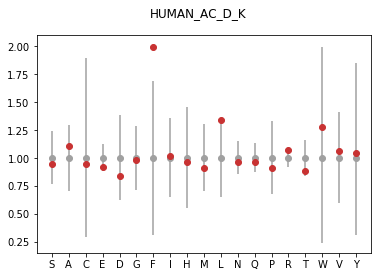

F 0.000119696302294
L 0.045594504905
{'N': 7.490970610296201, 'G': 16.239652561823043, 'C': 19.0, 'S': 8.4703116375591332, 'E': 0.60841734942686898, 'V': 13.174684870236664, 'T': 0.29334959438666863, 'W': 6.0376455483167275, 'P': 7.6387664300806, 'A': 5.4618046573112062, 'M': 6.4867683110128693, 'F': 0.00011969630229412291, 'D': 3.6405215970262872, 'Q': 7.4839723672007317, 'Y': 15.229257834909445, 'R': 0.13716121630994971, 'L': 0.045594504905004052, 'H': 16.427925095375091, 'I': 17.674589621775954}


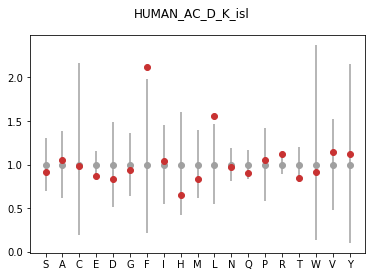

F 0.00628024526289
R 0.00857465785072
L 0.0019385116502
{'N': 12.772808530136974, 'G': 11.863145265128232, 'C': 19.0, 'S': 7.3281692561057348, 'E': 0.10335543587060203, 'V': 7.8554893103183012, 'T': 0.33627498599753286, 'W': 19.0, 'P': 14.430154739293222, 'A': 13.868135717662541, 'M': 3.3040895431504356, 'F': 0.0062802452628944166, 'D': 5.7248901614939331, 'Q': 1.1198473942995262, 'Y': 11.939687419791788, 'R': 0.0085746578507161289, 'L': 0.001938511650203838, 'H': 1.2979900121231727, 'I': 15.923176136956915}


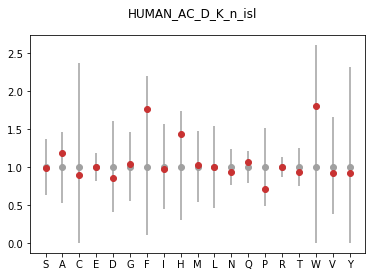

{'N': 8.1837987445559452, 'G': 15.359178047385894, 'C': 19.0, 'S': 17.792610472780822, 'E': 18.879470456028372, 'V': 14.739056199154188, 'T': 7.3161596044476749, 'W': 2.0457586529934679, 'P': 1.4225117577319697, 'A': 4.5167049215348962, 'M': 17.567167789116528, 'F': 0.56689586643107404, 'D': 9.2376994409579947, 'Q': 6.6859569572681394, 'Y': 19.0, 'R': 17.781516838219748, 'L': 17.789360515729271, 'H': 1.2162072209441521, 'I': 18.606087329645263}


In [5]:
d_human_ac = {'mutdict': {'A': {'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5514, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73593, 'R': 10194, 'T': 179131, 'W': 1024, 'V': 124760, 'Y': 1050, 'pK': 6}, 'C': {'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15063, 'R': 10364, 'T': 940, 'W': 2285, 'V': 1254, 'Y': 12706}, 'E': {'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 66978, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11674, 'R': 13283, 'T': 8327, 'W': 1102, 'V': 15876, 'Y': 1317, 'pK': 155}, 'D': {'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4171, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13148, 'R': 3846, 'T': 4824, 'W': 331, 'V': 7717, 'Y': 4755, 'pK': 5}, 'G': {'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6776, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 92030, 'R': 58908, 'T': 8509, 'W': 3683, 'V': 23640, 'Y': 935, 'pK': 5}, 'F': {'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13394, 'R': 996, 'T': 1094, 'W': 880, 'V': 7343, 'Y': 7900}, 'I': {'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2457, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8043, 'R': 3082, 'T': 33063, 'W': 205, 'V': 75199, 'Y': 560, 'pK': 9}, 'H': {'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1646, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6874, 'R': 37184, 'T': 1948, 'W': 468, 'V': 1099, 'Y': 20602, 'pK': 4}, 'K': {'A': 6814, 'C': 934, 'E': 45716, 'D': 4080, 'G': 7326, 'F': 1246, 'I': 4675, 'H': 2802, 'M': 6518, 'L': 4829, 'N': 28827, 'Q': 38240, 'P': 5697, 'S': 11020, 'R': 108406, 'T': 24857, 'W': 693, 'V': 3603, 'Y': 896}, 'M': {'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4513, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2189, 'R': 5161, 'T': 23395, 'W': 399, 'V': 38528, 'Y': 256, 'pK': 8}, 'L': {'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3114, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30649, 'R': 16288, 'T': 6426, 'W': 6038, 'V': 51978, 'Y': 2007, 'pK': 4}, 'N': {'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24406, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106998, 'R': 5851, 'T': 24810, 'W': 244, 'V': 2008, 'Y': 4014, 'pK': 56}, 'Q': {'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26313, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9234, 'R': 62056, 'T': 4360, 'W': 4430, 'V': 3055, 'Y': 1781, 'pK': 50}, 'P': {'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4309, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 160207, 'R': 25221, 'T': 43760, 'W': 1336, 'V': 8798, 'Y': 1474, 'pK': 6}, 'S': {'A': 87815, 'C': 32944, 'E': 8354, 'D': 11318, 'G': 94071, 'F': 25083, 'I': 13161, 'H': 10148, 'K': 9052, 'M': 2888, 'L': 46976, 'N': 90283, 'Q': 7236, 'P': 110377, 'R': 38338, 'T': 80684, 'W': 3405, 'V': 11664, 'Y': 8008, 'pK': 7}, 'R': {'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70398, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25989, 'T': 12585, 'W': 13299, 'V': 3585, 'Y': 1474, 'pK': 244}, 'T': {'A': 144730, 'C': 1682, 'E': 5105, 'D': 3481, 'G': 7308, 'F': 1848, 'I': 48582, 'H': 2353, 'K': 11746, 'M': 28982, 'L': 9289, 'N': 17651, 'Q': 3376, 'P': 45878, 'S': 79637, 'R': 11251, 'W': 557, 'V': 19592, 'Y': 901, 'pK': 25}, 'W': {'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1559, 'R': 5931, 'T': 293, 'V': 370, 'Y': 424}, 'V': {'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2597, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7825, 'R': 3688, 'T': 16048, 'W': 783, 'Y': 673, 'pK': 4}, 'Y': {'A': 780, 'C': 12862, 'E': 603, 'D': 2813, 'G': 942, 'F': 11215, 'I': 671, 'H': 12802, 'K': 438, 'M': 232, 'L': 2135, 'N': 2606, 'Q': 905, 'P': 1174, 'S': 6108, 'R': 1366, 'T': 710, 'W': 623, 'V': 693}, 'pK': {'A': 136, 'C': 16, 'E': 761, 'D': 62, 'G': 130, 'F': 45, 'I': 86, 'H': 49, 'M': 107, 'L': 117, 'N': 501, 'Q': 668, 'P': 94, 'S': 188, 'R': 2105, 'T': 396, 'W': 16, 'V': 69, 'Y': 17}}, 'sitenumdict': {'A': 366802, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 347637, 'M': 103818, 'L': 380908, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 572595, 'R': 326276, 'T': 279496, 'W': 29170, 'V': 203822, 'Y': 74393, 'pK': 12336}}
d_human_ac_n_isl = {'mutdict': {'A': {'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5518, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73593, 'R': 10194, 'T': 179131, 'W': 1024, 'V': 124760, 'Y': 1050, 'pK': 2}, 'C': {'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15063, 'R': 10364, 'T': 940, 'W': 2285, 'V': 1254, 'Y': 12706}, 'E': {'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67071, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11674, 'R': 13283, 'T': 8327, 'W': 1102, 'V': 15876, 'Y': 1317, 'pK': 62}, 'D': {'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4175, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13148, 'R': 3846, 'T': 4824, 'W': 331, 'V': 7717, 'Y': 4755, 'pK': 1}, 'G': {'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6780, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 92030, 'R': 58908, 'T': 8509, 'W': 3683, 'V': 23640, 'Y': 935, 'pK': 1}, 'F': {'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13394, 'R': 996, 'T': 1094, 'W': 880, 'V': 7343, 'Y': 7900}, 'I': {'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2458, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8043, 'R': 3082, 'T': 33063, 'W': 205, 'V': 75199, 'Y': 560, 'pK': 8}, 'H': {'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1649, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6874, 'R': 37184, 'T': 1948, 'W': 468, 'V': 1099, 'Y': 20602, 'pK': 1}, 'K': {'A': 6892, 'C': 944, 'E': 46148, 'D': 4117, 'G': 7401, 'F': 1275, 'I': 4728, 'H': 2822, 'M': 6577, 'L': 4911, 'N': 29133, 'Q': 38616, 'P': 5762, 'S': 11130, 'R': 109733, 'T': 25087, 'W': 700, 'V': 3648, 'Y': 907}, 'M': {'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4519, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2189, 'R': 5161, 'T': 23395, 'W': 399, 'V': 38528, 'Y': 256, 'pK': 2}, 'L': {'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3114, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30649, 'R': 16288, 'T': 6426, 'W': 6038, 'V': 51978, 'Y': 2007, 'pK': 4}, 'N': {'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24439, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106998, 'R': 5851, 'T': 24810, 'W': 244, 'V': 2008, 'Y': 4014, 'pK': 23}, 'Q': {'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26331, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9234, 'R': 62056, 'T': 4360, 'W': 4430, 'V': 3055, 'Y': 1781, 'pK': 32}, 'P': {'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4314, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 160207, 'R': 25221, 'T': 43760, 'W': 1336, 'V': 8798, 'Y': 1474, 'pK': 1}, 'S': {'A': 87815, 'C': 32944, 'E': 8354, 'D': 11318, 'G': 94071, 'F': 25083, 'I': 13161, 'H': 10148, 'K': 9055, 'M': 2888, 'L': 46976, 'N': 90283, 'Q': 7236, 'P': 110377, 'R': 38338, 'T': 80684, 'W': 3405, 'V': 11664, 'Y': 8008, 'pK': 4}, 'R': {'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70525, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25989, 'T': 12585, 'W': 13299, 'V': 3585, 'Y': 1474, 'pK': 117}, 'T': {'A': 144730, 'C': 1682, 'E': 5105, 'D': 3481, 'G': 7308, 'F': 1848, 'I': 48582, 'H': 2353, 'K': 11758, 'M': 28982, 'L': 9289, 'N': 17651, 'Q': 3376, 'P': 45878, 'S': 79637, 'R': 11251, 'W': 557, 'V': 19592, 'Y': 901, 'pK': 13}, 'W': {'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1559, 'R': 5931, 'T': 293, 'V': 370, 'Y': 424}, 'V': {'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2600, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7825, 'R': 3688, 'T': 16048, 'W': 783, 'Y': 673, 'pK': 1}, 'Y': {'A': 780, 'C': 12862, 'E': 603, 'D': 2813, 'G': 942, 'F': 11215, 'I': 671, 'H': 12802, 'K': 438, 'M': 232, 'L': 2135, 'N': 2606, 'Q': 905, 'P': 1174, 'S': 6108, 'R': 1366, 'T': 710, 'W': 623, 'V': 693}, 'pK': {'A': 58, 'C': 6, 'E': 329, 'D': 25, 'G': 55, 'F': 16, 'I': 33, 'H': 29, 'M': 48, 'L': 35, 'N': 195, 'Q': 292, 'P': 29, 'S': 78, 'R': 778, 'T': 166, 'W': 9, 'V': 24, 'Y': 6}}, 'sitenumdict': {'A': 366802, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 355585, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453150, 'S': 572595, 'R': 326277, 'T': 279497, 'W': 29170, 'V': 203822, 'Y': 74394, 'pK': 4388}}
d_human_ac_isl = {'mutdict': {'A': {'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5516, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73593, 'R': 10194, 'T': 179131, 'W': 1024, 'V': 124760, 'Y': 1050, 'pK': 4}, 'C': {'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15063, 'R': 10364, 'T': 940, 'W': 2285, 'V': 1254, 'Y': 12706}, 'E': {'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67040, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11674, 'R': 13283, 'T': 8327, 'W': 1102, 'V': 15876, 'Y': 1317, 'pK': 93}, 'D': {'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4172, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13148, 'R': 3846, 'T': 4824, 'W': 331, 'V': 7717, 'Y': 4755, 'pK': 4}, 'G': {'A': 61219, 'C': 8926, 'E': 55042, 'D': 43013, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6777, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 92030, 'R': 58908, 'T': 8509, 'W': 3683, 'V': 23640, 'Y': 935, 'pK': 4}, 'F': {'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13394, 'R': 996, 'T': 1094, 'W': 880, 'V': 7343, 'Y': 7900}, 'I': {'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2465, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8043, 'R': 3082, 'T': 33063, 'W': 205, 'V': 75199, 'Y': 560, 'pK': 1}, 'H': {'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1647, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6874, 'R': 37184, 'T': 1948, 'W': 468, 'V': 1099, 'Y': 20602, 'pK': 3}, 'K': {'A': 6872, 'C': 940, 'E': 46045, 'D': 4105, 'G': 7381, 'F': 1262, 'I': 4708, 'H': 2831, 'M': 6566, 'L': 4864, 'N': 29022, 'Q': 38532, 'P': 5726, 'S': 11098, 'R': 109184, 'T': 25023, 'W': 702, 'V': 3627, 'Y': 902}, 'M': {'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4515, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2189, 'R': 5161, 'T': 23395, 'W': 399, 'V': 38528, 'Y': 256, 'pK': 6}, 'L': {'A': 10556, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30649, 'R': 16288, 'T': 6426, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24429, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106998, 'R': 5851, 'T': 24810, 'W': 244, 'V': 2008, 'Y': 4014, 'pK': 33}, 'Q': {'A': 7068, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26345, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9234, 'R': 62056, 'T': 4360, 'W': 4430, 'V': 3055, 'Y': 1781, 'pK': 18}, 'P': {'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4310, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 160207, 'R': 25221, 'T': 43760, 'W': 1336, 'V': 8798, 'Y': 1474, 'pK': 5}, 'S': {'A': 87815, 'C': 32944, 'E': 8354, 'D': 11318, 'G': 94071, 'F': 25083, 'I': 13161, 'H': 10148, 'K': 9056, 'M': 2888, 'L': 46976, 'N': 90283, 'Q': 7236, 'P': 110377, 'R': 38338, 'T': 80684, 'W': 3405, 'V': 11664, 'Y': 8008, 'pK': 3}, 'R': {'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70515, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25989, 'T': 12585, 'W': 13299, 'V': 3585, 'Y': 1474, 'pK': 127}, 'T': {'A': 144730, 'C': 1682, 'E': 5105, 'D': 3481, 'G': 7308, 'F': 1848, 'I': 48582, 'H': 2353, 'K': 11759, 'M': 28982, 'L': 9289, 'N': 17651, 'Q': 3376, 'P': 45878, 'S': 79637, 'R': 11251, 'W': 557, 'V': 19592, 'Y': 901, 'pK': 12}, 'W': {'A': 415, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1559, 'R': 5931, 'T': 293, 'V': 370, 'Y': 424}, 'V': {'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2598, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7825, 'R': 3688, 'T': 16048, 'W': 783, 'Y': 673, 'pK': 3}, 'Y': {'A': 780, 'C': 12862, 'E': 603, 'D': 2813, 'G': 942, 'F': 11215, 'I': 671, 'H': 12802, 'K': 438, 'M': 232, 'L': 2135, 'N': 2606, 'Q': 905, 'P': 1174, 'S': 6108, 'R': 1366, 'T': 710, 'W': 623, 'V': 693}, 'pK': {'A': 78, 'C': 10, 'E': 432, 'D': 37, 'G': 75, 'F': 29, 'I': 53, 'H': 20, 'M': 59, 'L': 82, 'N': 306, 'Q': 376, 'P': 65, 'S': 110, 'R': 1327, 'T': 230, 'W': 7, 'V': 45, 'Y': 11}}, 'sitenumdict': {'A': 366802, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 352025, 'M': 103818, 'L': 380908, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 572595, 'R': 326276, 'T': 279496, 'W': 29170, 'V': 203822, 'Y': 74393, 'pK': 7948}}
#

mutdict = d_human_ac["mutdict"]
print(plot_differences(mutdict, 'K', 0.0013, "K", True, "HUMAN_AC_D_K"))

mutdict = d_human_ac_isl["mutdict"]
print(plot_differences(mutdict, 'K', 0.0013, "K", True, "HUMAN_AC_D_K_isl"))

mutdict = d_human_ac_n_isl["mutdict"]
print(plot_differences(mutdict, 'K', 0.0013, "K", True, "HUMAN_AC_D_K_n_isl"))

In [68]:
#Mouse phosphosite conservation
d_mouse_iptmnet = {'mutdict': {'pS': {'A': 2766, 'C': 1091, 'E': 359, 'G': 2920, 'pT': 2600, 'F': 804, 'I': 436, 'H': 264, 'K': 337, 'pY': 258, 'M': 103, 'L': 1580, 'N': 2659, 'Q': 263, 'P': 3243, 'R': 1068, 'W': 123, 'V': 390, 'D': 402}, 'pT': {'A': 2759, 'pS': 2025, 'C': 35, 'E': 100, 'D': 72, 'G': 136, 'F': 41, 'I': 857, 'H': 47, 'K': 173, 'pY': 17, 'M': 478, 'L': 185, 'N': 352, 'Q': 69, 'P': 861, 'R': 227, 'W': 13, 'V': 372}, 'pY': {'A': 11, 'pS': 111, 'C': 196, 'E': 17, 'pT': 13, 'G': 34, 'F': 169, 'I': 23, 'H': 167, 'K': 8, 'M': 2, 'L': 30, 'N': 28, 'Q': 21, 'P': 22, 'R': 30, 'W': 15, 'V': 12, 'D': 20}, 'A': {'pS': 844, 'pT': 1686, 'pY': 7, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 54756, 'R': 7357, 'T': 133507, 'W': 752, 'V': 92176, 'Y': 730}, 'C': {'pS': 163, 'pT': 10, 'pY': 119, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11069, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9080}, 'E': {'pS': 83, 'pT': 17, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8396, 'R': 9770, 'T': 6022, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 111, 'pT': 28, 'pY': 14, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9706, 'R': 2861, 'T': 3525, 'W': 255, 'V': 5647, 'Y': 3527}, 'G': {'pS': 1043, 'pT': 38, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69464, 'R': 43379, 'T': 6165, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 111, 'pT': 8, 'pY': 24, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 9976, 'R': 775, 'T': 772, 'W': 631, 'V': 5582, 'Y': 5944}, 'I': {'pS': 78, 'pT': 270, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5743, 'R': 2364, 'T': 25180, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 53, 'pT': 9, 'pY': 69, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5036, 'R': 27401, 'T': 1372, 'W': 315, 'V': 760, 'Y': 15030}, 'K': {'pS': 55, 'pT': 112, 'pY': 2, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8255, 'R': 83143, 'T': 18540, 'W': 558, 'V': 2785, 'Y': 631}, 'M': {'pS': 17, 'pT': 124, 'pY': 3, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1622, 'R': 3896, 'T': 17497, 'W': 313, 'V': 29030, 'Y': 160}, 'L': {'pS': 240, 'pT': 42, 'pY': 6, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22230, 'R': 11955, 'T': 4750, 'W': 4378, 'V': 38863, 'Y': 1411}, 'N': {'pS': 1406, 'pT': 281, 'pY': 37, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 79358, 'R': 4354, 'T': 18809, 'W': 171, 'V': 1444, 'Y': 2856}, 'Q': {'pS': 47, 'pT': 12, 'pY': 5, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6441, 'R': 46123, 'T': 3069, 'W': 3236, 'V': 2194, 'Y': 1233}, 'P': {'pS': 1622, 'pT': 337, 'pY': 8, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 114749, 'R': 18053, 'T': 31390, 'W': 912, 'V': 6362, 'Y': 1029}, 'S': {'A': 61533, 'C': 22719, 'E': 5424, 'D': 7742, 'G': 67213, 'F': 16969, 'I': 8980, 'H': 6964, 'K': 6017, 'M': 1944, 'L': 32382, 'N': 64339, 'Q': 4812, 'P': 76076, 'R': 26590, 'T': 56105, 'W': 2315, 'V': 7779, 'Y': 5420}, 'R': {'pS': 147, 'pT': 60, 'pY': 3, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19074, 'T': 9087, 'W': 9587, 'V': 2538, 'Y': 1069}, 'T': {'A': 105339, 'C': 1106, 'E': 3656, 'D': 2428, 'G': 5118, 'F': 1300, 'I': 34813, 'H': 1602, 'K': 8842, 'M': 21259, 'L': 6559, 'N': 13070, 'Q': 2296, 'P': 32621, 'S': 57929, 'R': 8059, 'W': 377, 'V': 13986, 'Y': 617}, 'W': {'pS': 10, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1058, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 59, 'pT': 74, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5685, 'R': 2742, 'T': 12117, 'W': 584, 'Y': 486}, 'Y': {'A': 581, 'C': 9890, 'E': 425, 'D': 2130, 'G': 645, 'F': 8460, 'I': 462, 'H': 9794, 'K': 312, 'M': 176, 'L': 1570, 'N': 1992, 'Q': 650, 'P': 829, 'S': 4633, 'R': 1057, 'T': 571, 'W': 468, 'V': 549}}, 'sitenumdict': {'pS': 49928, 'pT': 12392, 'pY': 3628, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298249, 'F': 80771, 'I': 96049, 'H': 99527, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 430221, 'R': 265574, 'T': 214208, 'W': 22648, 'V': 171168, 'Y': 56177}}
d_mouse_iptmnet_isl = {'mutdict': {'pS': {'A': 1254, 'C': 469, 'E': 180, 'pT': 1236, 'G': 1376, 'F': 343, 'I': 195, 'H': 115, 'K': 163, 'pY': 126, 'M': 47, 'L': 731, 'N': 1167, 'Q': 117, 'P': 1455, 'R': 479, 'W': 57, 'V': 161, 'D': 196}, 'pT': {'A': 1428, 'pS': 1062, 'C': 20, 'E': 64, 'D': 36, 'G': 56, 'F': 17, 'I': 411, 'H': 23, 'K': 97, 'pY': 10, 'M': 204, 'L': 99, 'N': 186, 'Q': 40, 'P': 435, 'R': 121, 'W': 8, 'V': 194}, 'pY': {'A': 6, 'pS': 58, 'C': 78, 'E': 5, 'pT': 7, 'G': 18, 'F': 66, 'I': 6, 'H': 74, 'K': 6, 'L': 16, 'N': 11, 'Q': 13, 'P': 5, 'R': 17, 'W': 10, 'V': 4, 'D': 10}, 'A': {'pS': 395, 'pT': 859, 'pY': 4, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55205, 'R': 7357, 'T': 134334, 'W': 752, 'V': 92176, 'Y': 733}, 'C': {'pS': 85, 'pT': 10, 'pY': 72, 'A': 1313, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11147, 'R': 7503, 'T': 653, 'W': 1563, 'V': 879, 'Y': 9127}, 'E': {'pS': 46, 'pT': 11, 'pY': 1, 'A': 28720, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8433, 'R': 9770, 'T': 6028, 'W': 777, 'V': 11506, 'Y': 944}, 'D': {'pS': 50, 'pT': 15, 'pY': 5, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9767, 'R': 2861, 'T': 3538, 'W': 255, 'V': 5647, 'Y': 3536}, 'G': {'A': 45784, 'pS': 485, 'C': 6727, 'E': 40811, 'D': 31573, 'pT': 21, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 70022, 'R': 43379, 'T': 6182, 'W': 2604, 'V': 17435, 'Y': 702}, 'F': {'pS': 59, 'pT': 1, 'pY': 9, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10028, 'R': 775, 'T': 779, 'W': 631, 'V': 5582, 'Y': 5959}, 'I': {'A': 4634, 'pS': 27, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'pT': 110, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5794, 'R': 2364, 'T': 25340, 'W': 149, 'V': 58861, 'Y': 440}, 'H': {'pS': 32, 'pT': 4, 'pY': 29, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5057, 'R': 27401, 'T': 1377, 'W': 315, 'V': 760, 'Y': 15070}, 'K': {'pS': 16, 'pT': 35, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8294, 'R': 83143, 'T': 18617, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 13, 'pT': 47, 'pY': 2, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1626, 'R': 3896, 'T': 17574, 'W': 313, 'V': 29030, 'Y': 161}, 'L': {'pS': 119, 'pT': 26, 'pY': 2, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22351, 'R': 11955, 'T': 4766, 'W': 4378, 'V': 38863, 'Y': 1415}, 'N': {'pS': 625, 'pT': 144, 'pY': 18, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 80139, 'R': 4354, 'T': 18946, 'W': 171, 'V': 1444, 'Y': 2875}, 'Q': {'pS': 24, 'pT': 3, 'pY': 2, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6464, 'R': 46123, 'T': 3078, 'W': 3236, 'V': 2194, 'Y': 1236}, 'P': {'pS': 668, 'pT': 142, 'pY': 4, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115703, 'R': 18053, 'T': 31585, 'W': 912, 'V': 6362, 'Y': 1033}, 'S': {'A': 63045, 'C': 23341, 'E': 5603, 'D': 7948, 'G': 68757, 'F': 17430, 'I': 9221, 'H': 7113, 'K': 6191, 'M': 2000, 'L': 33231, 'N': 65831, 'Q': 4958, 'P': 77864, 'R': 27179, 'T': 57469, 'W': 2381, 'V': 8008, 'Y': 5552}, 'R': {'pS': 49, 'pT': 19, 'pY': 1, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19172, 'T': 9128, 'W': 9587, 'V': 2538, 'Y': 1071}, 'T': {'A': 106670, 'C': 1121, 'E': 3692, 'D': 2464, 'G': 5198, 'F': 1324, 'I': 35259, 'H': 1626, 'K': 8918, 'M': 21533, 'L': 6645, 'N': 13236, 'Q': 2325, 'P': 33047, 'S': 58892, 'R': 8165, 'W': 382, 'V': 14164, 'Y': 624}, 'W': {'A': 239, 'pS': 3, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1065, 'R': 4381, 'T': 200, 'V': 238, 'Y': 310}, 'V': {'A': 61637, 'pS': 27, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'pT': 29, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5717, 'R': 2742, 'T': 12162, 'W': 584, 'Y': 487}, 'Y': {'A': 586, 'C': 10008, 'E': 437, 'D': 2140, 'G': 661, 'F': 8563, 'I': 479, 'H': 9887, 'K': 314, 'M': 178, 'L': 1584, 'N': 2009, 'Q': 658, 'P': 846, 'S': 4686, 'R': 1070, 'T': 577, 'W': 473, 'V': 557}}, 'sitenumdict': {'pS': 25816, 'pT': 7015, 'pY': 1701, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219998, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 454333, 'R': 265574, 'T': 219585, 'W': 22648, 'V': 171168, 'Y': 58104}}
d_mouse_iptmnet_n_isl = {'mutdict': {'pS': {'A': 1512, 'C': 622, 'E': 179, 'pT': 1364, 'G': 1544, 'F': 461, 'I': 241, 'H': 149, 'K': 174, 'pY': 132, 'M': 56, 'L': 849, 'N': 1492, 'Q': 146, 'P': 1788, 'R': 589, 'W': 66, 'V': 229, 'D': 206}, 'pT': {'A': 1331, 'pS': 963, 'C': 15, 'E': 36, 'D': 36, 'G': 80, 'F': 24, 'I': 446, 'H': 24, 'K': 76, 'pY': 7, 'M': 274, 'L': 86, 'N': 166, 'Q': 29, 'P': 426, 'R': 106, 'W': 5, 'V': 178}, 'pY': {'A': 5, 'pS': 53, 'C': 118, 'E': 12, 'D': 10, 'G': 16, 'F': 103, 'pT': 6, 'H': 93, 'K': 2, 'M': 2, 'L': 14, 'N': 17, 'Q': 8, 'P': 17, 'R': 13, 'W': 5, 'V': 8, 'I': 17}, 'A': {'pS': 449, 'pT': 827, 'pY': 3, 'C': 2482, 'E': 19240, 'D': 12881, 'G': 39301, 'F': 2169, 'I': 6652, 'H': 1852, 'K': 3977, 'M': 5018, 'L': 9739, 'N': 3308, 'Q': 4041, 'P': 40149, 'S': 55151, 'R': 7357, 'T': 134366, 'W': 752, 'V': 92176, 'Y': 734}, 'C': {'A': 1313, 'pS': 78, 'E': 317, 'D': 666, 'G': 7123, 'F': 2764, 'I': 373, 'H': 3787, 'K': 318, 'pY': 47, 'M': 181, 'L': 1688, 'N': 666, 'Q': 624, 'P': 1141, 'S': 11154, 'R': 7503, 'T': 663, 'W': 1563, 'V': 879, 'Y': 9152}, 'E': {'A': 28720, 'pS': 37, 'C': 983, 'D': 92731, 'G': 46737, 'F': 1279, 'I': 1777, 'H': 2704, 'K': 49263, 'M': 1838, 'L': 5091, 'pT': 6, 'N': 5063, 'Q': 34835, 'P': 6242, 'S': 8442, 'R': 9770, 'T': 6033, 'W': 777, 'V': 11506, 'Y': 945}, 'D': {'pS': 61, 'pT': 13, 'pY': 9, 'A': 14208, 'C': 1020, 'E': 71718, 'G': 32325, 'F': 816, 'I': 1262, 'H': 8625, 'K': 3156, 'M': 539, 'L': 2053, 'N': 36163, 'Q': 2569, 'P': 3053, 'S': 9756, 'R': 2861, 'T': 3540, 'W': 255, 'V': 5647, 'Y': 3532}, 'G': {'pS': 558, 'pT': 17, 'pY': 1, 'A': 45784, 'C': 6727, 'E': 40811, 'D': 31573, 'F': 1001, 'I': 1809, 'H': 2608, 'K': 4909, 'M': 1177, 'L': 3523, 'N': 5886, 'Q': 4272, 'P': 6041, 'S': 69949, 'R': 43379, 'T': 6186, 'W': 2604, 'V': 17435, 'Y': 701}, 'F': {'pS': 52, 'pT': 7, 'pY': 15, 'A': 1377, 'C': 4258, 'E': 363, 'D': 306, 'G': 747, 'I': 4146, 'H': 805, 'K': 345, 'M': 447, 'L': 27002, 'N': 335, 'Q': 365, 'P': 1662, 'S': 10035, 'R': 775, 'T': 773, 'W': 631, 'V': 5582, 'Y': 5953}, 'I': {'pS': 51, 'pT': 160, 'pY': 5, 'A': 4634, 'C': 387, 'E': 844, 'D': 704, 'G': 1413, 'F': 4447, 'H': 484, 'K': 2039, 'M': 16806, 'L': 22675, 'N': 3011, 'Q': 531, 'P': 1559, 'S': 5770, 'R': 2364, 'T': 25290, 'W': 149, 'V': 58861, 'Y': 435}, 'H': {'pS': 21, 'pT': 5, 'pY': 40, 'A': 1673, 'C': 5980, 'E': 1331, 'D': 3964, 'G': 2216, 'F': 1221, 'I': 543, 'K': 1211, 'M': 250, 'L': 8408, 'N': 7781, 'Q': 25085, 'P': 16317, 'S': 5068, 'R': 27401, 'T': 1376, 'W': 315, 'V': 760, 'Y': 15059}, 'K': {'pS': 39, 'pT': 77, 'pY': 1, 'A': 5144, 'C': 685, 'E': 34190, 'D': 3004, 'G': 5473, 'F': 933, 'I': 3427, 'H': 2075, 'M': 4751, 'L': 3664, 'N': 21805, 'Q': 28906, 'P': 4254, 'S': 8271, 'R': 83143, 'T': 18575, 'W': 558, 'V': 2785, 'Y': 632}, 'M': {'pS': 4, 'pT': 77, 'pY': 1, 'A': 3779, 'C': 262, 'E': 1059, 'D': 281, 'G': 1332, 'F': 577, 'I': 15840, 'H': 237, 'K': 3310, 'L': 20350, 'N': 398, 'Q': 732, 'P': 1247, 'S': 1635, 'R': 3896, 'T': 17544, 'W': 313, 'V': 29030, 'Y': 162}, 'L': {'pS': 121, 'pT': 16, 'pY': 4, 'A': 7730, 'C': 2594, 'E': 2771, 'D': 1155, 'G': 3595, 'F': 31130, 'I': 17218, 'H': 6084, 'K': 2273, 'M': 16256, 'N': 1031, 'Q': 12782, 'P': 43380, 'S': 22349, 'R': 11955, 'T': 4776, 'W': 4378, 'V': 38863, 'Y': 1413}, 'N': {'pS': 781, 'pT': 137, 'pY': 19, 'A': 3445, 'C': 1066, 'E': 3557, 'D': 29638, 'G': 7757, 'F': 663, 'I': 4928, 'H': 18472, 'K': 18540, 'M': 660, 'L': 1769, 'Q': 2527, 'P': 2317, 'S': 79983, 'R': 4354, 'T': 18953, 'W': 171, 'V': 1444, 'Y': 2874}, 'Q': {'pS': 23, 'pT': 9, 'pY': 3, 'A': 5099, 'C': 1043, 'E': 26522, 'D': 2232, 'G': 5131, 'F': 816, 'I': 913, 'H': 32459, 'K': 19393, 'M': 1017, 'L': 17158, 'N': 2185, 'P': 41652, 'S': 6465, 'R': 46123, 'T': 3072, 'W': 3236, 'V': 2194, 'Y': 1235}, 'P': {'pS': 954, 'pT': 195, 'pY': 4, 'A': 57191, 'C': 2628, 'E': 4626, 'D': 2225, 'G': 6643, 'F': 3176, 'I': 2342, 'H': 12856, 'K': 3040, 'M': 1587, 'L': 81466, 'N': 1865, 'Q': 22130, 'S': 115417, 'R': 18053, 'T': 31532, 'W': 912, 'V': 6362, 'Y': 1033}, 'S': {'A': 62787, 'C': 23188, 'E': 5604, 'D': 7938, 'G': 68589, 'F': 17312, 'I': 9175, 'H': 7079, 'K': 6180, 'M': 1991, 'L': 33113, 'N': 65506, 'Q': 4929, 'P': 77531, 'R': 27069, 'T': 57341, 'W': 2372, 'V': 7940, 'Y': 5546}, 'R': {'pS': 98, 'pT': 41, 'pY': 2, 'A': 5869, 'C': 10317, 'E': 5521, 'D': 1647, 'G': 31275, 'F': 1015, 'I': 2539, 'H': 22655, 'K': 53835, 'M': 2588, 'L': 10491, 'N': 2676, 'Q': 43464, 'P': 12091, 'S': 19123, 'T': 9106, 'W': 9587, 'V': 2538, 'Y': 1070}, 'T': {'A': 106767, 'C': 1126, 'E': 3720, 'D': 2464, 'G': 5174, 'F': 1317, 'I': 35224, 'H': 1625, 'K': 8939, 'M': 21463, 'L': 6658, 'N': 13256, 'Q': 2336, 'P': 33056, 'S': 58991, 'R': 8180, 'W': 385, 'V': 14180, 'Y': 627}, 'W': {'pS': 7, 'pT': 1, 'pY': 1, 'A': 239, 'C': 1994, 'E': 280, 'D': 88, 'G': 1977, 'F': 396, 'I': 101, 'H': 184, 'K': 224, 'M': 141, 'L': 2029, 'N': 87, 'Q': 1361, 'P': 399, 'S': 1061, 'R': 4381, 'T': 199, 'V': 238, 'Y': 309}, 'V': {'pS': 32, 'pT': 45, 'pY': 1, 'A': 61637, 'C': 1106, 'E': 8583, 'D': 3688, 'G': 19220, 'F': 4572, 'I': 56721, 'H': 655, 'K': 1986, 'M': 28680, 'L': 30820, 'N': 1074, 'Q': 1435, 'P': 3707, 'S': 5712, 'R': 2742, 'T': 12146, 'W': 584, 'Y': 486}, 'Y': {'A': 587, 'C': 9968, 'E': 430, 'D': 2140, 'G': 663, 'F': 8526, 'I': 468, 'H': 9868, 'K': 318, 'M': 176, 'L': 1586, 'N': 2003, 'Q': 663, 'P': 834, 'S': 4691, 'R': 1074, 'T': 578, 'W': 478, 'V': 553}}, 'sitenumdict': {'pS': 24112, 'pT': 5377, 'pY': 1927, 'A': 299282, 'C': 61698, 'E': 392656, 'D': 219997, 'G': 298250, 'F': 80771, 'I': 96049, 'H': 99528, 'K': 290660, 'M': 86802, 'L': 312487, 'N': 137925, 'Q': 235024, 'P': 366365, 'S': 456037, 'R': 265574, 'T': 221223, 'W': 22648, 'V': 171169, 'Y': 57878}}


In [73]:
def mut_freq_f(mut_dict, aacid):
    mut_num = 0
    for aacid_des in mut_dict["mutdict"][aacid].keys():
        mut_num += mut_dict["mutdict"][aacid][aacid_des]
    return mut_num, mut_dict["sitenumdict"][aacid], float(mut_num)/mut_dict["sitenumdict"][aacid]

def freq_compar(mut_dict, aacid):
    mut_num, site_num, mut_freq = mut_freq_f(mut_dict, aacid)
    mut_num_p, site_num_p, mut_freq_p = mut_freq_f(mut_dict, 'p' + aacid)
    g, pvalue, dof, expctd = stats.chi2_contingency([[mut_num, site_num], [mut_num_p, site_num_p]])
    print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(aacid, mut_num, site_num, mut_freq,
                         mut_num_p, site_num_p, mut_freq_p,
                         mut_freq_p/mut_freq, pvalue))
    
def print_cons(mut_dict):
    for aacid in "STY":
        freq_compar(mut_dict, aacid)

In [75]:
print_cons(d_mouse_iptmnet)
print_cons(d_mouse_iptmnet_isl)
print_cons(d_mouse_iptmnet_n_isl)

S	481323	430221	1.1187808126521022	21666	49928	0.4339448806281045	0.38787300936939173	0.0
T	320977	214208	1.4984360994920825	8819	12392	0.7116688185926404	0.4749410527641928	0.0
Y	45194	56177	0.8044929419513324	929	3628	0.25606394707828006	0.31829234754650043	1.1867724174159977e-227
S	493122	454333	1.085375704604332	9867	25816	0.3822048342113418	0.35214058375359764	0.0
T	325285	219585	1.4813625703030717	4511	7015	0.6430506058446187	0.43409400151986904	0.0
Y	45713	58104	0.7867444582128597	410	1701	0.24103468547912993	0.3063697277597044	1.1964778707385333e-112
S	491190	456037	1.0770836576856702	11799	24112	0.4893414067684141	0.4543207050600527	0.0
T	325488	221223	1.4713117532987077	4308	5377	0.8011902547889157	0.5445414630805692	3.5630750326834044e-196
Y	45604	57878	0.7879332388817858	519	1927	0.269330565646082	0.34181901759634975	3.415513605850388e-112


In [78]:
g, pvalue, dof, expctd = stats.chi2_contingency([[21666, 49928], [9867, 25816]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[21666, 49928], [11799, 24112]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[11799, 24112], [9867, 25816]])
print(pvalue)
print()

g, pvalue, dof, expctd = stats.chi2_contingency([[929, 3628], [410, 1701]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[929, 3628], [519, 1927]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[410, 1701], [519, 1927]])
print(pvalue)
print()

g, pvalue, dof, expctd = stats.chi2_contingency([[8819, 12392], [4511, 7015]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[8819, 12392], [4308, 5377]])
print(pvalue)
g, pvalue, dof, expctd = stats.chi2_contingency([[4511, 7015], [4308, 5377]])
print(pvalue)

9.952619572376806e-19
4.863804186569177e-18
7.794640722222385e-52

0.3781690525259843
0.4302531511019223
0.14320169552929302

1.870869889572523e-05
1.776035434218773e-06
4.114416151087643e-15


here, we compare the R values of pS-to-E and pS-to-D mutations

In [19]:
hmr_cons_dr = {'mutdict': {'pS': {'A': 1863, 'C': 714, 'E': 305, 'G': 1879, 'pT': 1843, 'F': 528, 'I': 287, 'H': 212, 'K': 253, 'pY': 195, 'M': 94, 'L': 1092, 'N': 1733, 'Q': 212, 'P': 2174, 'R': 702, 'W': 76, 'V': 288, 'D': 303}, 'pT': {'A': 1334, 'pS': 1073, 'C': 23, 'E': 49, 'D': 43, 'G': 73, 'F': 23, 'I': 370, 'H': 30, 'K': 95, 'pY': 8, 'M': 229, 'L': 114, 'N': 150, 'Q': 37, 'P': 430, 'R': 83, 'W': 11, 'V': 157}, 'pY': {'A': 14, 'pS': 79, 'C': 130, 'G': 16, 'E': 15, 'D': 31, 'pT': 12, 'F': 140, 'I': 19, 'H': 130, 'K': 6, 'M': 4, 'L': 27, 'N': 16, 'Q': 12, 'P': 15, 'R': 32, 'W': 11, 'V': 12}, 'A': {'pS': 203, 'pT': 371, 'pY': 3, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73390, 'R': 10194, 'T': 178760, 'W': 1024, 'V': 124760, 'Y': 1047}, 'C': {'pS': 59, 'pT': 1, 'pY': 37, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15004, 'R': 10364, 'T': 939, 'W': 2285, 'V': 1254, 'Y': 12669}, 'E': {'pS': 43, 'pT': 7, 'pY': 2, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11631, 'R': 13283, 'T': 8320, 'W': 1102, 'V': 15876, 'Y': 1315}, 'D': {'pS': 28, 'pT': 10, 'pY': 4, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13120, 'R': 3846, 'T': 4814, 'W': 331, 'V': 7717, 'Y': 4751}, 'G': {'A': 61219, 'pS': 243, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 8, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91787, 'R': 58908, 'T': 8501, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'pS': 13, 'pT': 3, 'pY': 16, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13381, 'R': 996, 'T': 1091, 'W': 880, 'V': 7343, 'Y': 7884}, 'I': {'pS': 18, 'pT': 59, 'pY': 2, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8025, 'R': 3082, 'T': 33004, 'W': 205, 'V': 75199, 'Y': 558}, 'H': {'pS': 15, 'pT': 2, 'pY': 8, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6859, 'R': 37184, 'T': 1946, 'W': 468, 'V': 1099, 'Y': 20594}, 'K': {'pS': 9, 'pT': 20, 'pY': 5, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11199, 'R': 110511, 'T': 25233, 'W': 709, 'V': 3672, 'Y': 908}, 'M': {'pS': 3, 'pT': 40, 'pY': 1, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2186, 'R': 5161, 'T': 23355, 'W': 399, 'V': 38528, 'Y': 255}, 'L': {'A': 10556, 'pS': 70, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 7, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30579, 'R': 16288, 'T': 6419, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 279, 'pT': 60, 'pY': 10, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106719, 'R': 5851, 'T': 24750, 'W': 244, 'V': 2008, 'Y': 4004}, 'Q': {'A': 7068, 'pS': 27, 'pT': 6, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'C': 1383, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9207, 'R': 62056, 'T': 4354, 'W': 4430, 'V': 3055, 'Y': 1781, 'I': 1302}, 'P': {'pS': 362, 'pT': 84, 'pY': 1, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 159845, 'R': 25221, 'T': 43676, 'W': 1336, 'V': 8798, 'Y': 1473}, 'S': {'A': 85952, 'C': 32230, 'E': 8049, 'D': 11015, 'G': 92192, 'F': 24555, 'I': 12874, 'H': 9936, 'K': 8806, 'M': 2794, 'L': 45884, 'N': 88550, 'Q': 7024, 'P': 108203, 'R': 37636, 'T': 78841, 'W': 3329, 'V': 11376, 'Y': 7813}, 'R': {'pS': 29, 'pT': 18, 'pY': 1, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25960, 'T': 12567, 'W': 13299, 'V': 3585, 'Y': 1473}, 'T': {'A': 143396, 'C': 1659, 'E': 5056, 'D': 3438, 'G': 7235, 'F': 1825, 'I': 48212, 'H': 2323, 'K': 11676, 'M': 28753, 'L': 9175, 'N': 17501, 'Q': 3339, 'P': 45448, 'S': 78564, 'R': 11168, 'W': 546, 'V': 19435, 'Y': 893}, 'W': {'A': 415, 'pS': 3, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'pT': 1, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1556, 'R': 5931, 'T': 292, 'V': 370, 'Y': 424}, 'V': {'pS': 27, 'pT': 21, 'pY': 2, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7798, 'R': 3688, 'T': 16027, 'W': 783, 'Y': 671}, 'Y': {'A': 766, 'C': 12732, 'E': 588, 'D': 2782, 'G': 926, 'F': 11075, 'I': 652, 'H': 12672, 'K': 432, 'M': 228, 'L': 2108, 'N': 2590, 'Q': 893, 'P': 1159, 'S': 6029, 'R': 1334, 'T': 698, 'W': 612, 'V': 681}}, 'sitenumdict': {'pS': 33692, 'pT': 7017, 'pY': 2743, 'A': 366801, 'C': 82495, 'E': 480569, 'D': 256682, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127186, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 538903, 'R': 326277, 'T': 272480, 'W': 29170, 'V': 203821, 'Y': 71651}}

def mutdict_R_diffs(mutdict, permut_num):
    n_pS_to_E = float(mutdict["pS"]['E'])
    n_pS_to_D = float(mutdict["pS"]['D'])
    n_pS = mutdict_colsum(mutdict, 'pS')
    n_S_to_E = float(mutdict["S"]['E'])
    n_S_to_D = float(mutdict["S"]['D'])
    n_S = mutdict_colsum(mutdict, 'S')
    
    r_n_pS_to_E = np.random.poisson(n_pS_to_E, permut_num)
    r_n_pS_to_D = np.random.poisson(n_pS_to_D, permut_num)
    r_n_S_to_E = np.random.poisson(n_S_to_E, permut_num)
    r_n_S_to_D = np.random.poisson(n_S_to_D, permut_num)
    
#    print(mutdict["S"])
#    print(r_n_pS_to_E, r_n_pS_to_D, r_n_S_to_E , r_n_S_to_D )
    
    r_p_pS_to_E = r_n_pS_to_E/n_pS
    r_p_pS_to_D = r_n_pS_to_D/n_pS
    
    r_p_S_to_E = r_n_S_to_E/n_S
    r_p_S_to_D = r_n_S_to_D/n_S
    
    R1 = r_p_pS_to_E/r_p_S_to_E
    R2 = r_p_pS_to_D/r_p_S_to_D
    
#    print(R1, R2)
    
    return np.sum(R1 < R2)
        

In [22]:
mutdict_R_diffs(hmr_cons_dr["mutdict"], 1000)

0